# Machine Learning - Kelas A11.44UG1A Comparative Study for Multi-label Hate Speech and Abusive Language Detection in Indonesian Twitters
Hanif Cahyo Prasetyodi A11.2022.14075041

## Import Library

In [3]:
!pip install PySastrawi

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/hanif/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction import DictVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD

import gensim
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore")

In [6]:
data = pd.read_csv('datasets/data.csv', encoding='latin-1')

alay_dict = pd.read_csv('datasets/new_kamusalay.csv', encoding='latin-1', header=None)

id_stopword_dict = pd.read_csv('datasets/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

abusive_dict = pd.read_csv('datasets/abusive.csv')['ABUSIVE'].tolist()

## Data Shape

In [8]:
print("Shape: ", data.shape)
data.head(5)

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [9]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [10]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [11]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


Alay Dict

In [13]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,0,1
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


ID Stopword

In [15]:
print("Shape: ", id_stopword_dict.shape)
id_stopword_dict.head()

Shape:  (758, 1)


,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


## Preprocess Data

In [17]:
alay_dict

,0,1
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [18]:
import re
import unicodedata
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_unicode(text):
    text = re.sub(r'\bx[a-fA-F0-9]{2}\b', '', text) 
    text = re.sub(r'\bx([a-fA-F0-9]{2})', '', text)
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict[0], alay_dict[1]))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [19]:
def preprocess(text):
    text = lowercase(text) 
    text = remove_nonaplhanumeric(text) 
    text = remove_unnecessary_char(text) 
    text = normalize_alay(text)
    text = stemming(text) 
    text = remove_stopword(text) 
    text = remove_unicode(text) 
    text = remove_extra_spaces(text) 
    return text

In [20]:
data['Tweet'] = data['Tweet'].apply(preprocess)

In [21]:
print("Shape: ", data.shape)
data.head(100)

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,cowok usaha lacak perhati gue lantas remeh per...,1,1,1,0,0,0,0,0,1,1,0,0
1,telat tau edan sarap gue gaul cigax jifla cal ...,0,1,0,0,0,0,0,0,0,0,0,0
2,41 kadang pikir percaya tuhan jatuh kali kali ...,0,0,0,0,0,0,0,0,0,0,0,0
3,ku tau mata sipit lihat,0,0,0,0,0,0,0,0,0,0,0,0
4,kaum cebong kafir lihat dongok dungu haha,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,salah target ahok agenda utama lengser jokowi,1,0,1,0,0,0,0,0,1,0,0,1
96,kena tagar panas banget 2019 ganti presiden,1,0,1,0,0,0,0,0,1,1,0,0
97,maju duit goyang kaki pape duit nak maju kat b...,0,1,0,0,0,0,0,0,0,0,0,0
98,huria kristen batak protestan pecah kristen ka...,0,0,0,0,0,0,0,0,0,0,0,0


## EDA

### Most common abusive words

In [24]:
tweets_corpus = [] 

for tweet in data['Tweet'].str.split():
    for word in tweet:
        if len(word) > 0 and word in abusive_dict:
            tweets_corpus.append(word)

In [25]:
counter_tweets = Counter(tweets_corpus).most_common()[:1000]

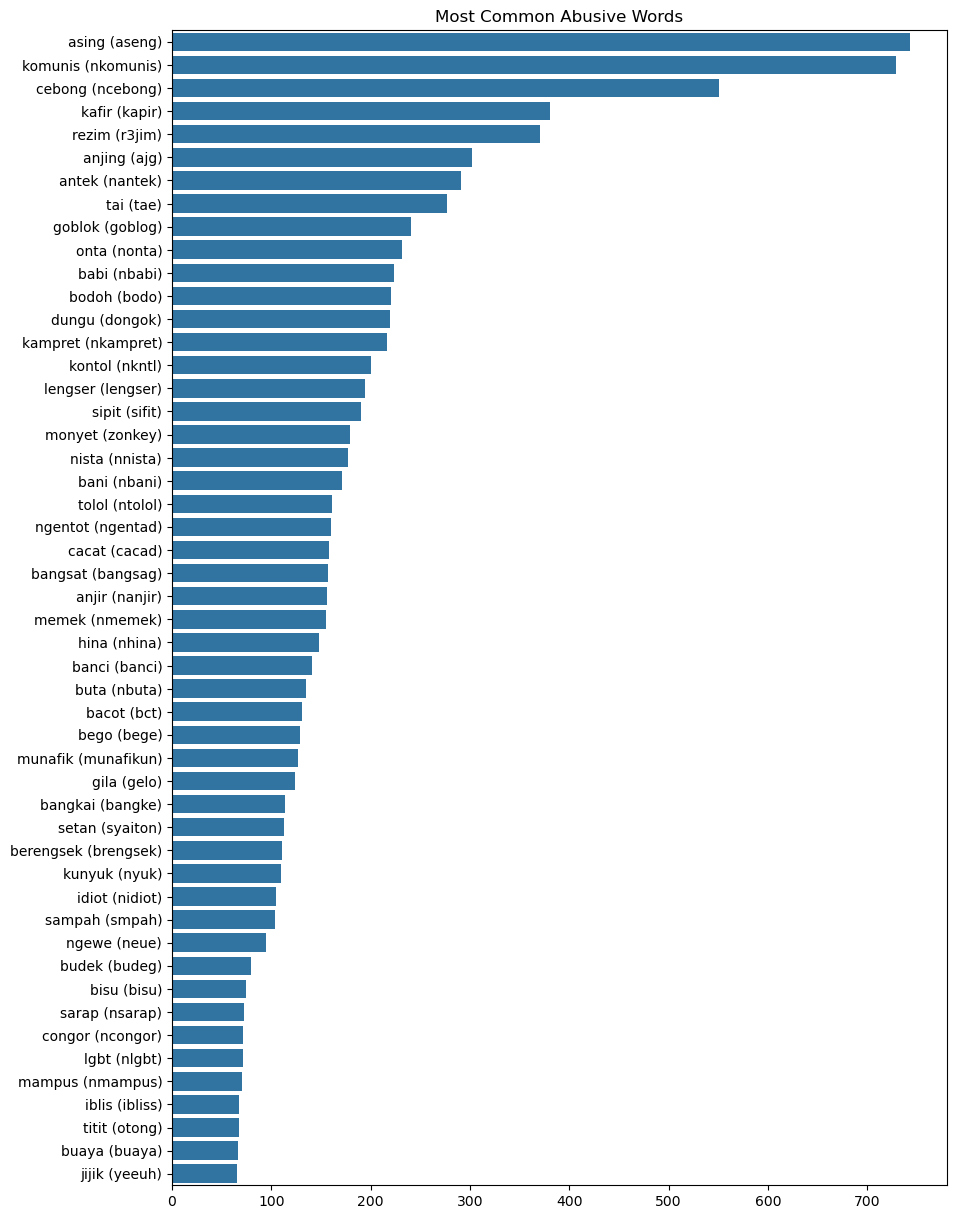

In [26]:
top_tweets = OrderedDict(counter_tweets)

show_only = 50
    
keys = list(top_tweets.keys())
vals = [top_tweets[k] for k in keys]

original_slang = []
for word in keys:
    if word in alay_dict[1].values:
        original_slang.append(alay_dict.loc[alay_dict[1] == word, 0].values[0])
    else:
        original_slang.append(word)
        
combined_words = [f'{keys[i]} ({original_slang[i]})' for i in range(len(keys))]

plt.figure(figsize=(10, 15))
sns.barplot(x=vals[:show_only], y=combined_words[:show_only])
plt.title('Most Common Abusive Words')
plt.show()

### WordCloud

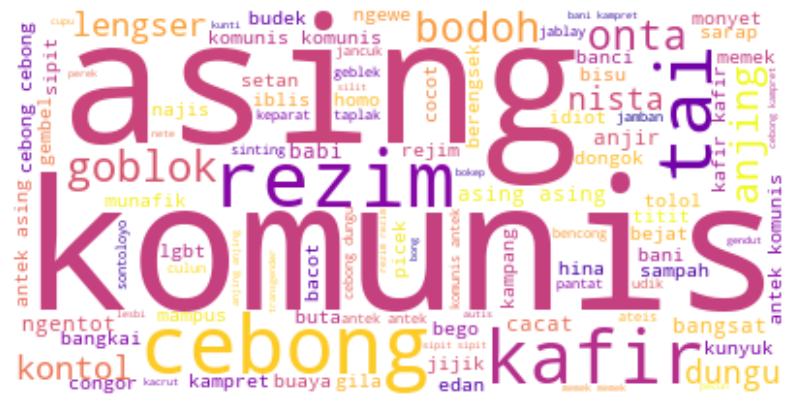

In [28]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 8))
tokens_ = ' '.join(tweets_corpus)
wc_ = WordCloud(max_words=100, background_color='white', max_font_size=100, colormap='plasma').generate(tokens_)
axes.axis("off")
axes.imshow(wc_, interpolation="bilinear")
plt.show()

### Label Distribution

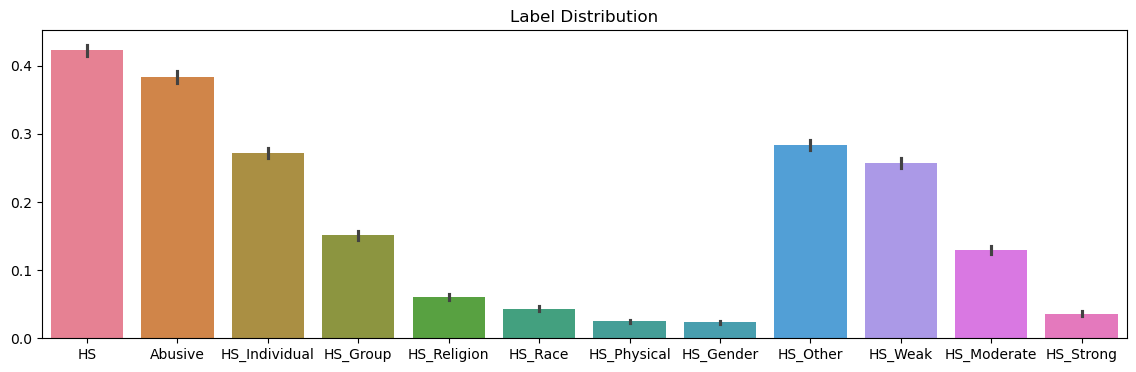

In [30]:
plt.figure(figsize=(14,4))
plt.title('Label Distribution')
sns.barplot(data)
plt.show()

In [31]:
### Count of each label

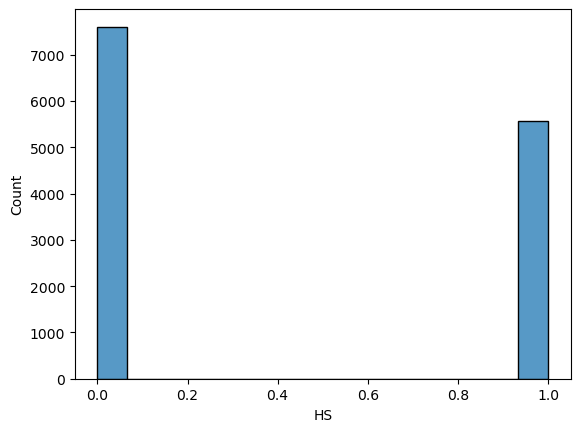

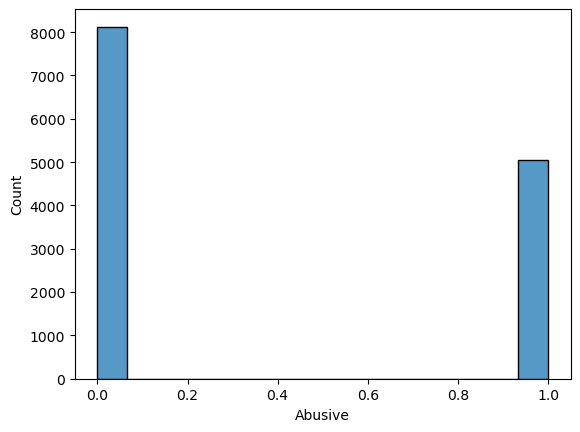

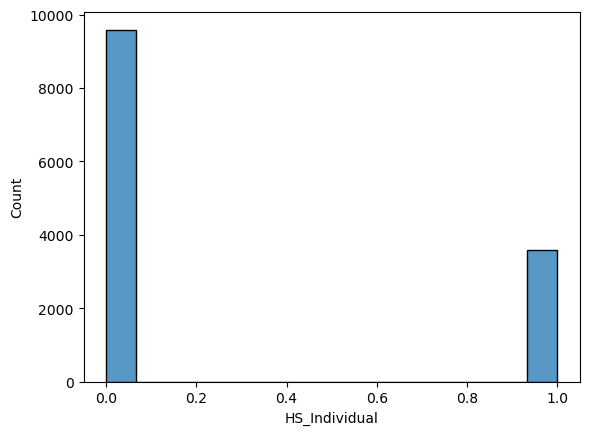

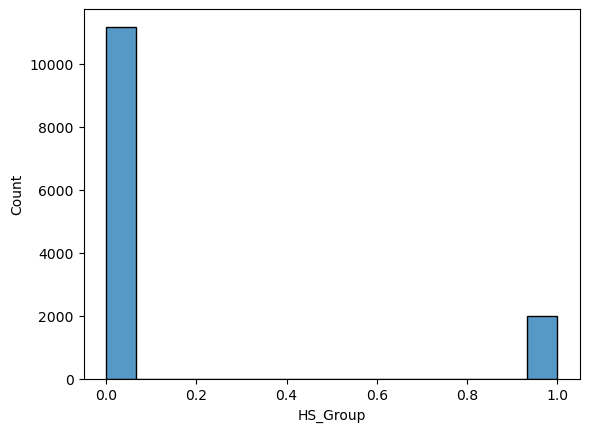

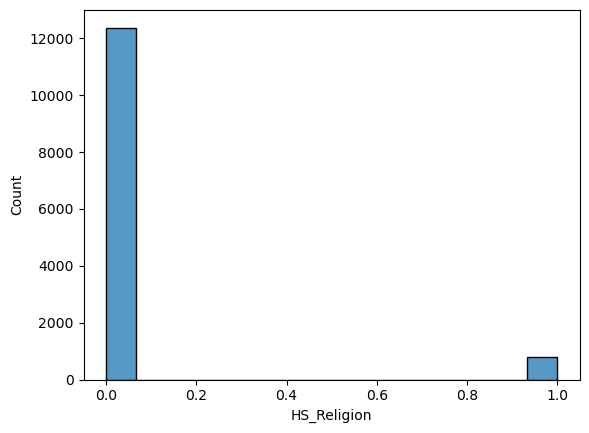

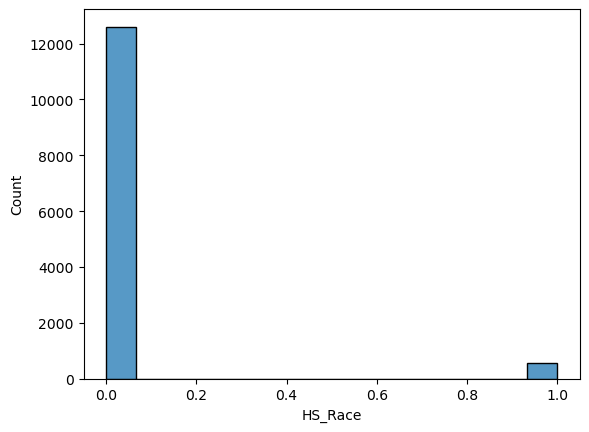

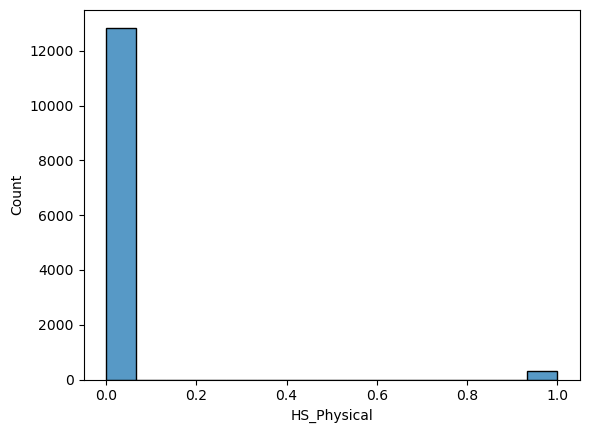

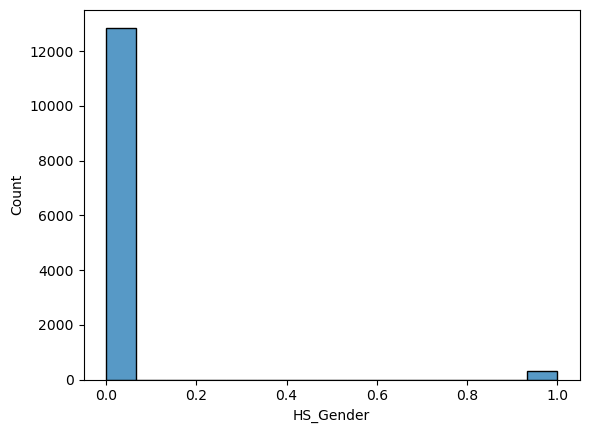

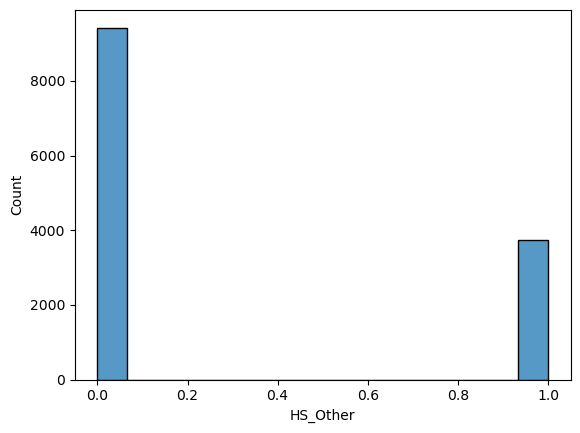

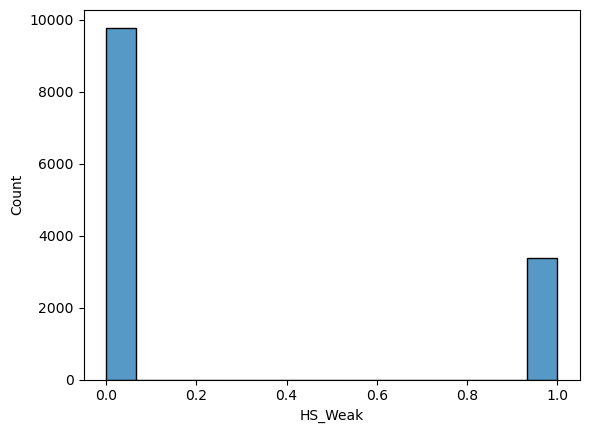

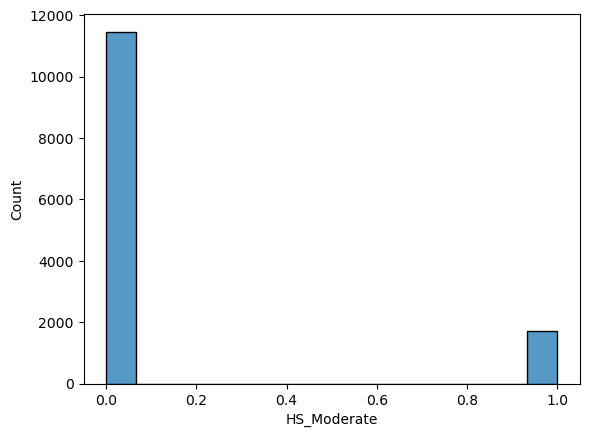

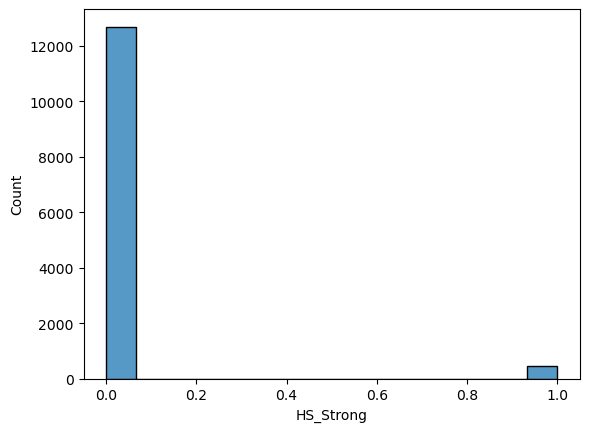

In [32]:
df1 = data.drop(['Tweet'], axis=1)
for i in df1.columns:
    j = 1
    plt.figure(j)
    sns.histplot(data=df1, x=i)
    plt.show()
    j = j+1

### Comments per label

In [34]:
df2 = df1.sum()
df2

HS               5561
Abusive          5043
HS_Individual    3575
HS_Group         1986
HS_Religion       793
HS_Race           566
HS_Physical       323
HS_Gender         306
HS_Other         3740
HS_Weak          3383
HS_Moderate      1705
HS_Strong         473
dtype: int64

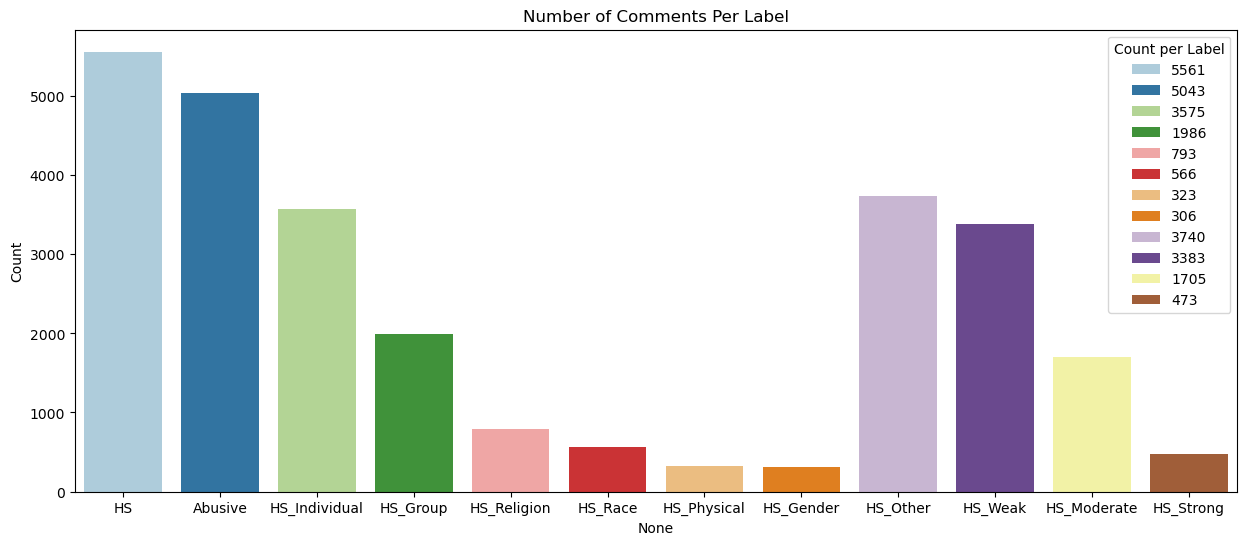

In [35]:
plt.figure(figsize=(15, 6))
sns.barplot(x=df2.index, y=df2.values, hue=df2.values.astype(str), dodge=False, palette='Paired')
plt.ylabel('Count')
plt.title("Number of Comments Per Label")
plt.legend(title='Count per Label', bbox_to_anchor=(1, 1))
plt.show()

## Splitting and Balancing Labels Dataset

Balancing based of comments count per label.

In [38]:
# label dataframe
df_HS = data[['Tweet', 'HS']]
df_Abusive = data[['Tweet', 'Abusive']]
df_Individual = data[['Tweet', 'HS_Individual']]
df_Group = data[['Tweet', 'HS_Group']]
df_Religion = data[['Tweet', 'HS_Religion']]
df_Race = data[['Tweet', 'HS_Race']]
df_Physical = data[['Tweet', 'HS_Physical']]
df_Gender = data[['Tweet', 'HS_Gender']]
df_Other = data[['Tweet', 'HS_Other']]
df_Weak = data[['Tweet', 'HS_Weak']]
df_Moderate = data[['Tweet', 'HS_Moderate']]
df_Strong = data[['Tweet', 'HS_Strong']]

In [39]:
# balancing df_HS 5561
df_HS_1 = df_HS[df_HS['HS'] == 1]
df_HS_0 = df_HS[df_HS['HS'] == 0].iloc[:5561]
df_HS_bal = pd.concat([df_HS_1, df_HS_0], axis=0)
df_HS_bal.shape

(11122, 2)

In [40]:
# balancing df_Abusive 5043
df_Abusive_1 = df_Abusive[df_Abusive['Abusive'] == 1]
df_Abusive_0 = df_Abusive[df_Abusive['Abusive'] == 0].iloc[:5043]
df_Abusive_bal = pd.concat([df_Abusive_1, df_Abusive_0], axis=0)
df_Abusive_bal.shape

(10086, 2)

In [41]:
# balancing df_Individual 3575
df_Individual_1 = df_Individual[df_Individual['HS_Individual'] == 1]
df_Individual_0 = df_Individual[df_Individual['HS_Individual'] == 0].iloc[:3575]
df_Individual_bal = pd.concat([df_Individual_1, df_Individual_0], axis=0)
df_Individual_bal.shape

(7150, 2)

In [42]:
# balancing df_Group 1986
df_Group_1 = df_Group[df_Group['HS_Group'] == 1]
df_Group_0 = df_Group[df_Group['HS_Group'] == 0].iloc[:1986]
df_Group_bal = pd.concat([df_Group_1, df_Group_0], axis=0)
df_Group_bal.shape

(3972, 2)

In [43]:
# balancing df_Religion 793
df_Religion_1 = df_Religion[df_Religion['HS_Religion'] == 1]
df_Religion_0 = df_Religion[df_Religion['HS_Religion'] == 0].iloc[:793]
df_Religion_bal = pd.concat([df_Religion_1, df_Religion_0], axis=0)
df_Religion_bal.shape

(1586, 2)

In [44]:
# balancing df_Race 566
df_Race_1 = df_Race[df_Race['HS_Race'] == 1]
df_Race_0 = df_Race[df_Race['HS_Race'] == 0].iloc[:566]
df_Race_bal = pd.concat([df_Race_1, df_Race_0], axis=0)
df_Race_bal.shape

(1132, 2)

In [45]:
# balancing df_Physical 323
df_Physical_1 = df_Physical[df_Physical['HS_Physical'] == 1]
df_Physical_0 = df_Physical[df_Physical['HS_Physical'] == 0].iloc[:323]
df_Physical_bal = pd.concat([df_Physical_1, df_Physical_0], axis=0)
df_Physical_bal.shape

(646, 2)

In [46]:
# balancing df_Gender 306
df_Gender_1 = df_Gender[df_Gender['HS_Gender'] == 1]
df_Gender_0 = df_Gender[df_Gender['HS_Gender'] == 0].iloc[:306]
df_Gender_bal = pd.concat([df_Gender_1, df_Gender_0], axis=0)
df_Gender_bal.shape

(612, 2)

In [47]:
# balancing df_Other 3740
df_Other_1 = df_Other[df_Other['HS_Other'] == 1]
df_Other_0 = df_Other[df_Other['HS_Other'] == 0].iloc[:3740]
df_Other_bal = pd.concat([df_Other_1, df_Other_0], axis=0)
df_Other_bal.shape

(7480, 2)

In [48]:
# balancing df_Weak 3383
df_Weak_1 = df_Weak[df_Weak['HS_Weak'] == 1]
df_Weak_0 = df_Weak[df_Weak['HS_Weak'] == 0].iloc[:3383]
df_Weak_bal = pd.concat([df_Weak_1, df_Weak_0], axis=0)
df_Weak_bal.shape

(6766, 2)

In [49]:
# balancing df_Moderate 1705
df_Moderate_1 = df_Moderate[df_Moderate['HS_Moderate'] == 1]
df_Moderate_0 = df_Moderate[df_Moderate['HS_Moderate'] == 0].iloc[:1705]
df_Moderate_bal = pd.concat([df_Moderate_1, df_Moderate_0], axis=0)
df_Moderate_bal.shape

(3410, 2)

In [50]:
# balancing df_Strong 473
df_Strong_1 = df_Strong[df_Strong['HS_Strong'] == 1]
df_Strong_0 = df_Strong[df_Strong['HS_Strong'] == 0].iloc[:473]
df_Strong_bal = pd.concat([df_Strong_1, df_Strong_0], axis=0)
df_Strong_bal.shape

(946, 2)

In [51]:
#label dataset
df_HS_bal.to_csv("DatasetsOutput/HS.csv")
df_Abusive_bal.to_csv("DatasetsOutput/Abusive.csv")
df_Individual_bal.to_csv("DatasetsOutput/Individual.csv")
df_Group_bal.to_csv("DatasetsOutput/Group.csv")
df_Religion_bal.to_csv("DatasetsOutput/Religion.csv")
df_Race_bal.to_csv("DatasetsOutput/Race.csv")
df_Physical_bal.to_csv("DatasetsOutput/Physical.csv")
df_Gender_bal.to_csv("DatasetsOutput/Gender.csv")
df_Other_bal.to_csv("DatasetsOutput/Other.csv")
df_Weak_bal.to_csv("DatasetsOutput/Weak.csv")
df_Moderate_bal.to_csv("DatasetsOutput/Moderate.csv")
df_Strong_bal.to_csv("DatasetsOutput/Strong.csv")

## Modelling

### TF-IDF Vectorizer, Bag of Words (BoW), N-grams, Count Vectorizer, Hashing Vectorizer

In [54]:
# TF-IDF Vectorizer, Bag of Words (BoW), N-grams, Count Vectorizer, Hashing Vectorizer
def vector_model(data, category, vectorizer, ngram):
    X = data['Tweet'].fillna(' ')
    Y = data[category]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    vector = vectorizer(ngram_range=(ngram), stop_words=id_stopword_dict['stopword'].tolist())

    X_train_scal = vector.fit_transform(X_train)
    X_test_scal = vector.transform(X_test)

        # Convert negative values to zero for HashingVectorizer
    if isinstance(vector, HashingVectorizer):
        X_train_scal[X_train_scal < 0] = 0
        X_test_scal[X_test_scal < 0] = 0
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scal, Y_train)
    Y_pred_knn = knn.predict(X_test_scal)
    print(f"Knn done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_knn)} ")
    print("\n----------------------------------------------------------------------")
    
    # logistic regression
    lr = LogisticRegression()
    lr.fit(X_train_scal, Y_train)
    Y_pred_lr = lr.predict(X_test_scal)
    print(f"\nLr done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_lr)} ")
    print("\n----------------------------------------------------------------------\n")

    # Support Vector Machine
    svm = SVC(kernel='rbf')
    svm.fit(X_train_scal, Y_train)
    Y_pred_svm = svm.predict(X_test_scal)
    print(f"\nsvm done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_svm)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Naive Bayes

    bnb = BernoulliNB()
    bnb.fit(X_train_scal, Y_train)
    Y_pred_bnb = bnb.predict(X_test_scal)
    print(f"\nbnb done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_bnb)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Decision Tree Classifier
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, random_state=42)
    dt.fit(X_train_scal, Y_train)
    Y_pred_dt = dt.predict(X_test_scal)
    print(f"\nDT done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_dt)} ")
    print("\n----------------------------------------------------------------------\n")

    # Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=105, min_samples_split=2, random_state=42)
    rf.fit(X_train_scal, Y_train)
    Y_pred_rf = rf.predict(X_test_scal)
    print(f"\nRF done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_rf)} ")
    print("\n----------------------------------------------------------------------\n")
    
    f1_scores = [round(f1_score(Y_pred_knn, Y_test), 2), round(f1_score(Y_pred_lr, Y_test), 2), round(f1_score(Y_pred_svm, Y_test), 2),
                 round(f1_score(Y_pred_bnb, Y_test), 2), round(f1_score(Y_pred_dt, Y_test), 2),
                 round(f1_score(Y_pred_rf, Y_test), 2)]
    print(f"F1_scores for {category} Are calculated")

    Scores = {f'F1_Score - {category}':f1_scores}
    Scores_data = pd.DataFrame(Scores, index=['KNN', 'Logistic Regression', 'SVM', 'Bernoulli NB', 'Decision Tree', 'Random Forest'])
    return Scores_data

### Word Embeddings

In [56]:
# Word Embeddings
def vector_modelW2V(data, category):
    X = data['Tweet'].fillna(' ')
    Y = data[category]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    # Tokenize the sentences
    X_train_tokens = [tweet.split() for tweet in X_train]
    X_test_tokens = [tweet.split() for tweet in X_test]

    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

    # Function to average Word2Vec vectors for a sentence
    def get_avg_word2vec(tokens_list, model, vector_size):
        vec = np.zeros(vector_size).reshape((1, vector_size))
        count = 0
        for word in tokens_list:
            if word in model.wv.index_to_key:
                vec += model.wv[word].reshape((1, vector_size))
                count += 1
        if count != 0:
            vec /= count
        return vec

    # Transform the training and testing data
    X_train_w2v = np.concatenate([get_avg_word2vec(tokens, w2v_model, 100) for tokens in X_train_tokens])
    X_test_w2v = np.concatenate([get_avg_word2vec(tokens, w2v_model, 100) for tokens in X_test_tokens])

    # Scale the data to be non-negative
    scaler = MinMaxScaler()
    X_train_w2v = scaler.fit_transform(X_train_w2v)
    X_test_w2v = scaler.transform(X_test_w2v)
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_w2v, Y_train)
    Y_pred_knn = knn.predict(X_test_w2v)
    print(f"Knn done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_knn)} ")
    print("\n----------------------------------------------------------------------")
    
    # logistic regression
    lr = LogisticRegression()
    lr.fit(X_train_w2v, Y_train)
    Y_pred_lr = lr.predict(X_test_w2v)
    print(f"\nLr done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_lr)} ")
    print("\n----------------------------------------------------------------------\n")

    # Support Vector Machine
    svm = SVC(kernel='rbf')
    svm.fit(X_train_w2v, Y_train)
    Y_pred_svm = svm.predict(X_test_w2v)
    print(f"\nsvm done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_svm)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(X_train_w2v, Y_train)
    Y_pred_bnb = bnb.predict(X_test_w2v)
    print(f"\nbnb done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_bnb)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Decision Tree Classifier
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, random_state=42)
    dt.fit(X_train_w2v, Y_train)
    Y_pred_dt = dt.predict(X_test_w2v)
    print(f"\nDT done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_dt)} ")
    print("\n----------------------------------------------------------------------\n")

    # Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=105, min_samples_split=2, random_state=42)
    rf.fit(X_train_w2v, Y_train)
    Y_pred_rf = rf.predict(X_test_w2v)
    print(f"\nRF done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_rf)} ")
    print("\n----------------------------------------------------------------------\n")
    
    f1_scores = [round(f1_score(Y_pred_knn, Y_test), 2), round(f1_score(Y_pred_lr, Y_test), 2), round(f1_score(Y_pred_svm, Y_test), 2),
                 round(f1_score(Y_pred_bnb, Y_test), 2), round(f1_score(Y_pred_dt, Y_test), 2), round(f1_score(Y_pred_rf, Y_test), 2)]
    print(f"F1_scores for {category} Are calculated")

    Scores = {f'F1_Score - {category}':f1_scores}
    Scores_data = pd.DataFrame(Scores, index=['KNN', 'Logistic Regression', 'SVM', 'Bernoulli NB', 'Decision Tree', 'Random Forest'])
    return Scores_data

### Doc2Vec

In [58]:
# Doc2Vec
def vector_modelDoc2Vec(data, category):
    # Ensure all values in 'Tweet' column are strings and fill missing values with an empty string
    data['Tweet'] = data['Tweet'].astype(str).fillna(' ')
    
    # Split the data
    X = data['Tweet']
    Y = data[category]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    
    # Doc2Vec model
    tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data['Tweet'])]
    max_epochs = 100
    vec_size = 20
    alpha = 0.025
    model_d2v = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm=1)
    model_d2v.build_vocab(tagged_data)
    model_d2v.train(tagged_data, total_examples=model_d2v.corpus_count, epochs=max_epochs)

    # Testing Doc2Vec
    X_train_d2v = np.array([model_d2v.infer_vector(word_tokenize(tweet.lower())) for tweet in data.loc[data.index.isin(X_train.index), 'Tweet']])
    X_test_d2v = np.array([model_d2v.infer_vector(word_tokenize(tweet.lower())) for tweet in data.loc[data.index.isin(X_test.index), 'Tweet']])

    #KNN
    knn_d2v = KNeighborsClassifier(n_neighbors=5)
    knn_d2v.fit(X_train_d2v, Y_train)
    Y_pred_knn_d2v = knn_d2v.predict(X_test_d2v)
    print(f"Doc2Vec KNN -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_knn_d2v)} ")
    print("\n----------------------------------------------------------------------")

    # logistic regression
    lr_d2v = LogisticRegression()
    lr_d2v.fit(X_train_d2v, Y_train)
    Y_pred_lr_d2v = lr_d2v.predict(X_test_d2v)
    print(f"\nDoc2Vec LR -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_lr_d2v)} ")
    print("\n----------------------------------------------------------------------\n")

    #Support vector Machine
    svm_d2v = SVC(kernel='rbf')
    svm_d2v.fit(X_train_d2v, Y_train)
    Y_pred_svm_d2v = svm_d2v.predict(X_test_d2v)
    print(f"\nDoc2Vec SVM -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_svm_d2v)} ")
    print("\n----------------------------------------------------------------------\n")

     # Naive Bayes
    bnb_d2v = BernoulliNB()
    bnb_d2v.fit(X_train_d2v, Y_train)
    Y_pred_bnb_d2v = bnb_d2v.predict(X_test_d2v)
    print(f"\nbnb done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_bnb_d2v)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Decision Tree Classifier
    dt_d2v = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, random_state=42)
    dt_d2v.fit(X_train_d2v, Y_train)
    Y_pred_dt_d2v = dt_d2v.predict(X_test_d2v)
    print(f"\nDT done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_dt_d2v)} ")
    print("\n----------------------------------------------------------------------\n")

    # Random Forest Classifier
    rf_d2v = RandomForestClassifier(n_estimators=105, min_samples_split=2, random_state=42)
    rf_d2v.fit(X_train_d2v, Y_train)
    Y_pred_rf_d2v = rf_d2v.predict(X_test_d2v)
    print(f"\nRF done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_rf_d2v)} ")
    print("\n----------------------------------------------------------------------\n")

    f1_scores = [round(f1_score(Y_pred_knn_d2v, Y_test), 2), round(f1_score(Y_pred_lr_d2v, Y_test), 2), round(f1_score(Y_pred_svm_d2v, Y_test), 2),
                 round(f1_score(Y_pred_bnb_d2v, Y_test), 2), round(f1_score(Y_pred_dt_d2v, Y_test), 2), round(f1_score(Y_pred_rf_d2v, Y_test), 2)]
    print(f"F1_scores for {category} Are calculated")

    Scores = {f'F1_Score - {category}':f1_scores}
    Scores_data = pd.DataFrame(Scores, index=['KNN', 'Logistic Regression', 'SVM', 'Bernoulli NB', 'Decision Tree', 'Random Forest'])
    return Scores_data

### Latent Semantic Analysis (LSA)

In [60]:
# Latent Semantic Analysis (LSA)
def vector_modelLSA(data, category):
    # Ensure all values in 'Tweet' column are strings and fill missing values with an empty string
    data['Tweet'] = data['Tweet'].astype(str).fillna(' ')
    
    # Split the data
    X = data['Tweet']
    Y = data[category]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    # LSA
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(X)
    lsa = TruncatedSVD(n_components=100, random_state=42)
    X_lsa = lsa.fit_transform(X_tfidf)

    # Split the transformed data
    X_train_lsa = X_lsa[:len(X_train)]
    X_test_lsa = X_lsa[len(X_train):]

    # KNN
    knn_lsa = KNeighborsClassifier(n_neighbors=5)
    knn_lsa.fit(X_train_lsa, Y_train)
    Y_pred_knn_lsa = knn_lsa.predict(X_test_lsa)
    print(f"LSA KNN -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_knn_lsa)} ")
    print("\n----------------------------------------------------------------------")

    # Logistic Regression
    lr_lsa = LogisticRegression()
    lr_lsa.fit(X_train_lsa, Y_train)
    Y_pred_lr_lsa = lr_lsa.predict(X_test_lsa)
    print(f"\nLSA LR -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_lr_lsa)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Support Vector Machine
    svm_lsa = SVC(kernel='rbf')
    svm_lsa.fit(X_train_lsa, Y_train)
    Y_pred_svm_lsa = svm_lsa.predict(X_test_lsa)
    print(f"\nLSA SVM -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_svm_lsa)} ")
    print("\n----------------------------------------------------------------------\n")

     # Naive Bayes
    bnb_lsa = BernoulliNB()
    bnb_lsa.fit(X_train_lsa, Y_train)
    Y_pred_bnb_lsa = bnb_lsa.predict(X_test_lsa)
    print(f"\nbnb done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_bnb_lsa)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Decision Tree Classifier
    dt_lsa = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, random_state=42)
    dt_lsa.fit(X_train_lsa, Y_train)
    Y_pred_dt_lsa = dt_lsa.predict(X_test_lsa)
    print(f"\nDT done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_dt_lsa)} ")
    print("\n----------------------------------------------------------------------\n")

    # Random Forest Classifier
    rf_lsa = RandomForestClassifier(n_estimators=105, min_samples_split=2, random_state=42)
    rf_lsa.fit(X_train_lsa, Y_train)
    Y_pred_rf_lsa = rf_lsa.predict(X_test_lsa)
    print(f"\nRF done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_rf_lsa)} ")
    print("\n----------------------------------------------------------------------\n")
    
    f1_scores = [round(f1_score(Y_pred_knn_lsa, Y_test), 2), round(f1_score(Y_pred_lr_lsa, Y_test), 2), round(f1_score(Y_pred_svm_lsa, Y_test), 2),
                 round(f1_score(Y_pred_bnb_lsa, Y_test), 2), round(f1_score(Y_pred_dt_lsa, Y_test), 2), round(f1_score(Y_pred_rf_lsa, Y_test), 2)]
    print(f"F1_scores for {category} Are calculated")

    Scores = {f'F1_Score - {category}':f1_scores}
    Scores_data = pd.DataFrame(Scores, index=['KNN', 'Logistic Regression', 'SVM', 'Bernoulli NB', 'Decision Tree', 'Random Forest'])
    return Scores_data

### Latent Dirichlet Allocation (LDA)

In [62]:
# Latent Dirichlet Allocation (LDA)
def vector_modelLDA(data, category):
    # Ensure all values in 'Tweet' column are strings and fill missing values with an empty string
    data['Tweet'] = data['Tweet'].astype(str).fillna(' ')
    
    # Split the data
    X = data['Tweet']
    Y = data[category]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    # LDA
    count_vectorizer = CountVectorizer()
    X_count = count_vectorizer.fit_transform(X)
    lda = LatentDirichletAllocation(n_components=100, random_state=42)
    X_lda = lda.fit_transform(X_count)

    # Split the transformed data
    X_train_lda = X_lda[:len(X_train)]
    X_test_lda = X_lda[len(X_train):]

    # KNN
    knn_lda = KNeighborsClassifier(n_neighbors=5)
    knn_lda.fit(X_train_lda, Y_train)
    Y_pred_knn_lda = knn_lda.predict(X_test_lda)
    print(f"LDA KNN -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_knn_lda)} ")
    print("\n----------------------------------------------------------------------")

    # Logistic Regression
    lr_lda = LogisticRegression()
    lr_lda.fit(X_train_lda, Y_train)
    Y_pred_lr_lda = lr_lda.predict(X_test_lda)
    print(f"\nLDA LR -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_lr_lda)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Support Vector Machine
    svm_lda = SVC(kernel='rbf')
    svm_lda.fit(X_train_lda, Y_train)
    Y_pred_svm_lda = svm_lda.predict(X_test_lda)
    print(f"\nLDA SVM -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_svm_lda)} ")
    print("\n----------------------------------------------------------------------\n")

    # Naive Bayes
    bnb_lda = BernoulliNB()
    bnb_lda.fit(X_train_lda, Y_train)
    Y_pred_bnb_lda = bnb_lda.predict(X_test_lda)
    print(f"\nbnb done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_bnb_lda)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Decision Tree Classifier
    dt_lda = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, random_state=42)
    dt_lda.fit(X_train_lda, Y_train)
    Y_pred_dt_lda = dt_lda.predict(X_test_lda)
    print(f"\nDT done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_dt_lda)} ")
    print("\n----------------------------------------------------------------------\n")

    # Random Forest Classifier
    rf_lda = RandomForestClassifier(n_estimators=105, min_samples_split=2, random_state=42)
    rf_lda.fit(X_train_lda, Y_train)
    Y_pred_rf_lda = rf_lda.predict(X_test_lda)
    print(f"\nRF done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_rf_lda)} ")
    print("\n----------------------------------------------------------------------\n")
    
    f1_scores = [round(f1_score(Y_test, Y_pred_knn_lda), 2), round(f1_score(Y_test, Y_pred_lr_lda), 2), round(f1_score(Y_test, Y_pred_svm_lda), 2),
                 round(f1_score(Y_test, Y_pred_bnb_lda), 2), round(f1_score(Y_test, Y_pred_dt_lda), 2), round(f1_score(Y_test, Y_pred_rf_lda), 2)]
    print(f"F1_scores for {category} Are calculated")

    Scores = {f'F1_Score - {category}':f1_scores}
    Scores_data = pd.DataFrame(Scores, index=['KNN', 'Logistic Regression', 'SVM', 'Bernoulli NB', 'Decision Tree', 'Random Forest'])
    return Scores_data

### Principal Component Analysis (PCA)

In [64]:
# Principal Component Analysis (PCA)
def vector_modelPCA(data, category):
    # Ensure all values in 'Tweet' column are strings and fill missing values with an empty string
    data['Tweet'] = data['Tweet'].astype(str).fillna(' ')
    
    # Split the data
    X = data['Tweet']
    Y = data[category]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    # PCA
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(X)
    pca = PCA(n_components=100, random_state=42)
    X_pca = pca.fit_transform(X_tfidf.toarray())

    # Split the transformed data
    X_train_pca = X_pca[:len(X_train)]
    X_test_pca = X_pca[len(X_train):]

    # KNN
    knn_pca = KNeighborsClassifier(n_neighbors=5)
    knn_pca.fit(X_train_pca, Y_train)
    Y_pred_knn_pca = knn_pca.predict(X_test_pca)
    print(f"PCA KNN -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_knn_pca)} ")
    print("\n----------------------------------------------------------------------")

    # Logistic Regression
    lr_pca = LogisticRegression()
    lr_pca.fit(X_train_pca, Y_train)
    Y_pred_lr_pca = lr_pca.predict(X_test_pca)
    print(f"\nPCA LR -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_lr_pca)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Support Vector Machine
    svm_pca = SVC(kernel='rbf')
    svm_pca.fit(X_train_pca, Y_train)
    Y_pred_svm_pca = svm_pca.predict(X_test_pca)
    print(f"\nPCA SVM -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_svm_pca)} ")
    print("\n----------------------------------------------------------------------\n")

    # Naive Bayes
    bnb_pca = BernoulliNB()
    bnb_pca.fit(X_train_pca, Y_train)
    Y_pred_bnb_pca = bnb_pca.predict(X_test_pca)
    print(f"\nbnb done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_bnb_pca)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Decision Tree Classifier
    dt_pca = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, random_state=42)
    dt_pca.fit(X_train_pca, Y_train)
    Y_pred_dt_pca = dt_pca.predict(X_test_pca)
    print(f"\nDT done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_dt_pca)} ")
    print("\n----------------------------------------------------------------------\n")

    # Random Forest Classifier
    rf_pca = RandomForestClassifier(n_estimators=105, min_samples_split=2, random_state=42)
    rf_pca.fit(X_train_pca, Y_train)
    Y_pred_rf_pca = rf_pca.predict(X_test_pca)
    print(f"\nRF done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_rf_pca)} ")
    print("\n----------------------------------------------------------------------\n")
    
    f1_scores = [round(f1_score(Y_test, Y_pred_knn_pca), 2), round(f1_score(Y_test, Y_pred_lr_pca), 2), round(f1_score(Y_test, Y_pred_svm_pca), 2),
                 round(f1_score(Y_test, Y_pred_bnb_pca), 2), round(f1_score(Y_test, Y_pred_dt_pca), 2), round(f1_score(Y_test, Y_pred_rf_pca), 2)]
    print(f"F1_scores for {category} Are calculated")

    Scores = {f'F1_Score - {category}':f1_scores}
    Scores_data = pd.DataFrame(Scores, index=['KNN', 'Logistic Regression', 'SVM', 'Bernoulli NB', 'Decision Tree', 'Random Forest'])
    return Scores_data

### Non-Negative Matrix Factorization (NMF)

In [66]:
# Non-Negative Matrix Factorization (NMF)
def vector_modelNMF(data, category):
    # Ensure all values in 'Tweet' column are strings and fill missing values with an empty string
    data['Tweet'] = data['Tweet'].astype(str).fillna(' ')
    
    # Split the data
    X = data['Tweet']
    Y = data[category]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    # NMF
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(X)
    nmf = NMF(n_components=100, random_state=42)
    X_nmf = nmf.fit_transform(X_tfidf)

    # Split the transformed data
    X_train_nmf = X_nmf[:len(X_train)]
    X_test_nmf = X_nmf[len(X_train):]

    # KNN
    knn_nmf = KNeighborsClassifier(n_neighbors=5)
    knn_nmf.fit(X_train_nmf, Y_train)
    Y_pred_knn_nmf = knn_nmf.predict(X_test_nmf)
    print(f"NMF KNN -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_knn_nmf)} ")
    print("\n----------------------------------------------------------------------")

    # Logistic Regression
    lr_nmf = LogisticRegression()
    lr_nmf.fit(X_train_nmf, Y_train)
    Y_pred_lr_nmf = lr_nmf.predict(X_test_nmf)
    print(f"\nNMF LR -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_lr_nmf)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Support Vector Machine
    svm_nmf = SVC(kernel='rbf')
    svm_nmf.fit(X_train_nmf, Y_train)
    Y_pred_svm_nmf = svm_nmf.predict(X_test_nmf)
    print(f"\nNMF SVM -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_svm_nmf)} ")
    print("\n----------------------------------------------------------------------\n")

    # Naive Bayes
    bnb_nmf = BernoulliNB()
    bnb_nmf.fit(X_train_nmf, Y_train)
    Y_pred_bnb_nmf = bnb_nmf.predict(X_test_nmf)
    print(f"\nbnb done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_bnb_nmf)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Decision Tree Classifier
    dt_nmf = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, random_state=42)
    dt_nmf.fit(X_train_nmf, Y_train)
    Y_pred_dt_nmf = dt_nmf.predict(X_test_nmf)
    print(f"\nDT done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_dt_nmf)} ")
    print("\n----------------------------------------------------------------------\n")

    # Random Forest Classifier
    rf_nmf = RandomForestClassifier(n_estimators=105, min_samples_split=2, random_state=42)
    rf_nmf.fit(X_train_nmf, Y_train)
    Y_pred_rf_nmf = rf_nmf.predict(X_test_nmf)
    print(f"\nRF done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_rf_nmf)} ")
    print("\n----------------------------------------------------------------------\n")
    
    f1_scores = [round(f1_score(Y_test, Y_pred_knn_nmf), 2), round(f1_score(Y_test, Y_pred_lr_nmf), 2), round(f1_score(Y_test, Y_pred_svm_nmf), 2),
                 round(f1_score(Y_test, Y_pred_bnb_nmf), 2), round(f1_score(Y_test, Y_pred_dt_nmf), 2), round(f1_score(Y_test, Y_pred_rf_nmf), 2)]
    print(f"F1_scores for {category} Are calculated")

    Scores = {f'F1_Score - {category}': f1_scores}
    Scores_data = pd.DataFrame(Scores, index=['KNN', 'Logistic Regression', 'SVM', 'Bernoulli NB', 'Decision Tree', 'Random Forest'])
    return Scores_data

## Model Evaluation

### Score for HS

#### 0. TfidfVectorizer

In [70]:
# TfidfVectorizer
data_HS = pd.read_csv('DatasetsOutput/HS.csv')
result_HS = vector_model(data_HS, 'HS', TfidfVectorizer, (1,1))
result_HS

Knn done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.56      0.88      0.68      1664
           1       0.73      0.30      0.43      1673

    accuracy                           0.59      3337
   macro avg       0.64      0.59      0.56      3337
weighted avg       0.64      0.59      0.56      3337
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.80      0.83      0.82      1664
           1       0.83      0.79      0.81      1673

    accuracy                           0.81      3337
   macro avg       0.81      0.81      0.81      3337
weighted avg       0.81      0.81      0.81      3337
 

----------------------------------------------------------------------


svm done -> It's classification report for HS 
               precision    recall  f1-score   support


,F1_Score - HS
KNN,0.43
Logistic Regression,0.81
SVM,0.82
Bernoulli NB,0.81
Decision Tree,0.78
Random Forest,0.82


#### 1. Bag of Words (BoW)

In [72]:
# Bag of Words (BoW)
result_HS_BoW = vector_model(data_HS, 'HS', CountVectorizer, (1,2))
result_HS_BoW

Knn done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.61      0.75      0.68      1664
           1       0.68      0.53      0.60      1673

    accuracy                           0.64      3337
   macro avg       0.65      0.64      0.64      3337
weighted avg       0.65      0.64      0.64      3337
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      1664
           1       0.84      0.81      0.83      1673

    accuracy                           0.83      3337
   macro avg       0.83      0.83      0.83      3337
weighted avg       0.83      0.83      0.83      3337
 

----------------------------------------------------------------------


svm done -> It's classification report for HS 
               precision    recall  f1-score   support


,F1_Score - HS
KNN,0.60
Logistic Regression,0.83
SVM,0.81
Bernoulli NB,0.80
Decision Tree,0.78
Random Forest,0.81


#### 2. Words2vec

In [74]:
# Words2vec
result_HS_Words2vec = vector_modelW2V(data_HS, 'HS')
result_HS_Words2vec

Knn done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.63      0.64      0.64      1664
           1       0.64      0.62      0.63      1673

    accuracy                           0.63      3337
   macro avg       0.63      0.63      0.63      3337
weighted avg       0.63      0.63      0.63      3337
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.65      0.68      0.66      1664
           1       0.66      0.63      0.65      1673

    accuracy                           0.66      3337
   macro avg       0.66      0.66      0.66      3337
weighted avg       0.66      0.66      0.66      3337
 

----------------------------------------------------------------------


svm done -> It's classification report for HS 
               precision    recall  f1-score   support


,F1_Score - HS
KNN,0.63
Logistic Regression,0.65
SVM,0.64
Bernoulli NB,0.67
Decision Tree,0.62
Random Forest,0.68


#### 3. Doc2vec

In [76]:
# Doc2vec
result_HS_Doc2vec = vector_modelDoc2Vec(data_HS, 'HS')
result_HS_Doc2vec

Doc2Vec KNN -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.50      0.52      0.51      1664
           1       0.50      0.48      0.49      1673

    accuracy                           0.50      3337
   macro avg       0.50      0.50      0.50      3337
weighted avg       0.50      0.50      0.50      3337
 

----------------------------------------------------------------------

Doc2Vec LR -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.51      0.53      0.52      1664
           1       0.51      0.49      0.50      1673

    accuracy                           0.51      3337
   macro avg       0.51      0.51      0.51      3337
weighted avg       0.51      0.51      0.51      3337
 

----------------------------------------------------------------------


Doc2Vec SVM -> It's classification report for HS 
               precision    recall  f1-score  

,F1_Score - HS
KNN,0.49
Logistic Regression,0.50
SVM,0.42
Bernoulli NB,0.49
Decision Tree,0.50
Random Forest,0.48


#### 4. Latent Semantic Analysis (LSA)

In [78]:
# Latent Semantic Analysis (LSA)
result_HS_LSA = vector_modelLSA(data_HS, 'HS')
result_HS_LSA

LSA KNN -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.51      0.54      0.52      1664
           1       0.51      0.48      0.50      1673

    accuracy                           0.51      3337
   macro avg       0.51      0.51      0.51      3337
weighted avg       0.51      0.51      0.51      3337
 

----------------------------------------------------------------------

LSA LR -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.50      0.68      0.58      1664
           1       0.51      0.33      0.40      1673

    accuracy                           0.50      3337
   macro avg       0.50      0.50      0.49      3337
weighted avg       0.50      0.50      0.49      3337
 

----------------------------------------------------------------------


LSA SVM -> It's classification report for HS 
               precision    recall  f1-score   support

  

,F1_Score - HS
KNN,0.50
Logistic Regression,0.40
SVM,0.38
Bernoulli NB,0.45
Decision Tree,0.49
Random Forest,0.48


#### 5. Latent Dirichlet Allocation (LDA)

In [80]:
# Latent Dirichlet Allocation (LDA)
result_HS_LDA = vector_modelLDA(data_HS, 'HS')
result_HS_LDA

LDA KNN -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.49      0.51      0.50      1664
           1       0.50      0.48      0.49      1673

    accuracy                           0.49      3337
   macro avg       0.49      0.49      0.49      3337
weighted avg       0.49      0.49      0.49      3337
 

----------------------------------------------------------------------

LDA LR -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.50      0.52      0.51      1664
           1       0.51      0.49      0.50      1673

    accuracy                           0.51      3337
   macro avg       0.51      0.51      0.51      3337
weighted avg       0.51      0.51      0.51      3337
 

----------------------------------------------------------------------


LDA SVM -> It's classification report for HS 
               precision    recall  f1-score   support

  

,F1_Score - HS
KNN,0.49
Logistic Regression,0.50
SVM,0.50
Bernoulli NB,0.00
Decision Tree,0.49
Random Forest,0.50


#### 6. Principal Component Analysis (PCA)

In [82]:
# Principal Component Analysis (PCA)
result_HS_PCA = vector_modelPCA(data_HS, 'HS')
result_HS_PCA

PCA KNN -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.51      0.54      0.53      1664
           1       0.52      0.49      0.50      1673

    accuracy                           0.51      3337
   macro avg       0.51      0.51      0.51      3337
weighted avg       0.51      0.51      0.51      3337
 

----------------------------------------------------------------------

PCA LR -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.50      0.67      0.57      1664
           1       0.50      0.33      0.40      1673

    accuracy                           0.50      3337
   macro avg       0.50      0.50      0.49      3337
weighted avg       0.50      0.50      0.49      3337
 

----------------------------------------------------------------------


PCA SVM -> It's classification report for HS 
               precision    recall  f1-score   support

  

,F1_Score - HS
KNN,0.50
Logistic Regression,0.40
SVM,0.38
Bernoulli NB,0.44
Decision Tree,0.51
Random Forest,0.48


#### 7. N-grams

In [84]:
# bigrams
result_HS_bigrams = vector_model(data_HS, 'HS', CountVectorizer, (1,2))
result_HS_bigrams

Knn done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.63      0.76      0.69      1664
           1       0.70      0.56      0.62      1673

    accuracy                           0.66      3337
   macro avg       0.66      0.66      0.66      3337
weighted avg       0.66      0.66      0.66      3337
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      1664
           1       0.84      0.81      0.83      1673

    accuracy                           0.83      3337
   macro avg       0.83      0.83      0.83      3337
weighted avg       0.83      0.83      0.83      3337
 

----------------------------------------------------------------------


svm done -> It's classification report for HS 
               precision    recall  f1-score   support


,F1_Score - HS
KNN,0.62
Logistic Regression,0.83
SVM,0.81
Bernoulli NB,0.80
Decision Tree,0.78
Random Forest,0.81


In [85]:
# trigrams
result_HS_trigrams = vector_model(data_HS, 'HS', CountVectorizer, (1,3))
result_HS_trigrams

Knn done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.61      0.75      0.67      1664
           1       0.68      0.53      0.59      1673

    accuracy                           0.64      3337
   macro avg       0.64      0.64      0.63      3337
weighted avg       0.64      0.64      0.63      3337
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      1664
           1       0.84      0.81      0.83      1673

    accuracy                           0.83      3337
   macro avg       0.83      0.83      0.83      3337
weighted avg       0.83      0.83      0.83      3337
 

----------------------------------------------------------------------


svm done -> It's classification report for HS 
               precision    recall  f1-score   support


,F1_Score - HS
KNN,0.59
Logistic Regression,0.83
SVM,0.81
Bernoulli NB,0.77
Decision Tree,0.78
Random Forest,0.80


#### 8. Non-Negative Matrix Factorization (NMF)

In [87]:
# Non-Negative Matrix Factorization (NMF)
result_HS_NMF = vector_modelNMF(data_HS, 'HS')
result_HS_NMF

NMF KNN -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.51      0.56      0.53      1664
           1       0.51      0.46      0.48      1673

    accuracy                           0.51      3337
   macro avg       0.51      0.51      0.51      3337
weighted avg       0.51      0.51      0.51      3337
 

----------------------------------------------------------------------

NMF LR -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.50      0.70      0.58      1664
           1       0.50      0.29      0.37      1673

    accuracy                           0.50      3337
   macro avg       0.50      0.50      0.48      3337
weighted avg       0.50      0.50      0.48      3337
 

----------------------------------------------------------------------


NMF SVM -> It's classification report for HS 
               precision    recall  f1-score   support

  

,F1_Score - HS
KNN,0.48
Logistic Regression,0.37
SVM,0.37
Bernoulli NB,0.48
Decision Tree,0.48
Random Forest,0.48


#### 9. Count Vectorizer

In [89]:
# Count Vectorizer
result_HS_Count = vector_model(data_HS, 'HS', CountVectorizer, (1,1))
result_HS_Count

Knn done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.71      0.73      0.72      1664
           1       0.72      0.70      0.71      1673

    accuracy                           0.72      3337
   macro avg       0.72      0.72      0.72      3337
weighted avg       0.72      0.72      0.72      3337
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      1664
           1       0.82      0.81      0.82      1673

    accuracy                           0.82      3337
   macro avg       0.82      0.82      0.82      3337
weighted avg       0.82      0.82      0.82      3337
 

----------------------------------------------------------------------


svm done -> It's classification report for HS 
               precision    recall  f1-score   support


,F1_Score - HS
KNN,0.71
Logistic Regression,0.82
SVM,0.81
Bernoulli NB,0.81
Decision Tree,0.76
Random Forest,0.82


#### 10. Hashing Vectorizer

In [91]:
# HS Hashing Vectorizer
# result_HS_Hash = vector_model(data_HS, 'HS', HashingVectorizer, (1,1))
# result_HS_Hash

### Score for Abusive

#### 0. TfidfVectorizer

In [94]:
# TfidfVectorizer
data_Abusive = pd.read_csv('DatasetsOutput/Abusive.csv')
result_Abusive = vector_model(data_Abusive, 'Abusive', TfidfVectorizer, (1,1))
result_Abusive

Knn done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.56      0.92      0.69      1477
           1       0.80      0.31      0.44      1549

    accuracy                           0.61      3026
   macro avg       0.68      0.61      0.57      3026
weighted avg       0.68      0.61      0.57      3026
 

----------------------------------------------------------------------

Lr done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      1477
           1       0.90      0.89      0.90      1549

    accuracy                           0.90      3026
   macro avg       0.90      0.90      0.90      3026
weighted avg       0.90      0.90      0.90      3026
 

----------------------------------------------------------------------


svm done -> It's classification report for Abusive 
               precision    recall  f1-s

,F1_Score - Abusive
KNN,0.44
Logistic Regression,0.90
SVM,0.91
Bernoulli NB,0.85
Decision Tree,0.87
Random Forest,0.89


#### 1. Bag of Words (BoW)

In [96]:
# Bag of Words (BoW)
result_Abusive_BoW = vector_model(data_Abusive, 'Abusive', CountVectorizer, (1,2))
result_Abusive_BoW

Knn done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.65      0.83      0.73      1477
           1       0.78      0.57      0.66      1549

    accuracy                           0.70      3026
   macro avg       0.71      0.70      0.69      3026
weighted avg       0.72      0.70      0.69      3026
 

----------------------------------------------------------------------

Lr done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1477
           1       0.91      0.92      0.91      1549

    accuracy                           0.91      3026
   macro avg       0.91      0.91      0.91      3026
weighted avg       0.91      0.91      0.91      3026
 

----------------------------------------------------------------------


svm done -> It's classification report for Abusive 
               precision    recall  f1-s

,F1_Score - Abusive
KNN,0.66
Logistic Regression,0.91
SVM,0.88
Bernoulli NB,0.82
Decision Tree,0.89
Random Forest,0.88


#### 2. Words2vec

In [98]:
# Words2vec
result_Abusive_Words2vec = vector_modelW2V(data_Abusive, 'Abusive')
result_Abusive_Words2vec

Knn done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.70      0.75      0.73      1477
           1       0.75      0.70      0.72      1549

    accuracy                           0.72      3026
   macro avg       0.73      0.73      0.72      3026
weighted avg       0.73      0.72      0.72      3026
 

----------------------------------------------------------------------

Lr done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.74      0.70      0.72      1477
           1       0.73      0.77      0.75      1549

    accuracy                           0.74      3026
   macro avg       0.74      0.74      0.74      3026
weighted avg       0.74      0.74      0.74      3026
 

----------------------------------------------------------------------


svm done -> It's classification report for Abusive 
               precision    recall  f1-s

,F1_Score - Abusive
KNN,0.72
Logistic Regression,0.75
SVM,0.75
Bernoulli NB,0.68
Decision Tree,0.71
Random Forest,0.76


#### 3. Doc2vec

In [100]:
# Doc2vec
result_Abusive_Doc2vec = vector_modelDoc2Vec(data_Abusive, 'Abusive')
result_Abusive_Doc2vec

Doc2Vec KNN -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.50      0.52      0.51      1477
           1       0.53      0.51      0.52      1549

    accuracy                           0.51      3026
   macro avg       0.51      0.51      0.51      3026
weighted avg       0.51      0.51      0.51      3026
 

----------------------------------------------------------------------

Doc2Vec LR -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.50      0.66      0.56      1477
           1       0.53      0.37      0.43      1549

    accuracy                           0.51      3026
   macro avg       0.51      0.51      0.50      3026
weighted avg       0.51      0.51      0.50      3026
 

----------------------------------------------------------------------


Doc2Vec SVM -> It's classification report for Abusive 
               precision    rec

,F1_Score - Abusive
KNN,0.52
Logistic Regression,0.43
SVM,0.43
Bernoulli NB,0.44
Decision Tree,0.51
Random Forest,0.49


#### 4. Latent Semantic Analysis (LSA)

In [102]:
# Latent Semantic Analysis (LSA)
result_Abusive_LSA = vector_modelLSA(data_Abusive, 'Abusive')
result_Abusive_LSA

LSA KNN -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.49      0.48      0.48      1477
           1       0.51      0.52      0.52      1549

    accuracy                           0.50      3026
   macro avg       0.50      0.50      0.50      3026
weighted avg       0.50      0.50      0.50      3026
 

----------------------------------------------------------------------

LSA LR -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.47      0.47      0.47      1477
           1       0.49      0.49      0.49      1549

    accuracy                           0.48      3026
   macro avg       0.48      0.48      0.48      3026
weighted avg       0.48      0.48      0.48      3026
 

----------------------------------------------------------------------


LSA SVM -> It's classification report for Abusive 
               precision    recall  f1-scor

,F1_Score - Abusive
KNN,0.52
Logistic Regression,0.49
SVM,0.50
Bernoulli NB,0.49
Decision Tree,0.51
Random Forest,0.49


#### 5. Latent Dirichlet Allocation (LDA)

In [104]:
# Latent Dirichlet Allocation (LDA)
result_Abusive_LDA = vector_modelLDA(data_Abusive, 'Abusive')
result_Abusive_LDA

LDA KNN -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.49      0.53      0.51      1477
           1       0.52      0.48      0.50      1549

    accuracy                           0.50      3026
   macro avg       0.51      0.51      0.50      3026
weighted avg       0.51      0.50      0.50      3026
 

----------------------------------------------------------------------

LDA LR -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.50      0.58      0.54      1477
           1       0.52      0.44      0.48      1549

    accuracy                           0.51      3026
   macro avg       0.51      0.51      0.51      3026
weighted avg       0.51      0.51      0.51      3026
 

----------------------------------------------------------------------


LDA SVM -> It's classification report for Abusive 
               precision    recall  f1-scor

,F1_Score - Abusive
KNN,0.50
Logistic Regression,0.48
SVM,0.48
Bernoulli NB,0.00
Decision Tree,0.51
Random Forest,0.49


#### 6. Principal Component Analysis (PCA)

In [106]:
# Latent Dirichlet Allocation (LDA)
result_Abusive_PCA = vector_modelPCA(data_Abusive, 'Abusive')
result_Abusive_PCA

PCA KNN -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.50      0.49      0.49      1477
           1       0.52      0.53      0.52      1549

    accuracy                           0.51      3026
   macro avg       0.51      0.51      0.51      3026
weighted avg       0.51      0.51      0.51      3026
 

----------------------------------------------------------------------

PCA LR -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.47      0.49      0.48      1477
           1       0.49      0.48      0.49      1549

    accuracy                           0.48      3026
   macro avg       0.48      0.48      0.48      3026
weighted avg       0.48      0.48      0.48      3026
 

----------------------------------------------------------------------


PCA SVM -> It's classification report for Abusive 
               precision    recall  f1-scor

,F1_Score - Abusive
KNN,0.52
Logistic Regression,0.49
SVM,0.50
Bernoulli NB,0.50
Decision Tree,0.50
Random Forest,0.50


#### 7. N-grams

In [108]:
result_Abusive_bigram = vector_model(data_Abusive, 'Abusive', CountVectorizer, (1,2))
result_Abusive_bigram

Knn done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.75      0.67      0.71      1477
           1       0.71      0.79      0.75      1549

    accuracy                           0.73      3026
   macro avg       0.73      0.73      0.73      3026
weighted avg       0.73      0.73      0.73      3026
 

----------------------------------------------------------------------

Lr done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1477
           1       0.91      0.92      0.91      1549

    accuracy                           0.91      3026
   macro avg       0.91      0.91      0.91      3026
weighted avg       0.91      0.91      0.91      3026
 

----------------------------------------------------------------------


svm done -> It's classification report for Abusive 
               precision    recall  f1-s

,F1_Score - Abusive
KNN,0.75
Logistic Regression,0.91
SVM,0.88
Bernoulli NB,0.82
Decision Tree,0.88
Random Forest,0.88


In [109]:
result_Abusive_trigram = vector_model(data_Abusive, 'Abusive', CountVectorizer, (1,3))
result_Abusive_trigram

Knn done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.73      0.65      0.69      1477
           1       0.70      0.77      0.73      1549

    accuracy                           0.71      3026
   macro avg       0.71      0.71      0.71      3026
weighted avg       0.71      0.71      0.71      3026
 

----------------------------------------------------------------------

Lr done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      1477
           1       0.90      0.91      0.91      1549

    accuracy                           0.91      3026
   macro avg       0.91      0.91      0.91      3026
weighted avg       0.91      0.91      0.91      3026
 

----------------------------------------------------------------------


svm done -> It's classification report for Abusive 
               precision    recall  f1-s

,F1_Score - Abusive
KNN,0.73
Logistic Regression,0.91
SVM,0.88
Bernoulli NB,0.79
Decision Tree,0.89
Random Forest,0.88


#### 8. Non-Negative Matrix Factorization (NMF)

In [111]:
# Non-Negative Matrix Factorization (NMF)
result_Abusive_NMF = vector_modelNMF(data_Abusive, 'Abusive')
result_Abusive_NMF

NMF KNN -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.48      0.48      0.48      1477
           1       0.51      0.51      0.51      1549

    accuracy                           0.50      3026
   macro avg       0.50      0.50      0.50      3026
weighted avg       0.50      0.50      0.50      3026
 

----------------------------------------------------------------------

NMF LR -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.47      0.61      0.53      1477
           1       0.48      0.35      0.40      1549

    accuracy                           0.47      3026
   macro avg       0.47      0.48      0.47      3026
weighted avg       0.48      0.47      0.46      3026
 

----------------------------------------------------------------------


NMF SVM -> It's classification report for Abusive 
               precision    recall  f1-scor

,F1_Score - Abusive
KNN,0.51
Logistic Regression,0.40
SVM,0.55
Bernoulli NB,0.53
Decision Tree,0.49
Random Forest,0.48


#### 9. Count Vectorizer

In [113]:
# Count Vectorizer
result_Abusive_Count = vector_model(data_Abusive, 'Abusive', CountVectorizer, (1,1))
result_Abusive_Count

Knn done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.82      0.72      0.77      1477
           1       0.76      0.85      0.80      1549

    accuracy                           0.79      3026
   macro avg       0.79      0.78      0.78      3026
weighted avg       0.79      0.79      0.79      3026
 

----------------------------------------------------------------------

Lr done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1477
           1       0.91      0.91      0.91      1549

    accuracy                           0.91      3026
   macro avg       0.91      0.91      0.91      3026
weighted avg       0.91      0.91      0.91      3026
 

----------------------------------------------------------------------


svm done -> It's classification report for Abusive 
               precision    recall  f1-s

,F1_Score - Abusive
KNN,0.80
Logistic Regression,0.91
SVM,0.89
Bernoulli NB,0.85
Decision Tree,0.89
Random Forest,0.90


#### 10. Hashing Vectorizer

In [115]:
# Count Vectorizer
# result_Abusive_Hash = vector_model(data_Abusive, 'Abusive', HashingVectorizer, (1,1))
# result_Abusive_Hash

### Score for HS_Individual

#### 0. TfidfVectorizer

In [118]:
# Individual
data_Individual = pd.read_csv('DatasetsOutput/Individual.csv')
result_Individual = vector_model(data_Individual, 'HS_Individual', TfidfVectorizer, (1,1))
result_Individual

Knn done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.54      0.78      0.64      1042
           1       0.65      0.38      0.48      1103

    accuracy                           0.58      2145
   macro avg       0.60      0.58      0.56      2145
weighted avg       0.60      0.58      0.56      2145
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.77      0.81      0.79      1042
           1       0.81      0.77      0.79      1103

    accuracy                           0.79      2145
   macro avg       0.79      0.79      0.79      2145
weighted avg       0.79      0.79      0.79      2145
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Individual 
               precisi

,F1_Score - HS_Individual
KNN,0.48
Logistic Regression,0.79
SVM,0.80
Bernoulli NB,0.78
Decision Tree,0.74
Random Forest,0.79


#### 1. Bag of Words (BoW)

In [120]:
# Bag of Words (BoW)
result_Individual_BoW = vector_model(data_Individual, 'HS_Individual', CountVectorizer, (1,2))
result_Individual_BoW

Knn done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.58      0.72      0.64      1042
           1       0.65      0.50      0.56      1103

    accuracy                           0.61      2145
   macro avg       0.61      0.61      0.60      2145
weighted avg       0.62      0.61      0.60      2145
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.80      0.79      0.79      1042
           1       0.80      0.82      0.81      1103

    accuracy                           0.80      2145
   macro avg       0.80      0.80      0.80      2145
weighted avg       0.80      0.80      0.80      2145
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Individual 
               precisi

,F1_Score - HS_Individual
KNN,0.56
Logistic Regression,0.81
SVM,0.80
Bernoulli NB,0.78
Decision Tree,0.74
Random Forest,0.79


#### 2. Words2vec

In [122]:
# Words2vec
result_Individual_Words2vec = vector_modelW2V(data_Individual, 'HS_Individual')
result_Individual_Words2vec

Knn done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.61      0.64      0.62      1042
           1       0.64      0.61      0.62      1103

    accuracy                           0.62      2145
   macro avg       0.62      0.62      0.62      2145
weighted avg       0.62      0.62      0.62      2145
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.61      0.67      0.64      1042
           1       0.66      0.60      0.62      1103

    accuracy                           0.63      2145
   macro avg       0.63      0.63      0.63      2145
weighted avg       0.63      0.63      0.63      2145
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Individual 
               precisi

,F1_Score - HS_Individual
KNN,0.62
Logistic Regression,0.62
SVM,0.64
Bernoulli NB,0.00
Decision Tree,0.59
Random Forest,0.67


#### 3. Doc2vec

In [124]:
# Doc2vec
result_Individual_Doc2vec = vector_modelDoc2Vec(data_Individual, 'HS_Individual')
result_Individual_Doc2vec

Doc2Vec KNN -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.48      0.49      0.49      1042
           1       0.51      0.50      0.50      1103

    accuracy                           0.50      2145
   macro avg       0.49      0.49      0.49      2145
weighted avg       0.50      0.50      0.50      2145
 

----------------------------------------------------------------------

Doc2Vec LR -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.49      0.60      0.54      1042
           1       0.52      0.41      0.46      1103

    accuracy                           0.51      2145
   macro avg       0.51      0.51      0.50      2145
weighted avg       0.51      0.51      0.50      2145
 

----------------------------------------------------------------------


Doc2Vec SVM -> It's classification report for HS_Individual 
             

,F1_Score - HS_Individual
KNN,0.50
Logistic Regression,0.46
SVM,0.52
Bernoulli NB,0.47
Decision Tree,0.48
Random Forest,0.48


#### 4. Latent Semantic Analysis (LSA)

In [126]:
# Latent Semantic Analysis (LSA)
result_Individual_LSA = vector_modelLSA(data_Individual, 'HS_Individual')
result_Individual_LSA

LSA KNN -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.50      0.52      0.51      1042
           1       0.53      0.51      0.52      1103

    accuracy                           0.52      2145
   macro avg       0.52      0.52      0.52      2145
weighted avg       0.52      0.52      0.52      2145
 

----------------------------------------------------------------------

LSA LR -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.50      0.55      0.52      1042
           1       0.53      0.47      0.50      1103

    accuracy                           0.51      2145
   macro avg       0.51      0.51      0.51      2145
weighted avg       0.51      0.51      0.51      2145
 

----------------------------------------------------------------------


LSA SVM -> It's classification report for HS_Individual 
               precision 

,F1_Score - HS_Individual
KNN,0.52
Logistic Regression,0.50
SVM,0.49
Bernoulli NB,0.50
Decision Tree,0.50
Random Forest,0.48


#### 5. Latent Dirichlet Allocation (LDA)

In [128]:
# Latent Semantic Analysis (LSA)
result_Individual_LDA = vector_modelLDA(data_Individual, 'HS_Individual')
result_Individual_LDA

LDA KNN -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.48      0.53      0.50      1042
           1       0.51      0.47      0.49      1103

    accuracy                           0.50      2145
   macro avg       0.50      0.50      0.50      2145
weighted avg       0.50      0.50      0.50      2145
 

----------------------------------------------------------------------

LDA LR -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.49      0.52      0.50      1042
           1       0.52      0.49      0.51      1103

    accuracy                           0.50      2145
   macro avg       0.51      0.51      0.50      2145
weighted avg       0.51      0.50      0.50      2145
 

----------------------------------------------------------------------


LDA SVM -> It's classification report for HS_Individual 
               precision 

,F1_Score - HS_Individual
KNN,0.49
Logistic Regression,0.51
SVM,0.51
Bernoulli NB,0.00
Decision Tree,0.52
Random Forest,0.50


#### 6. Principal Component Analysis (PCA)

In [130]:
# Principal Component Analysis (PCA)
result_Individual_PCA = vector_modelPCA(data_Individual, 'HS_Individual')
result_Individual_PCA

PCA KNN -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.50      0.52      0.51      1042
           1       0.53      0.51      0.52      1103

    accuracy                           0.51      2145
   macro avg       0.51      0.51      0.51      2145
weighted avg       0.51      0.51      0.51      2145
 

----------------------------------------------------------------------

PCA LR -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.49      0.54      0.51      1042
           1       0.52      0.46      0.49      1103

    accuracy                           0.50      2145
   macro avg       0.50      0.50      0.50      2145
weighted avg       0.50      0.50      0.50      2145
 

----------------------------------------------------------------------


PCA SVM -> It's classification report for HS_Individual 
               precision 

,F1_Score - HS_Individual
KNN,0.52
Logistic Regression,0.49
SVM,0.49
Bernoulli NB,0.52
Decision Tree,0.50
Random Forest,0.50


#### 7. N-grams

In [132]:
result_Individual_bigram = vector_model(data_Individual, 'HS_Individual', CountVectorizer, (1,2))
result_Individual_bigram

Knn done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.60      0.53      0.56      1042
           1       0.60      0.67      0.64      1103

    accuracy                           0.60      2145
   macro avg       0.60      0.60      0.60      2145
weighted avg       0.60      0.60      0.60      2145
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      1042
           1       0.80      0.82      0.81      1103

    accuracy                           0.80      2145
   macro avg       0.80      0.80      0.80      2145
weighted avg       0.80      0.80      0.80      2145
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Individual 
               precisi

,F1_Score - HS_Individual
KNN,0.64
Logistic Regression,0.81
SVM,0.80
Bernoulli NB,0.78
Decision Tree,0.74
Random Forest,0.80


In [133]:
result_Individual_trigram = vector_model(data_Individual, 'HS_Individual', CountVectorizer, (1,3))
result_Individual_trigram

Knn done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.59      0.50      0.54      1042
           1       0.59      0.68      0.63      1103

    accuracy                           0.59      2145
   macro avg       0.59      0.59      0.59      2145
weighted avg       0.59      0.59      0.59      2145
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.80      0.79      0.80      1042
           1       0.80      0.82      0.81      1103

    accuracy                           0.80      2145
   macro avg       0.80      0.80      0.80      2145
weighted avg       0.80      0.80      0.80      2145
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Individual 
               precisi

,F1_Score - HS_Individual
KNN,0.63
Logistic Regression,0.81
SVM,0.80
Bernoulli NB,0.76
Decision Tree,0.74
Random Forest,0.78


#### 8. Non-Negative Matrix Factorization (NMF)

In [135]:
# Non-Negative Matrix Factorization (NMF)
result_Individual_NMF = vector_modelNMF(data_Individual, 'HS_Individual')
result_Individual_NMF

NMF KNN -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.50      0.51      0.51      1042
           1       0.53      0.52      0.53      1103

    accuracy                           0.52      2145
   macro avg       0.52      0.52      0.52      2145
weighted avg       0.52      0.52      0.52      2145
 

----------------------------------------------------------------------

NMF LR -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.49      0.76      0.59      1042
           1       0.51      0.23      0.32      1103

    accuracy                           0.49      2145
   macro avg       0.50      0.50      0.46      2145
weighted avg       0.50      0.49      0.45      2145
 

----------------------------------------------------------------------


NMF SVM -> It's classification report for HS_Individual 
               precision 

,F1_Score - HS_Individual
KNN,0.53
Logistic Regression,0.32
SVM,0.45
Bernoulli NB,0.47
Decision Tree,0.51
Random Forest,0.48


#### 9. Count Vectorizer

In [137]:
# Count Vectorizer
result_Individual_Count = vector_model(data_Individual, 'HS_Individual', CountVectorizer, (1,1))
result_Individual_Count

Knn done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.67      0.58      0.62      1042
           1       0.65      0.74      0.69      1103

    accuracy                           0.66      2145
   macro avg       0.66      0.66      0.66      2145
weighted avg       0.66      0.66      0.66      2145
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.79      0.77      0.78      1042
           1       0.78      0.80      0.79      1103

    accuracy                           0.79      2145
   macro avg       0.79      0.79      0.79      2145
weighted avg       0.79      0.79      0.79      2145
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Individual 
               precisi

,F1_Score - HS_Individual
KNN,0.69
Logistic Regression,0.79
SVM,0.79
Bernoulli NB,0.78
Decision Tree,0.74
Random Forest,0.81


#### 10. Hashing Vectorizer

In [139]:
# Hashing Vectorizer
# result_Hashing_Count = vector_model(data_Individual, 'HS_Individual', HashingVectorizer, (1,1))
# result_Hashing_Count

### Score for HS_Group

#### 0. TfidfVectorizer

In [142]:
# Group
data_Group = pd.read_csv('DatasetsOutput/Group.csv')
result_Group = vector_model(data_Group, 'HS_Group', TfidfVectorizer, (1,1))
result_Group

Knn done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.52      0.99      0.68       578
           1       0.93      0.15      0.26       614

    accuracy                           0.56      1192
   macro avg       0.73      0.57      0.47      1192
weighted avg       0.73      0.56      0.47      1192
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.74      0.84      0.79       578
           1       0.83      0.73      0.78       614

    accuracy                           0.78      1192
   macro avg       0.79      0.78      0.78      1192
weighted avg       0.79      0.78      0.78      1192
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Group 
               precision    recall  f

,F1_Score - HS_Group
KNN,0.26
Logistic Regression,0.78
SVM,0.79
Bernoulli NB,0.80
Decision Tree,0.75
Random Forest,0.79


#### 1. Bag of Words (BoW)

In [144]:
# Bag of Words (BoW)
result_Group_BoW = vector_model(data_Group, 'HS_Group', CountVectorizer, (1,2))
result_Group_BoW

Knn done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.55      0.90      0.68       578
           1       0.76      0.29      0.42       614

    accuracy                           0.59      1192
   macro avg       0.65      0.60      0.55      1192
weighted avg       0.66      0.59      0.55      1192
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.77      0.87      0.81       578
           1       0.86      0.75      0.80       614

    accuracy                           0.81      1192
   macro avg       0.81      0.81      0.81      1192
weighted avg       0.81      0.81      0.81      1192
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Group 
               precision    recall  f

,F1_Score - HS_Group
KNN,0.42
Logistic Regression,0.80
SVM,0.76
Bernoulli NB,0.78
Decision Tree,0.75
Random Forest,0.78


#### 2. Words2vec

In [146]:
# Words2vec
result_Group_Words2vec = vector_modelW2V(data_Group, 'HS_Group')
result_Group_Words2vec


Knn done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.61      0.54      0.57       578
           1       0.61      0.67      0.64       614

    accuracy                           0.61      1192
   macro avg       0.61      0.61      0.60      1192
weighted avg       0.61      0.61      0.61      1192
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.63      0.66      0.65       578
           1       0.67      0.63      0.65       614

    accuracy                           0.65      1192
   macro avg       0.65      0.65      0.65      1192
weighted avg       0.65      0.65      0.65      1192
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Group 
               precision    recall  f

,F1_Score - HS_Group
KNN,0.64
Logistic Regression,0.65
SVM,0.66
Bernoulli NB,0.68
Decision Tree,0.60
Random Forest,0.66


#### 3. Doc2vec

In [148]:
# Doc2vec
result_Group_Doc2vec = vector_modelDoc2Vec(data_Group, 'HS_Group')
result_Group_Doc2vec

Doc2Vec KNN -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.48      0.46      0.47       578
           1       0.51      0.52      0.52       614

    accuracy                           0.49      1192
   macro avg       0.49      0.49      0.49      1192
weighted avg       0.49      0.49      0.49      1192
 

----------------------------------------------------------------------

Doc2Vec LR -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.46      0.57      0.51       578
           1       0.48      0.38      0.42       614

    accuracy                           0.47      1192
   macro avg       0.47      0.47      0.47      1192
weighted avg       0.47      0.47      0.47      1192
 

----------------------------------------------------------------------


Doc2Vec SVM -> It's classification report for HS_Group 
               precision    

,F1_Score - HS_Group
KNN,0.52
Logistic Regression,0.42
SVM,0.51
Bernoulli NB,0.48
Decision Tree,0.52
Random Forest,0.46


#### 4. Latent Semantic Analysis (LSA)

In [150]:
# Latent Semantic Analysis (LSA)
result_Group_LSA = vector_modelLSA(data_Group, 'HS_Group')
result_Group_LSA

LSA KNN -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.47      0.50      0.48       578
           1       0.50      0.46      0.48       614

    accuracy                           0.48      1192
   macro avg       0.48      0.48      0.48      1192
weighted avg       0.48      0.48      0.48      1192
 

----------------------------------------------------------------------

LSA LR -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.49      0.64      0.55       578
           1       0.52      0.36      0.43       614

    accuracy                           0.50      1192
   macro avg       0.50      0.50      0.49      1192
weighted avg       0.50      0.50      0.49      1192
 

----------------------------------------------------------------------


LSA SVM -> It's classification report for HS_Group 
               precision    recall  f1-s

,F1_Score - HS_Group
KNN,0.48
Logistic Regression,0.43
SVM,0.45
Bernoulli NB,0.49
Decision Tree,0.50
Random Forest,0.50


#### 5. Latent Dirichlet Allocation (LDA)

In [152]:
# Latent Semantic Analysis (LSA)
result_Group_LDA = vector_modelLDA(data_Group, 'HS_Group')
result_Group_LDA

LDA KNN -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.48      0.49      0.49       578
           1       0.51      0.49      0.50       614

    accuracy                           0.49      1192
   macro avg       0.49      0.49      0.49      1192
weighted avg       0.49      0.49      0.49      1192
 

----------------------------------------------------------------------

LDA LR -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.48      0.53      0.50       578
           1       0.51      0.45      0.48       614

    accuracy                           0.49      1192
   macro avg       0.49      0.49      0.49      1192
weighted avg       0.49      0.49      0.49      1192
 

----------------------------------------------------------------------


LDA SVM -> It's classification report for HS_Group 
               precision    recall  f1-s

,F1_Score - HS_Group
KNN,0.50
Logistic Regression,0.48
SVM,0.50
Bernoulli NB,0.00
Decision Tree,0.52
Random Forest,0.55


#### 6. Principal Component Analysis (PCA)

In [154]:
# Principal Component Analysis (PCA)
result_Group_PCA = vector_modelPCA(data_Group, 'HS_Group')
result_Group_PCA

PCA KNN -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.47      0.52      0.49       578
           1       0.50      0.46      0.48       614

    accuracy                           0.49      1192
   macro avg       0.49      0.49      0.49      1192
weighted avg       0.49      0.49      0.49      1192
 

----------------------------------------------------------------------

PCA LR -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.49      0.64      0.55       578
           1       0.52      0.36      0.43       614

    accuracy                           0.50      1192
   macro avg       0.50      0.50      0.49      1192
weighted avg       0.50      0.50      0.49      1192
 

----------------------------------------------------------------------


PCA SVM -> It's classification report for HS_Group 
               precision    recall  f1-s

,F1_Score - HS_Group
KNN,0.48
Logistic Regression,0.43
SVM,0.45
Bernoulli NB,0.43
Decision Tree,0.47
Random Forest,0.49


#### 7. N-grams

In [156]:
result_Group_bigram = vector_model(data_Group, 'HS_Group', CountVectorizer, (1,2))
result_Group_bigram

Knn done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.55      0.90      0.68       578
           1       0.76      0.31      0.44       614

    accuracy                           0.60      1192
   macro avg       0.66      0.60      0.56      1192
weighted avg       0.66      0.60      0.56      1192
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.77      0.87      0.81       578
           1       0.86      0.75      0.80       614

    accuracy                           0.81      1192
   macro avg       0.81      0.81      0.81      1192
weighted avg       0.81      0.81      0.81      1192
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Group 
               precision    recall  f

,F1_Score - HS_Group
KNN,0.44
Logistic Regression,0.80
SVM,0.76
Bernoulli NB,0.78
Decision Tree,0.75
Random Forest,0.78


In [157]:
result_Group_trigram = vector_model(data_Group, 'HS_Group', CountVectorizer, (1,3))
result_Group_trigram

Knn done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.54      0.90      0.68       578
           1       0.75      0.28      0.41       614

    accuracy                           0.58      1192
   macro avg       0.65      0.59      0.54      1192
weighted avg       0.65      0.58      0.54      1192
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.75      0.85      0.80       578
           1       0.84      0.74      0.79       614

    accuracy                           0.79      1192
   macro avg       0.80      0.80      0.79      1192
weighted avg       0.80      0.79      0.79      1192
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Group 
               precision    recall  f

,F1_Score - HS_Group
KNN,0.41
Logistic Regression,0.79
SVM,0.75
Bernoulli NB,0.76
Decision Tree,0.75
Random Forest,0.79


#### 8. Non-Negative Matrix Factorization (NMF)

In [159]:
# Non-Negative Matrix Factorization (NMF)
result_Group_NMF = vector_modelNMF(data_Group, 'HS_Group')
result_Group_NMF

NMF KNN -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.48      0.45      0.46       578
           1       0.51      0.53      0.52       614

    accuracy                           0.49      1192
   macro avg       0.49      0.49      0.49      1192
weighted avg       0.49      0.49      0.49      1192
 

----------------------------------------------------------------------

NMF LR -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.48      0.85      0.61       578
           1       0.50      0.14      0.22       614

    accuracy                           0.48      1192
   macro avg       0.49      0.50      0.42      1192
weighted avg       0.49      0.48      0.41      1192
 

----------------------------------------------------------------------


NMF SVM -> It's classification report for HS_Group 
               precision    recall  f1-s

,F1_Score - HS_Group
KNN,0.52
Logistic Regression,0.22
SVM,0.43
Bernoulli NB,0.47
Decision Tree,0.52
Random Forest,0.50


#### 9. Count Vectorizer

In [161]:
# Count Vectorizer
result_Group_Count = vector_model(data_Group, 'HS_Group', CountVectorizer, (1,1))
result_Group_Count

Knn done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.63      0.85      0.72       578
           1       0.79      0.53      0.63       614

    accuracy                           0.69      1192
   macro avg       0.71      0.69      0.68      1192
weighted avg       0.71      0.69      0.68      1192
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.77      0.84      0.80       578
           1       0.84      0.76      0.80       614

    accuracy                           0.80      1192
   macro avg       0.80      0.80      0.80      1192
weighted avg       0.81      0.80      0.80      1192
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Group 
               precision    recall  f

,F1_Score - HS_Group
KNN,0.63
Logistic Regression,0.80
SVM,0.78
Bernoulli NB,0.80
Decision Tree,0.75
Random Forest,0.79


#### 10. Hashing Vectorizer

In [163]:
# Hashing Vectorizer
# result_Hashing_Count = vector_model(data_Group, 'HS_Group', HashingVectorizer, (1,1))
# result_Hashing_Count

### Score for HS_Religion

#### 0. TfidfVectorizer

In [166]:
# Religion
data_Religion = pd.read_csv('DatasetsOutput/Religion.csv')
result_Religion = vector_model(data_Religion, 'HS_Religion', TfidfVectorizer, (1,1))
result_Religion

Knn done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.53      1.00      0.69       240
           1       0.96      0.09      0.17       236

    accuracy                           0.55       476
   macro avg       0.74      0.54      0.43       476
weighted avg       0.74      0.55      0.43       476
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       240
           1       0.90      0.83      0.86       236

    accuracy                           0.87       476
   macro avg       0.87      0.87      0.87       476
weighted avg       0.87      0.87      0.87       476
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Religion 
               precision    

,F1_Score - HS_Religion
KNN,0.17
Logistic Regression,0.86
SVM,0.85
Bernoulli NB,0.87
Decision Tree,0.86
Random Forest,0.88


#### 1. Bag of Words (BoW)

In [168]:
# Bag of Words (BoW)
result_Religion_BoW = vector_model(data_Religion, 'HS_Religion', CountVectorizer, (1,2))
result_Religion_BoW

Knn done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.56      0.99      0.72       240
           1       0.96      0.22      0.35       236

    accuracy                           0.61       476
   macro avg       0.76      0.60      0.54       476
weighted avg       0.76      0.61      0.54       476
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.84      0.92      0.88       240
           1       0.91      0.82      0.86       236

    accuracy                           0.87       476
   macro avg       0.87      0.87      0.87       476
weighted avg       0.87      0.87      0.87       476
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Religion 
               precision    

,F1_Score - HS_Religion
KNN,0.35
Logistic Regression,0.86
SVM,0.87
Bernoulli NB,0.86
Decision Tree,0.89
Random Forest,0.88


#### 2. Words2vec

In [170]:
# Words2vec
result_Religion_Words2vec = vector_modelW2V(data_Religion, 'HS_Religion')
result_Religion_Words2vec

Knn done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.84      0.65      0.73       240
           1       0.71      0.88      0.79       236

    accuracy                           0.76       476
   macro avg       0.78      0.76      0.76       476
weighted avg       0.78      0.76      0.76       476
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.83      0.82      0.83       240
           1       0.82      0.83      0.83       236

    accuracy                           0.83       476
   macro avg       0.83      0.83      0.83       476
weighted avg       0.83      0.83      0.83       476
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Religion 
               precision    

,F1_Score - HS_Religion
KNN,0.79
Logistic Regression,0.83
SVM,0.83
Bernoulli NB,0.69
Decision Tree,0.68
Random Forest,0.82


#### 3. Doc2vec

In [172]:
# Doc2vec
result_Religion_Doc2vec = vector_modelDoc2Vec(data_Religion, 'HS_Religion')
result_Religion_Doc2vec

Doc2Vec KNN -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.45      0.41      0.43       240
           1       0.45      0.49      0.47       236

    accuracy                           0.45       476
   macro avg       0.45      0.45      0.45       476
weighted avg       0.45      0.45      0.45       476
 

----------------------------------------------------------------------

Doc2Vec LR -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.51      0.51      0.51       240
           1       0.50      0.51      0.51       236

    accuracy                           0.51       476
   macro avg       0.51      0.51      0.51       476
weighted avg       0.51      0.51      0.51       476
 

----------------------------------------------------------------------


Doc2Vec SVM -> It's classification report for HS_Religion 
               prec

,F1_Score - HS_Religion
KNN,0.47
Logistic Regression,0.51
SVM,0.48
Bernoulli NB,0.50
Decision Tree,0.49
Random Forest,0.47


#### 4. Latent Semantic Analysis (LSA)

In [174]:
# Latent Semantic Analysis (LSA)
result_Religion_LSA = vector_modelLSA(data_Religion, 'HS_Religion')
result_Religion_LSA

LSA KNN -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.50      0.65      0.56       240
           1       0.48      0.34      0.40       236

    accuracy                           0.49       476
   macro avg       0.49      0.49      0.48       476
weighted avg       0.49      0.49      0.48       476
 

----------------------------------------------------------------------

LSA LR -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.49      0.62      0.55       240
           1       0.47      0.33      0.39       236

    accuracy                           0.48       476
   macro avg       0.48      0.48      0.47       476
weighted avg       0.48      0.48      0.47       476
 

----------------------------------------------------------------------


LSA SVM -> It's classification report for HS_Religion 
               precision    rec

,F1_Score - HS_Religion
KNN,0.40
Logistic Regression,0.39
SVM,0.36
Bernoulli NB,0.40
Decision Tree,0.50
Random Forest,0.37


#### 5. Latent Dirichlet Allocation (LDA)

In [176]:
# Latent Semantic Analysis (LSA)
result_Religion_LDA = vector_modelLDA(data_Religion, 'HS_Religion')
result_Religion_LDA

LDA KNN -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.47      0.54      0.51       240
           1       0.46      0.39      0.42       236

    accuracy                           0.47       476
   macro avg       0.46      0.47      0.46       476
weighted avg       0.47      0.47      0.46       476
 

----------------------------------------------------------------------

LDA LR -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.50      0.53      0.51       240
           1       0.49      0.46      0.47       236

    accuracy                           0.49       476
   macro avg       0.49      0.49      0.49       476
weighted avg       0.49      0.49      0.49       476
 

----------------------------------------------------------------------


LDA SVM -> It's classification report for HS_Religion 
               precision    rec

,F1_Score - HS_Religion
KNN,0.42
Logistic Regression,0.47
SVM,0.46
Bernoulli NB,0.66
Decision Tree,0.44
Random Forest,0.49


#### 6. Principal Component Analysis (PCA)

In [178]:
# Principal Component Analysis (PCA)
result_Religion_PCA = vector_modelPCA(data_Religion, 'HS_Religion')
result_Religion_PCA

PCA KNN -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.49      0.65      0.56       240
           1       0.47      0.31      0.38       236

    accuracy                           0.49       476
   macro avg       0.48      0.48      0.47       476
weighted avg       0.48      0.49      0.47       476
 

----------------------------------------------------------------------

PCA LR -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.49      0.63      0.55       240
           1       0.47      0.33      0.38       236

    accuracy                           0.48       476
   macro avg       0.48      0.48      0.47       476
weighted avg       0.48      0.48      0.47       476
 

----------------------------------------------------------------------


PCA SVM -> It's classification report for HS_Religion 
               precision    rec

,F1_Score - HS_Religion
KNN,0.38
Logistic Regression,0.38
SVM,0.35
Bernoulli NB,0.41
Decision Tree,0.48
Random Forest,0.36


#### 7. N-grams

In [180]:
result_Religion_bigram = vector_model(data_Religion, 'HS_Religion', CountVectorizer, (1,2))
result_Religion_bigram

Knn done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.58      0.99      0.73       240
           1       0.97      0.26      0.41       236

    accuracy                           0.63       476
   macro avg       0.77      0.63      0.57       476
weighted avg       0.77      0.63      0.57       476
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.84      0.92      0.88       240
           1       0.91      0.83      0.86       236

    accuracy                           0.87       476
   macro avg       0.87      0.87      0.87       476
weighted avg       0.87      0.87      0.87       476
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Religion 
               precision    

,F1_Score - HS_Religion
KNN,0.41
Logistic Regression,0.86
SVM,0.87
Bernoulli NB,0.86
Decision Tree,0.89
Random Forest,0.88


In [181]:
result_Religion_trigram = vector_model(data_Religion, 'HS_Religion', CountVectorizer, (1,3))
result_Religion_trigram

Knn done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.56      1.00      0.71       240
           1       1.00      0.19      0.31       236

    accuracy                           0.60       476
   macro avg       0.78      0.59      0.51       476
weighted avg       0.78      0.60      0.52       476
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.84      0.91      0.87       240
           1       0.90      0.82      0.86       236

    accuracy                           0.87       476
   macro avg       0.87      0.87      0.87       476
weighted avg       0.87      0.87      0.87       476
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Religion 
               precision    

,F1_Score - HS_Religion
KNN,0.31
Logistic Regression,0.86
SVM,0.87
Bernoulli NB,0.85
Decision Tree,0.90
Random Forest,0.86


#### 8. Non-Negative Matrix Factorization (NMF)

In [183]:
# Non-Negative Matrix Factorization (NMF)
result_Religion_NMF = vector_modelNMF(data_Religion, 'HS_Religion')
result_Religion_NMF

NMF KNN -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.49      0.54      0.51       240
           1       0.48      0.44      0.46       236

    accuracy                           0.49       476
   macro avg       0.49      0.49      0.49       476
weighted avg       0.49      0.49      0.49       476
 

----------------------------------------------------------------------

NMF LR -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.48      0.57      0.52       240
           1       0.46      0.36      0.40       236

    accuracy                           0.47       476
   macro avg       0.47      0.47      0.46       476
weighted avg       0.47      0.47      0.46       476
 

----------------------------------------------------------------------


NMF SVM -> It's classification report for HS_Religion 
               precision    rec

,F1_Score - HS_Religion
KNN,0.46
Logistic Regression,0.40
SVM,0.35
Bernoulli NB,0.45
Decision Tree,0.45
Random Forest,0.43


#### 9. Count Vectorizer

In [185]:
# Count Vectorizer
result_Religion_Count = vector_model(data_Religion, 'HS_Religion', CountVectorizer, (1,1))
result_Religion_Count

Knn done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.70      0.95      0.81       240
           1       0.92      0.58      0.72       236

    accuracy                           0.77       476
   macro avg       0.81      0.77      0.76       476
weighted avg       0.81      0.77      0.76       476
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.85      0.90      0.87       240
           1       0.89      0.83      0.86       236

    accuracy                           0.87       476
   macro avg       0.87      0.87      0.87       476
weighted avg       0.87      0.87      0.87       476
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Religion 
               precision    

,F1_Score - HS_Religion
KNN,0.72
Logistic Regression,0.86
SVM,0.87
Bernoulli NB,0.87
Decision Tree,0.89
Random Forest,0.89


#### 10. Hashing Vectorizer

In [187]:
# Hashing Vectorizer
# result_Hashing_Count = vector_model(data_Religion, 'HS_Religion', HashingVectorizer, (1,1))
# result_Hashing_Count

### Score for HS_Race

#### 0. TfidfVectorizer

In [190]:
# Race
data_Race = pd.read_csv('DatasetsOutput/Race.csv')
result_Race = vector_model(data_Race, 'HS_Race', TfidfVectorizer, (1,1))
result_Race

Knn done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       158
           1       1.00      0.09      0.17       182

    accuracy                           0.51       340
   macro avg       0.74      0.55      0.41       340
weighted avg       0.76      0.51      0.40       340
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       158
           1       0.93      0.92      0.93       182

    accuracy                           0.92       340
   macro avg       0.92      0.92      0.92       340
weighted avg       0.92      0.92      0.92       340
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Race 
               precision    recall  f1-s

,F1_Score - HS_Race
KNN,0.17
Logistic Regression,0.93
SVM,0.93
Bernoulli NB,0.90
Decision Tree,0.94
Random Forest,0.94


#### 1. Bag of Words (BoW)

In [192]:
# Bag of Words (BoW)
result_Race_BoW = vector_model(data_Race, 'HS_Race', CountVectorizer, (1,2))
result_Race_BoW

Knn done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.59      0.97      0.74       158
           1       0.95      0.41      0.57       182

    accuracy                           0.67       340
   macro avg       0.77      0.69      0.65       340
weighted avg       0.78      0.67      0.65       340
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       158
           1       0.94      0.96      0.95       182

    accuracy                           0.94       340
   macro avg       0.95      0.94      0.94       340
weighted avg       0.94      0.94      0.94       340
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Race 
               precision    recall  f1-s

,F1_Score - HS_Race
KNN,0.57
Logistic Regression,0.95
SVM,0.94
Bernoulli NB,0.93
Decision Tree,0.93
Random Forest,0.94


#### 2. Words2vec

In [194]:
# Words2vec
result_Race_Words2vec = vector_modelW2V(data_Race, 'HS_Race')
result_Race_Words2vec

Knn done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.91      0.63      0.75       158
           1       0.75      0.95      0.83       182

    accuracy                           0.80       340
   macro avg       0.83      0.79      0.79       340
weighted avg       0.82      0.80      0.79       340
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.88      0.81      0.84       158
           1       0.85      0.91      0.88       182

    accuracy                           0.86       340
   macro avg       0.86      0.86      0.86       340
weighted avg       0.86      0.86      0.86       340
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Race 
               precision    recall  f1-s

,F1_Score - HS_Race
KNN,0.83
Logistic Regression,0.88
SVM,0.91
Bernoulli NB,0.72
Decision Tree,0.79
Random Forest,0.87


#### 3. Doc2vec

In [196]:
# Doc2vec
result_Race_Doc2vec = vector_modelDoc2Vec(data_Race, 'HS_Race')
result_Race_Doc2vec

Doc2Vec KNN -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.45      0.49      0.47       158
           1       0.52      0.48      0.50       182

    accuracy                           0.49       340
   macro avg       0.49      0.49      0.49       340
weighted avg       0.49      0.49      0.49       340
 

----------------------------------------------------------------------

Doc2Vec LR -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.43      0.54      0.48       158
           1       0.48      0.37      0.42       182

    accuracy                           0.45       340
   macro avg       0.45      0.46      0.45       340
weighted avg       0.46      0.45      0.45       340
 

----------------------------------------------------------------------


Doc2Vec SVM -> It's classification report for HS_Race 
               precision    rec

,F1_Score - HS_Race
KNN,0.50
Logistic Regression,0.42
SVM,0.48
Bernoulli NB,0.48
Decision Tree,0.53
Random Forest,0.43


#### 4. Latent Semantic Analysis (LSA)

In [198]:
# Latent Semantic Analysis (LSA)
result_Race_LSA = vector_modelLSA(data_Race, 'HS_Race')
result_Race_LSA

LSA KNN -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.50      0.37      0.43       158
           1       0.55      0.68      0.61       182

    accuracy                           0.54       340
   macro avg       0.53      0.52      0.52       340
weighted avg       0.53      0.54      0.52       340
 

----------------------------------------------------------------------

LSA LR -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.41      0.59      0.49       158
           1       0.43      0.26      0.33       182

    accuracy                           0.42       340
   macro avg       0.42      0.43      0.41       340
weighted avg       0.42      0.42      0.40       340
 

----------------------------------------------------------------------


LSA SVM -> It's classification report for HS_Race 
               precision    recall  f1-scor

,F1_Score - HS_Race
KNN,0.61
Logistic Regression,0.33
SVM,0.36
Bernoulli NB,0.49
Decision Tree,0.54
Random Forest,0.47


#### 5. Latent Dirichlet Allocation (LDA)

In [200]:
# Latent Semantic Analysis (LSA)
result_Race_LDA = vector_modelLDA(data_Race, 'HS_Race')
result_Race_LDA

LDA KNN -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.47      0.46      0.46       158
           1       0.54      0.55      0.55       182

    accuracy                           0.51       340
   macro avg       0.51      0.51      0.51       340
weighted avg       0.51      0.51      0.51       340
 

----------------------------------------------------------------------

LDA LR -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.44      0.58      0.50       158
           1       0.49      0.35      0.41       182

    accuracy                           0.46       340
   macro avg       0.46      0.46      0.45       340
weighted avg       0.46      0.46      0.45       340
 

----------------------------------------------------------------------


LDA SVM -> It's classification report for HS_Race 
               precision    recall  f1-scor

,F1_Score - HS_Race
KNN,0.55
Logistic Regression,0.41
SVM,0.43
Bernoulli NB,0.00
Decision Tree,0.53
Random Forest,0.49


#### 6. Principal Component Analysis (PCA)

In [202]:
# Principal Component Analysis (PCA)
result_Race_PCA = vector_modelPCA(data_Race, 'HS_Race')
result_Race_PCA

PCA KNN -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.51      0.35      0.41       158
           1       0.56      0.71      0.62       182

    accuracy                           0.54       340
   macro avg       0.53      0.53      0.52       340
weighted avg       0.53      0.54      0.53       340
 

----------------------------------------------------------------------

PCA LR -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.43      0.62      0.51       158
           1       0.47      0.29      0.36       182

    accuracy                           0.44       340
   macro avg       0.45      0.46      0.43       340
weighted avg       0.45      0.44      0.43       340
 

----------------------------------------------------------------------


PCA SVM -> It's classification report for HS_Race 
               precision    recall  f1-scor

,F1_Score - HS_Race
KNN,0.62
Logistic Regression,0.36
SVM,0.36
Bernoulli NB,0.45
Decision Tree,0.49
Random Forest,0.44


#### 7. N-grams

In [204]:
result_Race_bigram = vector_model(data_Race, 'HS_Race', CountVectorizer, (1,2))
result_Race_bigram

Knn done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.62      0.98      0.76       158
           1       0.97      0.47      0.63       182

    accuracy                           0.71       340
   macro avg       0.79      0.72      0.69       340
weighted avg       0.80      0.71      0.69       340
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       158
           1       0.94      0.96      0.95       182

    accuracy                           0.94       340
   macro avg       0.95      0.94      0.94       340
weighted avg       0.94      0.94      0.94       340
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Race 
               precision    recall  f1-s

,F1_Score - HS_Race
KNN,0.63
Logistic Regression,0.95
SVM,0.94
Bernoulli NB,0.93
Decision Tree,0.92
Random Forest,0.94


In [205]:
result_Race_trigram = vector_model(data_Race, 'HS_Race', CountVectorizer, (1,3))
result_Race_trigram

Knn done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.58      0.98      0.73       158
           1       0.96      0.37      0.54       182

    accuracy                           0.66       340
   macro avg       0.77      0.68      0.63       340
weighted avg       0.78      0.66      0.63       340
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       158
           1       0.94      0.96      0.95       182

    accuracy                           0.94       340
   macro avg       0.94      0.94      0.94       340
weighted avg       0.94      0.94      0.94       340
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Race 
               precision    recall  f1-s

,F1_Score - HS_Race
KNN,0.54
Logistic Regression,0.95
SVM,0.94
Bernoulli NB,0.92
Decision Tree,0.93
Random Forest,0.92


#### 8. Non-Negative Matrix Factorization (NMF)

In [207]:
# Non-Negative Matrix Factorization (NMF)
result_Race_NMF = vector_modelNMF(data_Race, 'HS_Race')
result_Race_NMF

NMF KNN -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.41      0.38      0.39       158
           1       0.49      0.53      0.51       182

    accuracy                           0.46       340
   macro avg       0.45      0.45      0.45       340
weighted avg       0.46      0.46      0.46       340
 

----------------------------------------------------------------------

NMF LR -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.45      0.91      0.60       158
           1       0.33      0.04      0.07       182

    accuracy                           0.44       340
   macro avg       0.39      0.47      0.34       340
weighted avg       0.39      0.44      0.32       340
 

----------------------------------------------------------------------


NMF SVM -> It's classification report for HS_Race 
               precision    recall  f1-scor

,F1_Score - HS_Race
KNN,0.51
Logistic Regression,0.07
SVM,0.47
Bernoulli NB,0.47
Decision Tree,0.43
Random Forest,0.49


#### 9. Count Vectorizer

In [209]:
# Count Vectorizer
result_Race_Count = vector_model(data_Race, 'HS_Race', CountVectorizer, (1,1))
result_Race_Count

Knn done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.80      0.91      0.85       158
           1       0.91      0.80      0.85       182

    accuracy                           0.85       340
   macro avg       0.86      0.86      0.85       340
weighted avg       0.86      0.85      0.85       340
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       158
           1       0.94      0.96      0.95       182

    accuracy                           0.94       340
   macro avg       0.95      0.94      0.94       340
weighted avg       0.94      0.94      0.94       340
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Race 
               precision    recall  f1-s

,F1_Score - HS_Race
KNN,0.85
Logistic Regression,0.95
SVM,0.94
Bernoulli NB,0.90
Decision Tree,0.92
Random Forest,0.94


#### 10. Hashing Vectorizer

In [211]:
# Hashing Vectorizer
# result_Hashing_Count = vector_model(data_Race, 'HS_Race', HashingVectorizer, (1,1))
# result_Hashing_Count

### Score for HS_Physical

#### 0. TfidfVectorizer

In [214]:
# Physical
data_Physical = pd.read_csv('DatasetsOutput/Physical.csv')
result_Physical = vector_model(data_Physical, 'HS_Physical', TfidfVectorizer, (1,1))
result_Physical

Knn done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.49      1.00      0.66        88
           1       1.00      0.13      0.23       106

    accuracy                           0.53       194
   macro avg       0.74      0.57      0.45       194
weighted avg       0.77      0.53      0.43       194
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.71      0.83      0.76        88
           1       0.84      0.72      0.77       106

    accuracy                           0.77       194
   macro avg       0.77      0.77      0.77       194
weighted avg       0.78      0.77      0.77       194
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Physical 
               precision    

,F1_Score - HS_Physical
KNN,0.23
Logistic Regression,0.77
SVM,0.77
Bernoulli NB,0.81
Decision Tree,0.88
Random Forest,0.85


#### 1. Bag of Words (BoW)

In [216]:
# Bag of Words (BoW)
result_Physical_BoW = vector_model(data_Physical, 'HS_Physical', CountVectorizer, (1,2))
result_Physical_BoW

Knn done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.50      0.93      0.65        88
           1       0.79      0.22      0.34       106

    accuracy                           0.54       194
   macro avg       0.65      0.57      0.49       194
weighted avg       0.66      0.54      0.48       194
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.81      0.91      0.86        88
           1       0.92      0.82      0.87       106

    accuracy                           0.86       194
   macro avg       0.86      0.86      0.86       194
weighted avg       0.87      0.86      0.86       194
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Physical 
               precision    

,F1_Score - HS_Physical
KNN,0.34
Logistic Regression,0.87
SVM,0.78
Bernoulli NB,0.82
Decision Tree,0.92
Random Forest,0.84


#### 2. Words2vec

In [218]:
# Words2vec
result_Physical_Words2vec = vector_modelW2V(data_Physical, 'HS_Physical')
result_Physical_Words2vec

Knn done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.55      0.75      0.63        88
           1       0.70      0.49      0.58       106

    accuracy                           0.61       194
   macro avg       0.63      0.62      0.61       194
weighted avg       0.63      0.61      0.60       194
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.63      0.62      0.63        88
           1       0.69      0.70      0.69       106

    accuracy                           0.66       194
   macro avg       0.66      0.66      0.66       194
weighted avg       0.66      0.66      0.66       194
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Physical 
               precision    

,F1_Score - HS_Physical
KNN,0.58
Logistic Regression,0.69
SVM,0.76
Bernoulli NB,0.29
Decision Tree,0.60
Random Forest,0.71


#### 3. Doc2vec

In [220]:
# Doc2vec
result_Physical_Doc2vec = vector_modelDoc2Vec(data_Physical, 'HS_Physical')
result_Physical_Doc2vec

Doc2Vec KNN -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.42      0.55      0.48        88
           1       0.51      0.39      0.44       106

    accuracy                           0.46       194
   macro avg       0.47      0.47      0.46       194
weighted avg       0.47      0.46      0.46       194
 

----------------------------------------------------------------------

Doc2Vec LR -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.45      0.62      0.52        88
           1       0.54      0.36      0.43       106

    accuracy                           0.48       194
   macro avg       0.49      0.49      0.48       194
weighted avg       0.50      0.48      0.47       194
 

----------------------------------------------------------------------


Doc2Vec SVM -> It's classification report for HS_Physical 
               prec

,F1_Score - HS_Physical
KNN,0.44
Logistic Regression,0.43
SVM,0.32
Bernoulli NB,0.44
Decision Tree,0.47
Random Forest,0.46


#### 4. Latent Semantic Analysis (LSA)

In [222]:
# Latent Semantic Analysis (LSA)
result_Physical_LSA = vector_modelLSA(data_Physical, 'HS_Physical')
result_Physical_LSA

LSA KNN -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.45      0.32      0.37        88
           1       0.55      0.68      0.61       106

    accuracy                           0.52       194
   macro avg       0.50      0.50      0.49       194
weighted avg       0.50      0.52      0.50       194
 

----------------------------------------------------------------------

LSA LR -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.48      0.62      0.54        88
           1       0.59      0.44      0.51       106

    accuracy                           0.53       194
   macro avg       0.53      0.53      0.52       194
weighted avg       0.54      0.53      0.52       194
 

----------------------------------------------------------------------


LSA SVM -> It's classification report for HS_Physical 
               precision    rec

,F1_Score - HS_Physical
KNN,0.61
Logistic Regression,0.51
SVM,0.52
Bernoulli NB,0.54
Decision Tree,0.61
Random Forest,0.41


#### 5. Latent Dirichlet Allocation (LDA)

In [224]:
# Latent Semantic Analysis (LSA)
result_Physical_LDA = vector_modelLDA(data_Physical, 'HS_Physical')
result_Physical_LDA

LDA KNN -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.45      0.44      0.45        88
           1       0.55      0.56      0.55       106

    accuracy                           0.51       194
   macro avg       0.50      0.50      0.50       194
weighted avg       0.50      0.51      0.50       194
 

----------------------------------------------------------------------

LDA LR -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.42      0.60      0.50        88
           1       0.49      0.31      0.38       106

    accuracy                           0.44       194
   macro avg       0.45      0.46      0.44       194
weighted avg       0.46      0.44      0.43       194
 

----------------------------------------------------------------------


LDA SVM -> It's classification report for HS_Physical 
               precision    rec

,F1_Score - HS_Physical
KNN,0.55
Logistic Regression,0.38
SVM,0.38
Bernoulli NB,0.00
Decision Tree,0.42
Random Forest,0.46


#### 6. Principal Component Analysis (PCA)

In [226]:
# Principal Component Analysis (PCA)
result_Physical_PCA = vector_modelPCA(data_Physical, 'HS_Physical')
result_Physical_PCA

PCA KNN -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.41      0.32      0.36        88
           1       0.52      0.62      0.57       106

    accuracy                           0.48       194
   macro avg       0.47      0.47      0.46       194
weighted avg       0.47      0.48      0.47       194
 

----------------------------------------------------------------------

PCA LR -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.48      0.61      0.54        88
           1       0.58      0.44      0.50       106

    accuracy                           0.52       194
   macro avg       0.53      0.53      0.52       194
weighted avg       0.53      0.52      0.52       194
 

----------------------------------------------------------------------


PCA SVM -> It's classification report for HS_Physical 
               precision    rec

,F1_Score - HS_Physical
KNN,0.57
Logistic Regression,0.50
SVM,0.50
Bernoulli NB,0.53
Decision Tree,0.52
Random Forest,0.48


#### 7. N-grams

In [228]:
result_Physical_bigram = vector_model(data_Physical, 'HS_Physical', CountVectorizer, (1,2))
result_Physical_bigram

Knn done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.55      0.50      0.52        88
           1       0.61      0.66      0.64       106

    accuracy                           0.59       194
   macro avg       0.58      0.58      0.58       194
weighted avg       0.58      0.59      0.59       194
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.82      0.91      0.86        88
           1       0.92      0.84      0.88       106

    accuracy                           0.87       194
   macro avg       0.87      0.87      0.87       194
weighted avg       0.88      0.87      0.87       194
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Physical 
               precision    

,F1_Score - HS_Physical
KNN,0.64
Logistic Regression,0.88
SVM,0.78
Bernoulli NB,0.82
Decision Tree,0.91
Random Forest,0.84


In [229]:
result_Physical_trigram = vector_model(data_Physical, 'HS_Physical', CountVectorizer, (1,3))
result_Physical_trigram

Knn done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.59      0.64      0.61        88
           1       0.68      0.63      0.65       106

    accuracy                           0.63       194
   macro avg       0.63      0.63      0.63       194
weighted avg       0.64      0.63      0.63       194
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.81      0.91      0.86        88
           1       0.92      0.82      0.87       106

    accuracy                           0.86       194
   macro avg       0.86      0.86      0.86       194
weighted avg       0.87      0.86      0.86       194
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Physical 
               precision    

,F1_Score - HS_Physical
KNN,0.65
Logistic Regression,0.87
SVM,0.77
Bernoulli NB,0.82
Decision Tree,0.91
Random Forest,0.84


#### 8. Non-Negative Matrix Factorization (NMF)

In [231]:
# Non-Negative Matrix Factorization (NMF)
result_Physical_NMF = vector_modelNMF(data_Physical, 'HS_Physical')
result_Physical_NMF

NMF KNN -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.45      0.56      0.50        88
           1       0.54      0.43      0.48       106

    accuracy                           0.49       194
   macro avg       0.50      0.50      0.49       194
weighted avg       0.50      0.49      0.49       194
 

----------------------------------------------------------------------

NMF LR -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.46      0.97      0.63        88
           1       0.73      0.08      0.14       106

    accuracy                           0.48       194
   macro avg       0.60      0.52      0.38       194
weighted avg       0.61      0.48      0.36       194
 

----------------------------------------------------------------------


NMF SVM -> It's classification report for HS_Physical 
               precision    rec

,F1_Score - HS_Physical
KNN,0.48
Logistic Regression,0.14
SVM,0.45
Bernoulli NB,0.54
Decision Tree,0.55
Random Forest,0.56


#### 9. Count Vectorizer

In [233]:
# Count Vectorizer
result_Physical_Count = vector_model(data_Physical, 'HS_Physical', CountVectorizer, (1,1))
result_Physical_Count

Knn done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.73      0.60      0.66        88
           1       0.71      0.81      0.76       106

    accuracy                           0.72       194
   macro avg       0.72      0.71      0.71       194
weighted avg       0.72      0.72      0.71       194
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.82      0.91      0.86        88
           1       0.92      0.84      0.88       106

    accuracy                           0.87       194
   macro avg       0.87      0.87      0.87       194
weighted avg       0.88      0.87      0.87       194
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Physical 
               precision    

,F1_Score - HS_Physical
KNN,0.76
Logistic Regression,0.88
SVM,0.78
Bernoulli NB,0.81
Decision Tree,0.92
Random Forest,0.90


#### 10. Hashing Vectorizer

In [235]:
# Hashing Vectorizer
# result_Hashing_Count = vector_model(data_Physical, 'HS_Physical', HashingVectorizer, (1,1))
# result_Hashing_Count

### Score for HS_Other

#### 0. TfidfVectorizer

In [238]:
# Other
data_Other = pd.read_csv('DatasetsOutput/Other.csv')
result_Other = vector_model(data_Other, 'HS_Other', TfidfVectorizer, (1,1))
result_Other

Knn done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.57      0.77      0.65      1118
           1       0.65      0.42      0.51      1126

    accuracy                           0.59      2244
   macro avg       0.61      0.60      0.58      2244
weighted avg       0.61      0.59      0.58      2244
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1118
           1       0.84      0.85      0.84      1126

    accuracy                           0.84      2244
   macro avg       0.84      0.84      0.84      2244
weighted avg       0.84      0.84      0.84      2244
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Other 
               precision    recall  f

,F1_Score - HS_Other
KNN,0.51
Logistic Regression,0.84
SVM,0.84
Bernoulli NB,0.82
Decision Tree,0.77
Random Forest,0.83


#### 1. Bag of Words (BoW)

In [240]:
# Bag of Words (BoW)
result_Other_BoW = vector_model(data_Other, 'HS_Other', CountVectorizer, (1,2))
result_Other_BoW

Knn done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.64      0.70      0.66      1118
           1       0.67      0.60      0.63      1126

    accuracy                           0.65      2244
   macro avg       0.65      0.65      0.65      2244
weighted avg       0.65      0.65      0.65      2244
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1118
           1       0.83      0.87      0.85      1126

    accuracy                           0.85      2244
   macro avg       0.85      0.85      0.85      2244
weighted avg       0.85      0.85      0.85      2244
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Other 
               precision    recall  f

,F1_Score - HS_Other
KNN,0.63
Logistic Regression,0.85
SVM,0.84
Bernoulli NB,0.80
Decision Tree,0.77
Random Forest,0.82


#### 2. Words2vec

In [242]:
# Words2vec
result_Other_Words2vec = vector_modelW2V(data_Other, 'HS_Other')
result_Other_Words2vec

Knn done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.66      0.69      0.67      1118
           1       0.68      0.64      0.66      1126

    accuracy                           0.67      2244
   macro avg       0.67      0.67      0.67      2244
weighted avg       0.67      0.67      0.67      2244
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.67      0.71      0.69      1118
           1       0.69      0.65      0.67      1126

    accuracy                           0.68      2244
   macro avg       0.68      0.68      0.68      2244
weighted avg       0.68      0.68      0.68      2244
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Other 
               precision    recall  f

,F1_Score - HS_Other
KNN,0.66
Logistic Regression,0.67
SVM,0.65
Bernoulli NB,0.67
Decision Tree,0.62
Random Forest,0.69


#### 3. Doc2vec

In [244]:
# Doc2vec
result_Other_Doc2vec = vector_modelDoc2Vec(data_Other, 'HS_Other')
result_Other_Doc2vec

Doc2Vec KNN -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.51      0.52      0.51      1118
           1       0.51      0.49      0.50      1126

    accuracy                           0.51      2244
   macro avg       0.51      0.51      0.51      2244
weighted avg       0.51      0.51      0.51      2244
 

----------------------------------------------------------------------

Doc2Vec LR -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.49      0.48      0.48      1118
           1       0.49      0.50      0.49      1126

    accuracy                           0.49      2244
   macro avg       0.49      0.49      0.49      2244
weighted avg       0.49      0.49      0.49      2244
 

----------------------------------------------------------------------


Doc2Vec SVM -> It's classification report for HS_Other 
               precision    

,F1_Score - HS_Other
KNN,0.50
Logistic Regression,0.49
SVM,0.48
Bernoulli NB,0.50
Decision Tree,0.50
Random Forest,0.51


#### 4. Latent Semantic Analysis (LSA)

In [246]:
# Latent Semantic Analysis (LSA)
result_Other_LSA = vector_modelLSA(data_Other, 'HS_Other')
result_Other_LSA

LSA KNN -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.50      0.52      0.51      1118
           1       0.50      0.47      0.49      1126

    accuracy                           0.50      2244
   macro avg       0.50      0.50      0.50      2244
weighted avg       0.50      0.50      0.50      2244
 

----------------------------------------------------------------------

LSA LR -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.50      0.61      0.55      1118
           1       0.50      0.39      0.44      1126

    accuracy                           0.50      2244
   macro avg       0.50      0.50      0.49      2244
weighted avg       0.50      0.50      0.49      2244
 

----------------------------------------------------------------------


LSA SVM -> It's classification report for HS_Other 
               precision    recall  f1-s

,F1_Score - HS_Other
KNN,0.49
Logistic Regression,0.44
SVM,0.40
Bernoulli NB,0.49
Decision Tree,0.53
Random Forest,0.48


#### 5. Latent Dirichlet Allocation (LDA)

In [248]:
# Latent Semantic Analysis (LSA)
result_Other_LDA = vector_modelLDA(data_Other, 'HS_Other')
result_Other_LDA

LDA KNN -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.51      0.55      0.53      1118
           1       0.52      0.48      0.50      1126

    accuracy                           0.51      2244
   macro avg       0.51      0.51      0.51      2244
weighted avg       0.51      0.51      0.51      2244
 

----------------------------------------------------------------------

LDA LR -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.50      0.55      0.52      1118
           1       0.50      0.45      0.48      1126

    accuracy                           0.50      2244
   macro avg       0.50      0.50      0.50      2244
weighted avg       0.50      0.50      0.50      2244
 

----------------------------------------------------------------------


LDA SVM -> It's classification report for HS_Other 
               precision    recall  f1-s

,F1_Score - HS_Other
KNN,0.50
Logistic Regression,0.48
SVM,0.48
Bernoulli NB,0.00
Decision Tree,0.48
Random Forest,0.50


#### 6. Principal Component Analysis (PCA)

In [250]:
# Principal Component Analysis (PCA)
result_Other_PCA = vector_modelPCA(data_Other, 'HS_Other')
result_Other_PCA

PCA KNN -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.49      0.53      0.51      1118
           1       0.50      0.46      0.48      1126

    accuracy                           0.49      2244
   macro avg       0.49      0.49      0.49      2244
weighted avg       0.49      0.49      0.49      2244
 

----------------------------------------------------------------------

PCA LR -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.49      0.58      0.53      1118
           1       0.49      0.41      0.45      1126

    accuracy                           0.49      2244
   macro avg       0.49      0.49      0.49      2244
weighted avg       0.49      0.49      0.49      2244
 

----------------------------------------------------------------------


PCA SVM -> It's classification report for HS_Other 
               precision    recall  f1-s

,F1_Score - HS_Other
KNN,0.48
Logistic Regression,0.45
SVM,0.41
Bernoulli NB,0.48
Decision Tree,0.52
Random Forest,0.47


#### 7. N-grams

In [252]:
result_Other_bigram = vector_model(data_Other, 'HS_Other', CountVectorizer, (1,2))
result_Other_bigram

Knn done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.67      0.56      0.61      1118
           1       0.62      0.72      0.67      1126

    accuracy                           0.64      2244
   macro avg       0.64      0.64      0.64      2244
weighted avg       0.64      0.64      0.64      2244
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1118
           1       0.83      0.87      0.85      1126

    accuracy                           0.85      2244
   macro avg       0.85      0.85      0.85      2244
weighted avg       0.85      0.85      0.85      2244
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Other 
               precision    recall  f

,F1_Score - HS_Other
KNN,0.67
Logistic Regression,0.85
SVM,0.84
Bernoulli NB,0.80
Decision Tree,0.77
Random Forest,0.83


In [253]:
result_Other_trigram = vector_model(data_Other, 'HS_Other', CountVectorizer, (1,3))
result_Other_trigram

Knn done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.65      0.55      0.60      1118
           1       0.61      0.71      0.66      1126

    accuracy                           0.63      2244
   macro avg       0.63      0.63      0.63      2244
weighted avg       0.63      0.63      0.63      2244
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1118
           1       0.83      0.86      0.85      1126

    accuracy                           0.85      2244
   macro avg       0.85      0.85      0.85      2244
weighted avg       0.85      0.85      0.85      2244
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Other 
               precision    recall  f

,F1_Score - HS_Other
KNN,0.66
Logistic Regression,0.85
SVM,0.83
Bernoulli NB,0.78
Decision Tree,0.77
Random Forest,0.82


#### 8. Non-Negative Matrix Factorization (NMF)

In [255]:
# Non-Negative Matrix Factorization (NMF)
result_Other_NMF = vector_modelNMF(data_Other, 'HS_Other')
result_Other_NMF

NMF KNN -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.48      0.51      0.50      1118
           1       0.48      0.45      0.47      1126

    accuracy                           0.48      2244
   macro avg       0.48      0.48      0.48      2244
weighted avg       0.48      0.48      0.48      2244
 

----------------------------------------------------------------------

NMF LR -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.50      0.66      0.57      1118
           1       0.51      0.35      0.42      1126

    accuracy                           0.51      2244
   macro avg       0.51      0.51      0.49      2244
weighted avg       0.51      0.51      0.49      2244
 

----------------------------------------------------------------------


NMF SVM -> It's classification report for HS_Other 
               precision    recall  f1-s

,F1_Score - HS_Other
KNN,0.47
Logistic Regression,0.42
SVM,0.36
Bernoulli NB,0.49
Decision Tree,0.49
Random Forest,0.47


#### 9. Count Vectorizer

In [257]:
# Count Vectorizer
result_Other_Count = vector_model(data_Other, 'HS_Other', CountVectorizer, (1,1))
result_Other_Count

Knn done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.74      0.67      0.70      1118
           1       0.70      0.76      0.73      1126

    accuracy                           0.72      2244
   macro avg       0.72      0.72      0.72      2244
weighted avg       0.72      0.72      0.72      2244
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      1118
           1       0.82      0.86      0.84      1126

    accuracy                           0.84      2244
   macro avg       0.84      0.84      0.84      2244
weighted avg       0.84      0.84      0.84      2244
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Other 
               precision    recall  f

,F1_Score - HS_Other
KNN,0.73
Logistic Regression,0.84
SVM,0.83
Bernoulli NB,0.82
Decision Tree,0.77
Random Forest,0.82


#### 10. Hashing Vectorizer

In [259]:
# Hashing Vectorizer
# result_Hashing_Count = vector_model(data_Other, 'HS_Other', HashingVectorizer, (1,1))
# result_Hashing_Count

### Score for HS_Gender

#### 0. TfidfVectorizer

In [262]:
# Gender
data_Gender = pd.read_csv('DatasetsOutput/Gender.csv')
result_Gender = vector_model(data_Gender, 'HS_Gender', TfidfVectorizer, (1,1))
result_Gender

Knn done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.46      1.00      0.63        80
           1       1.00      0.09      0.16       104

    accuracy                           0.48       184
   macro avg       0.73      0.54      0.39       184
weighted avg       0.76      0.48      0.36       184
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.77      0.79      0.78        80
           1       0.83      0.82      0.83       104

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.81      0.80      0.80       184
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Gender 
               precision    recall

,F1_Score - HS_Gender
KNN,0.16
Logistic Regression,0.83
SVM,0.80
Bernoulli NB,0.85
Decision Tree,0.88
Random Forest,0.84


#### 1. Bag of Words (BoW)

In [264]:
# Bag of Words (BoW)
result_Gender_BoW = vector_model(data_Gender, 'HS_Gender', CountVectorizer, (1,2))
result_Gender_BoW

Knn done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.46      0.99      0.62        80
           1       0.91      0.10      0.17       104

    accuracy                           0.48       184
   macro avg       0.68      0.54      0.40       184
weighted avg       0.71      0.48      0.37       184
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.75      0.91      0.82        80
           1       0.92      0.77      0.84       104

    accuracy                           0.83       184
   macro avg       0.84      0.84      0.83       184
weighted avg       0.85      0.83      0.83       184
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Gender 
               precision    recall

,F1_Score - HS_Gender
KNN,0.17
Logistic Regression,0.84
SVM,0.79
Bernoulli NB,0.79
Decision Tree,0.87
Random Forest,0.81


#### 2. Words2vec

In [266]:
# Words2vec
result_Gender_Words2vec = vector_modelW2V(data_Gender, 'HS_Gender')
result_Gender_Words2vec

Knn done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.60      0.72      0.66        80
           1       0.75      0.62      0.68       104

    accuracy                           0.67       184
   macro avg       0.67      0.68      0.67       184
weighted avg       0.68      0.67      0.67       184
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.63      0.62      0.63        80
           1       0.71      0.72      0.72       104

    accuracy                           0.68       184
   macro avg       0.67      0.67      0.67       184
weighted avg       0.68      0.68      0.68       184
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Gender 
               precision    recall

,F1_Score - HS_Gender
KNN,0.68
Logistic Regression,0.72
SVM,0.73
Bernoulli NB,0.20
Decision Tree,0.61
Random Forest,0.77


#### 3. Doc2vec

In [268]:
# Doc2vec
result_Gender_Doc2vec = vector_modelDoc2Vec(data_Gender, 'HS_Gender')
result_Gender_Doc2vec

Doc2Vec KNN -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.42      0.59      0.49        80
           1       0.54      0.37      0.43       104

    accuracy                           0.46       184
   macro avg       0.48      0.48      0.46       184
weighted avg       0.48      0.46      0.46       184
 

----------------------------------------------------------------------

Doc2Vec LR -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.44      0.65      0.53        80
           1       0.58      0.38      0.46       104

    accuracy                           0.49       184
   macro avg       0.51      0.51      0.49       184
weighted avg       0.52      0.49      0.49       184
 

----------------------------------------------------------------------


Doc2Vec SVM -> It's classification report for HS_Gender 
               precision 

,F1_Score - HS_Gender
KNN,0.43
Logistic Regression,0.46
SVM,0.40
Bernoulli NB,0.51
Decision Tree,0.53
Random Forest,0.47


#### 4. Latent Semantic Analysis (LSA)

In [270]:
# Latent Semantic Analysis (LSA)
result_Gender_LSA = vector_modelLSA(data_Gender, 'HS_Gender')
result_Gender_LSA


LSA KNN -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.40      0.33      0.36        80
           1       0.55      0.62      0.58       104

    accuracy                           0.49       184
   macro avg       0.47      0.47      0.47       184
weighted avg       0.48      0.49      0.49       184
 

----------------------------------------------------------------------

LSA LR -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.47      0.69      0.56        80
           1       0.62      0.39      0.48       104

    accuracy                           0.52       184
   macro avg       0.54      0.54      0.52       184
weighted avg       0.55      0.52      0.51       184
 

----------------------------------------------------------------------


LSA SVM -> It's classification report for HS_Gender 
               precision    recall  f

,F1_Score - HS_Gender
KNN,0.58
Logistic Regression,0.48
SVM,0.47
Bernoulli NB,0.52
Decision Tree,0.50
Random Forest,0.50


#### 5. Latent Dirichlet Allocation (LDA)

In [272]:
# Latent Semantic Analysis (LSA)
result_Gender_LDA = vector_modelLDA(data_Gender, 'HS_Gender')
result_Gender_LDA

LDA KNN -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.45      0.62      0.53        80
           1       0.59      0.42      0.49       104

    accuracy                           0.51       184
   macro avg       0.52      0.52      0.51       184
weighted avg       0.53      0.51      0.51       184
 

----------------------------------------------------------------------

LDA LR -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.45      0.64      0.53        80
           1       0.59      0.40      0.48       104

    accuracy                           0.51       184
   macro avg       0.52      0.52      0.50       184
weighted avg       0.53      0.51      0.50       184
 

----------------------------------------------------------------------


LDA SVM -> It's classification report for HS_Gender 
               precision    recall  f

,F1_Score - HS_Gender
KNN,0.49
Logistic Regression,0.48
SVM,0.50
Bernoulli NB,0.00
Decision Tree,0.59
Random Forest,0.52


#### 6. Principal Component Analysis (PCA)

In [274]:
# Principal Component Analysis (PCA)
result_Gender_PCA = vector_modelPCA(data_Gender, 'HS_Gender')
result_Gender_PCA

PCA KNN -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.44      0.34      0.38        80
           1       0.57      0.67      0.62       104

    accuracy                           0.53       184
   macro avg       0.51      0.51      0.50       184
weighted avg       0.51      0.53      0.52       184
 

----------------------------------------------------------------------

PCA LR -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.45      0.69      0.55        80
           1       0.60      0.37      0.46       104

    accuracy                           0.51       184
   macro avg       0.53      0.53      0.50       184
weighted avg       0.54      0.51      0.50       184
 

----------------------------------------------------------------------


PCA SVM -> It's classification report for HS_Gender 
               precision    recall  f

,F1_Score - HS_Gender
KNN,0.62
Logistic Regression,0.46
SVM,0.47
Bernoulli NB,0.63
Decision Tree,0.54
Random Forest,0.51


#### 7. N-grams

In [276]:
result_Gender_bigram = vector_model(data_Gender, 'HS_Gender', CountVectorizer, (1,2))
result_Gender_bigram

Knn done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.49      0.97      0.65        80
           1       0.92      0.22      0.36       104

    accuracy                           0.55       184
   macro avg       0.71      0.60      0.50       184
weighted avg       0.73      0.55      0.49       184
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.75      0.90      0.82        80
           1       0.91      0.77      0.83       104

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.84      0.83      0.83       184
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Gender 
               precision    recall

,F1_Score - HS_Gender
KNN,0.36
Logistic Regression,0.83
SVM,0.79
Bernoulli NB,0.80
Decision Tree,0.87
Random Forest,0.82


In [277]:
result_Gender_trigram = vector_model(data_Gender, 'HS_Gender', CountVectorizer, (1,3))
result_Gender_trigram

Knn done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.50      0.97      0.66        80
           1       0.93      0.25      0.39       104

    accuracy                           0.57       184
   macro avg       0.71      0.61      0.53       184
weighted avg       0.74      0.57      0.51       184
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.74      0.90      0.81        80
           1       0.91      0.76      0.83       104

    accuracy                           0.82       184
   macro avg       0.83      0.83      0.82       184
weighted avg       0.84      0.82      0.82       184
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Gender 
               precision    recall

,F1_Score - HS_Gender
KNN,0.39
Logistic Regression,0.83
SVM,0.75
Bernoulli NB,0.72
Decision Tree,0.87
Random Forest,0.81


#### 8. Non-Negative Matrix Factorization (NMF)

In [279]:
# Non-Negative Matrix Factorization (NMF)
result_Gender_NMF = vector_modelNMF(data_Gender, 'HS_Gender')
result_Gender_NMF

NMF KNN -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.47      0.60      0.52        80
           1       0.60      0.47      0.53       104

    accuracy                           0.53       184
   macro avg       0.54      0.54      0.53       184
weighted avg       0.54      0.53      0.53       184
 

----------------------------------------------------------------------

NMF LR -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.44      0.97      0.61        80
           1       0.71      0.05      0.09       104

    accuracy                           0.45       184
   macro avg       0.58      0.51      0.35       184
weighted avg       0.60      0.45      0.31       184
 

----------------------------------------------------------------------


NMF SVM -> It's classification report for HS_Gender 
               precision    recall  f

,F1_Score - HS_Gender
KNN,0.53
Logistic Regression,0.09
SVM,0.54
Bernoulli NB,0.50
Decision Tree,0.57
Random Forest,0.50


#### 9. Count Vectorizer

In [281]:
# Count Vectorizer
result_Gender_Count = vector_model(data_Gender, 'HS_Gender', CountVectorizer, (1,1))
result_Gender_Count

Knn done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.60      0.97      0.75        80
           1       0.96      0.51      0.67       104

    accuracy                           0.71       184
   macro avg       0.78      0.74      0.71       184
weighted avg       0.81      0.71      0.70       184
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.76      0.85      0.80        80
           1       0.87      0.79      0.83       104

    accuracy                           0.82       184
   macro avg       0.81      0.82      0.81       184
weighted avg       0.82      0.82      0.82       184
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Gender 
               precision    recall

,F1_Score - HS_Gender
KNN,0.67
Logistic Regression,0.83
SVM,0.82
Bernoulli NB,0.85
Decision Tree,0.87
Random Forest,0.87


#### 10. Hashing Vectorizer

In [283]:
# Hashing Vectorizer
# result_Hashing_Count = vector_model(data_Gender, 'HS_Gender', HashingVectorizer, (1,1))
# result_Hashing_Count

### Score for HS_Other

#### 0. TfidfVectorizer

In [286]:
# Weak
data_Weak = pd.read_csv('DatasetsOutput/Weak.csv')
result_Weak = vector_model(data_Weak, 'HS_Weak', TfidfVectorizer, (1,1))
result_Weak

Knn done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.54      0.80      0.64       995
           1       0.63      0.34      0.44      1035

    accuracy                           0.56      2030
   macro avg       0.59      0.57      0.54      2030
weighted avg       0.59      0.56      0.54      2030
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.77      0.78      0.78       995
           1       0.79      0.78      0.78      1035

    accuracy                           0.78      2030
   macro avg       0.78      0.78      0.78      2030
weighted avg       0.78      0.78      0.78      2030
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Weak 
               precision    recall  f1-s

,F1_Score - HS_Weak
KNN,0.44
Logistic Regression,0.78
SVM,0.78
Bernoulli NB,0.77
Decision Tree,0.74
Random Forest,0.78


#### 1. Bag of Words (BoW)

In [288]:
# Bag of Words (BoW)
result_Weak_BoW = vector_model(data_Weak, 'HS_Weak', CountVectorizer, (1,2))
result_Weak_BoW

Knn done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.59      0.73      0.65       995
           1       0.66      0.51      0.57      1035

    accuracy                           0.61      2030
   macro avg       0.62      0.62      0.61      2030
weighted avg       0.62      0.61      0.61      2030
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.78      0.76      0.77       995
           1       0.77      0.80      0.78      1035

    accuracy                           0.78      2030
   macro avg       0.78      0.78      0.78      2030
weighted avg       0.78      0.78      0.78      2030
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Weak 
               precision    recall  f1-s

,F1_Score - HS_Weak
KNN,0.57
Logistic Regression,0.78
SVM,0.79
Bernoulli NB,0.76
Decision Tree,0.75
Random Forest,0.77


#### 2. Words2vec

In [290]:
# Words2vec
result_Weak_Words2vec = vector_modelW2V(data_Weak, 'HS_Weak')
result_Weak_Words2vec

Knn done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.60      0.60      0.60       995
           1       0.62      0.62      0.62      1035

    accuracy                           0.61      2030
   macro avg       0.61      0.61      0.61      2030
weighted avg       0.61      0.61      0.61      2030
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.62      0.63      0.63       995
           1       0.64      0.63      0.64      1035

    accuracy                           0.63      2030
   macro avg       0.63      0.63      0.63      2030
weighted avg       0.63      0.63      0.63      2030
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Weak 
               precision    recall  f1-s

,F1_Score - HS_Weak
KNN,0.62
Logistic Regression,0.64
SVM,0.61
Bernoulli NB,0.01
Decision Tree,0.60
Random Forest,0.68


#### 3. Doc2vec

In [292]:
# Doc2vec
result_Weak_Doc2vec = vector_modelDoc2Vec(data_Weak, 'HS_Weak')
result_Weak_Doc2vec

Doc2Vec KNN -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.50      0.52      0.51       995
           1       0.52      0.50      0.51      1035

    accuracy                           0.51      2030
   macro avg       0.51      0.51      0.51      2030
weighted avg       0.51      0.51      0.51      2030
 

----------------------------------------------------------------------

Doc2Vec LR -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.47      0.55      0.51       995
           1       0.49      0.42      0.45      1035

    accuracy                           0.48      2030
   macro avg       0.48      0.48      0.48      2030
weighted avg       0.48      0.48      0.48      2030
 

----------------------------------------------------------------------


Doc2Vec SVM -> It's classification report for HS_Weak 
               precision    rec

,F1_Score - HS_Weak
KNN,0.51
Logistic Regression,0.45
SVM,0.50
Bernoulli NB,0.47
Decision Tree,0.51
Random Forest,0.49


#### 4. Latent Semantic Analysis (LSA)

In [294]:
# Latent Semantic Analysis (LSA)
result_Weak_LSA = vector_modelLSA(data_Weak, 'HS_Weak')
result_Weak_LSA

LSA KNN -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.48      0.53      0.51       995
           1       0.50      0.46      0.48      1035

    accuracy                           0.49      2030
   macro avg       0.49      0.49      0.49      2030
weighted avg       0.49      0.49      0.49      2030
 

----------------------------------------------------------------------

LSA LR -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.49      0.60      0.54       995
           1       0.52      0.41      0.46      1035

    accuracy                           0.50      2030
   macro avg       0.50      0.50      0.50      2030
weighted avg       0.50      0.50      0.50      2030
 

----------------------------------------------------------------------


LSA SVM -> It's classification report for HS_Weak 
               precision    recall  f1-scor

,F1_Score - HS_Weak
KNN,0.48
Logistic Regression,0.46
SVM,0.44
Bernoulli NB,0.49
Decision Tree,0.51
Random Forest,0.50


#### 5. Latent Dirichlet Allocation (LDA)

In [296]:
# Latent Semantic Analysis (LSA)
result_Weak_LDA = vector_modelLDA(data_Weak, 'HS_Weak')
result_Weak_LDA

LDA KNN -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.47      0.49      0.48       995
           1       0.49      0.48      0.48      1035

    accuracy                           0.48      2030
   macro avg       0.48      0.48      0.48      2030
weighted avg       0.48      0.48      0.48      2030
 

----------------------------------------------------------------------

LDA LR -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.47      0.52      0.49       995
           1       0.49      0.44      0.46      1035

    accuracy                           0.48      2030
   macro avg       0.48      0.48      0.48      2030
weighted avg       0.48      0.48      0.48      2030
 

----------------------------------------------------------------------


LDA SVM -> It's classification report for HS_Weak 
               precision    recall  f1-scor

,F1_Score - HS_Weak
KNN,0.48
Logistic Regression,0.46
SVM,0.48
Bernoulli NB,0.00
Decision Tree,0.49
Random Forest,0.50


#### 6. Principal Component Analysis (PCA)

In [298]:
# Principal Component Analysis (PCA)
result_Weak_PCA = vector_modelPCA(data_Weak, 'HS_Weak')
result_Weak_PCA

PCA KNN -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.49      0.54      0.52       995
           1       0.52      0.47      0.49      1035

    accuracy                           0.50      2030
   macro avg       0.51      0.51      0.50      2030
weighted avg       0.51      0.50      0.50      2030
 

----------------------------------------------------------------------

PCA LR -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.49      0.61      0.54       995
           1       0.51      0.39      0.44      1035

    accuracy                           0.50      2030
   macro avg       0.50      0.50      0.49      2030
weighted avg       0.50      0.50      0.49      2030
 

----------------------------------------------------------------------


PCA SVM -> It's classification report for HS_Weak 
               precision    recall  f1-scor

,F1_Score - HS_Weak
KNN,0.49
Logistic Regression,0.44
SVM,0.44
Bernoulli NB,0.47
Decision Tree,0.52
Random Forest,0.49


#### 7. N-grams

In [300]:
result_Weak_bigram = vector_model(data_Weak, 'HS_Weak', CountVectorizer, (1,2))
result_Weak_bigram

Knn done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.61      0.52      0.56       995
           1       0.59      0.68      0.63      1035

    accuracy                           0.60      2030
   macro avg       0.60      0.60      0.60      2030
weighted avg       0.60      0.60      0.60      2030
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.78      0.75      0.77       995
           1       0.77      0.80      0.78      1035

    accuracy                           0.78      2030
   macro avg       0.78      0.78      0.78      2030
weighted avg       0.78      0.78      0.78      2030
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Weak 
               precision    recall  f1-s

,F1_Score - HS_Weak
KNN,0.63
Logistic Regression,0.78
SVM,0.79
Bernoulli NB,0.76
Decision Tree,0.76
Random Forest,0.77


In [301]:
result_Weak_trigram = vector_model(data_Weak, 'HS_Weak', CountVectorizer, (1,3))
result_Weak_trigram

Knn done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.62      0.50      0.55       995
           1       0.59      0.70      0.64      1035

    accuracy                           0.60      2030
   macro avg       0.60      0.60      0.60      2030
weighted avg       0.60      0.60      0.60      2030
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.79      0.76      0.77       995
           1       0.78      0.80      0.79      1035

    accuracy                           0.78      2030
   macro avg       0.78      0.78      0.78      2030
weighted avg       0.78      0.78      0.78      2030
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Weak 
               precision    recall  f1-s

,F1_Score - HS_Weak
KNN,0.64
Logistic Regression,0.79
SVM,0.78
Bernoulli NB,0.75
Decision Tree,0.75
Random Forest,0.78


#### 8. Non-Negative Matrix Factorization (NMF)

In [303]:
# Non-Negative Matrix Factorization (NMF)
result_Weak_NMF = vector_modelNMF(data_Weak, 'HS_Weak')
result_Weak_NMF

NMF KNN -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.50      0.52      0.51       995
           1       0.52      0.51      0.52      1035

    accuracy                           0.51      2030
   macro avg       0.51      0.51      0.51      2030
weighted avg       0.51      0.51      0.51      2030
 

----------------------------------------------------------------------

NMF LR -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.50      0.81      0.62       995
           1       0.55      0.23      0.32      1035

    accuracy                           0.51      2030
   macro avg       0.53      0.52      0.47      2030
weighted avg       0.53      0.51      0.47      2030
 

----------------------------------------------------------------------


NMF SVM -> It's classification report for HS_Weak 
               precision    recall  f1-scor

,F1_Score - HS_Weak
KNN,0.52
Logistic Regression,0.32
SVM,0.42
Bernoulli NB,0.49
Decision Tree,0.52
Random Forest,0.45


#### 9. Count Vectorizer

In [305]:
# Count Vectorizer
result_Weak_Count = vector_model(data_Weak, 'HS_Weak', CountVectorizer, (1,1))
result_Weak_Count

Knn done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.67      0.57      0.61       995
           1       0.64      0.73      0.68      1035

    accuracy                           0.65      2030
   macro avg       0.65      0.65      0.65      2030
weighted avg       0.65      0.65      0.65      2030
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.76      0.74      0.75       995
           1       0.75      0.77      0.76      1035

    accuracy                           0.75      2030
   macro avg       0.75      0.75      0.75      2030
weighted avg       0.75      0.75      0.75      2030
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Weak 
               precision    recall  f1-s

,F1_Score - HS_Weak
KNN,0.68
Logistic Regression,0.76
SVM,0.78
Bernoulli NB,0.77
Decision Tree,0.74
Random Forest,0.77


#### 10. Hashing Vectorizer

In [307]:
# Hashing Vectorizer
# result_Hashing_Count = vector_model(data_Weak, 'HS_Weak', HashingVectorizer, (1,1))
# result_Hashing_Count

### Score for HS_Moderate

#### 0. TfidfVectorizer

In [310]:
# Moderate
data_Moderate = pd.read_csv('DatasetsOutput/Moderate.csv')
result_Moderate = vector_model(data_Moderate, 'HS_Moderate', TfidfVectorizer, (1,1))
result_Moderate

Knn done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.51      0.97      0.66       502
           1       0.73      0.09      0.16       521

    accuracy                           0.52      1023
   macro avg       0.62      0.53      0.41      1023
weighted avg       0.62      0.52      0.41      1023
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76       502
           1       0.78      0.71      0.74       521

    accuracy                           0.75      1023
   macro avg       0.75      0.75      0.75      1023
weighted avg       0.75      0.75      0.75      1023
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Moderate 
               precision    

,F1_Score - HS_Moderate
KNN,0.16
Logistic Regression,0.74
SVM,0.74
Bernoulli NB,0.78
Decision Tree,0.70
Random Forest,0.75


#### 1. Bag of Words (BoW)

In [312]:
# Bag of Words (BoW)
result_Moderate_BoW = vector_model(data_Moderate, 'HS_Moderate', CountVectorizer, (1,2))
result_Moderate_BoW

Knn done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.53      0.89      0.66       502
           1       0.69      0.23      0.35       521

    accuracy                           0.56      1023
   macro avg       0.61      0.56      0.51      1023
weighted avg       0.61      0.56      0.50      1023
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.72      0.80      0.76       502
           1       0.79      0.71      0.74       521

    accuracy                           0.75      1023
   macro avg       0.76      0.75      0.75      1023
weighted avg       0.76      0.75      0.75      1023
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Moderate 
               precision    

,F1_Score - HS_Moderate
KNN,0.35
Logistic Regression,0.74
SVM,0.72
Bernoulli NB,0.77
Decision Tree,0.72
Random Forest,0.73


#### 2. Words2vec

In [314]:
# Words2vec
result_Moderate_Words2vec = vector_modelW2V(data_Moderate, 'HS_Moderate')
result_Moderate_Words2vec

Knn done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.59      0.54      0.57       502
           1       0.59      0.64      0.61       521

    accuracy                           0.59      1023
   macro avg       0.59      0.59      0.59      1023
weighted avg       0.59      0.59      0.59      1023
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.63      0.63      0.63       502
           1       0.65      0.65      0.65       521

    accuracy                           0.64      1023
   macro avg       0.64      0.64      0.64      1023
weighted avg       0.64      0.64      0.64      1023
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Moderate 
               precision    

,F1_Score - HS_Moderate
KNN,0.61
Logistic Regression,0.65
SVM,0.66
Bernoulli NB,0.67
Decision Tree,0.59
Random Forest,0.64


#### 3. Doc2vec

In [316]:
# Doc2vec
result_Moderate_Doc2vec = vector_modelDoc2Vec(data_Moderate, 'HS_Moderate')
result_Moderate_Doc2vec

Doc2Vec KNN -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.49      0.50      0.50       502
           1       0.51      0.50      0.51       521

    accuracy                           0.50      1023
   macro avg       0.50      0.50      0.50      1023
weighted avg       0.50      0.50      0.50      1023
 

----------------------------------------------------------------------

Doc2Vec LR -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.49      0.57      0.53       502
           1       0.50      0.42      0.46       521

    accuracy                           0.49      1023
   macro avg       0.49      0.49      0.49      1023
weighted avg       0.49      0.49      0.49      1023
 

----------------------------------------------------------------------


Doc2Vec SVM -> It's classification report for HS_Moderate 
               prec

,F1_Score - HS_Moderate
KNN,0.51
Logistic Regression,0.46
SVM,0.45
Bernoulli NB,0.46
Decision Tree,0.50
Random Forest,0.49


#### 4. Latent Semantic Analysis (LSA)

In [318]:
# Latent Semantic Analysis (LSA)
result_Moderate_LSA = vector_modelLSA(data_Moderate, 'HS_Moderate')
result_Moderate_LSA

LSA KNN -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.50      0.49      0.49       502
           1       0.52      0.53      0.52       521

    accuracy                           0.51      1023
   macro avg       0.51      0.51      0.51      1023
weighted avg       0.51      0.51      0.51      1023
 

----------------------------------------------------------------------

LSA LR -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.47      0.52      0.49       502
           1       0.49      0.44      0.46       521

    accuracy                           0.48      1023
   macro avg       0.48      0.48      0.48      1023
weighted avg       0.48      0.48      0.48      1023
 

----------------------------------------------------------------------


LSA SVM -> It's classification report for HS_Moderate 
               precision    rec

,F1_Score - HS_Moderate
KNN,0.52
Logistic Regression,0.46
SVM,0.51
Bernoulli NB,0.49
Decision Tree,0.44
Random Forest,0.51


#### 5. Latent Dirichlet Allocation (LDA)

In [320]:
# Latent Semantic Analysis (LSA)
result_Moderate_LDA = vector_modelLDA(data_Moderate, 'HS_Moderate')
result_Moderate_LDA

LDA KNN -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.49      0.54      0.51       502
           1       0.51      0.46      0.48       521

    accuracy                           0.50      1023
   macro avg       0.50      0.50      0.50      1023
weighted avg       0.50      0.50      0.50      1023
 

----------------------------------------------------------------------

LDA LR -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.48      0.51      0.49       502
           1       0.50      0.47      0.48       521

    accuracy                           0.49      1023
   macro avg       0.49      0.49      0.49      1023
weighted avg       0.49      0.49      0.49      1023
 

----------------------------------------------------------------------


LDA SVM -> It's classification report for HS_Moderate 
               precision    rec

,F1_Score - HS_Moderate
KNN,0.48
Logistic Regression,0.48
SVM,0.47
Bernoulli NB,0.00
Decision Tree,0.49
Random Forest,0.46


#### 6. Principal Component Analysis (PCA)

In [322]:
# Principal Component Analysis (PCA)
result_Moderate_PCA = vector_modelPCA(data_Moderate, 'HS_Moderate')
result_Moderate_PCA

PCA KNN -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.49      0.50      0.49       502
           1       0.51      0.50      0.50       521

    accuracy                           0.50      1023
   macro avg       0.50      0.50      0.50      1023
weighted avg       0.50      0.50      0.50      1023
 

----------------------------------------------------------------------

PCA LR -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.47      0.48      0.48       502
           1       0.49      0.47      0.48       521

    accuracy                           0.48      1023
   macro avg       0.48      0.48      0.48      1023
weighted avg       0.48      0.48      0.48      1023
 

----------------------------------------------------------------------


PCA SVM -> It's classification report for HS_Moderate 
               precision    rec

,F1_Score - HS_Moderate
KNN,0.50
Logistic Regression,0.48
SVM,0.53
Bernoulli NB,0.53
Decision Tree,0.50
Random Forest,0.52


#### 7. N-grams

In [324]:
result_Moderate_bigram = vector_model(data_Moderate, 'HS_Moderate', CountVectorizer, (1,2))
result_Moderate_bigram

Knn done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.54      0.84      0.66       502
           1       0.67      0.32      0.43       521

    accuracy                           0.57      1023
   macro avg       0.61      0.58      0.54      1023
weighted avg       0.61      0.57      0.54      1023
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.73      0.80      0.76       502
           1       0.79      0.71      0.75       521

    accuracy                           0.75      1023
   macro avg       0.76      0.75      0.75      1023
weighted avg       0.76      0.75      0.75      1023
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Moderate 
               precision    

,F1_Score - HS_Moderate
KNN,0.43
Logistic Regression,0.75
SVM,0.71
Bernoulli NB,0.77
Decision Tree,0.72
Random Forest,0.72


In [325]:
result_Moderate_trigram = vector_model(data_Moderate, 'HS_Moderate', CountVectorizer, (1,3))
result_Moderate_trigram

Knn done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.51      0.80      0.63       502
           1       0.58      0.27      0.37       521

    accuracy                           0.53      1023
   macro avg       0.55      0.53      0.50      1023
weighted avg       0.55      0.53      0.49      1023
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76       502
           1       0.78      0.71      0.74       521

    accuracy                           0.75      1023
   macro avg       0.75      0.75      0.75      1023
weighted avg       0.75      0.75      0.75      1023
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Moderate 
               precision    

,F1_Score - HS_Moderate
KNN,0.37
Logistic Regression,0.74
SVM,0.70
Bernoulli NB,0.75
Decision Tree,0.73
Random Forest,0.71


#### 8. Non-Negative Matrix Factorization (NMF)

In [327]:
# Non-Negative Matrix Factorization (NMF)
result_Moderate_NMF = vector_modelNMF(data_Moderate, 'HS_Moderate')
result_Moderate_NMF

NMF KNN -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.47      0.46      0.47       502
           1       0.49      0.49      0.49       521

    accuracy                           0.48      1023
   macro avg       0.48      0.48      0.48      1023
weighted avg       0.48      0.48      0.48      1023
 

----------------------------------------------------------------------

NMF LR -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.48      0.76      0.59       502
           1       0.49      0.22      0.31       521

    accuracy                           0.49      1023
   macro avg       0.49      0.49      0.45      1023
weighted avg       0.49      0.49      0.45      1023
 

----------------------------------------------------------------------


NMF SVM -> It's classification report for HS_Moderate 
               precision    rec

,F1_Score - HS_Moderate
KNN,0.49
Logistic Regression,0.31
SVM,0.51
Bernoulli NB,0.52
Decision Tree,0.53
Random Forest,0.50


#### 9. Count Vectorizer

In [329]:
# Count Vectorizer
result_Moderate_Count = vector_model(data_Moderate, 'HS_Moderate', CountVectorizer, (1,1))
result_Moderate_Count

Knn done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.62      0.79      0.69       502
           1       0.73      0.52      0.61       521

    accuracy                           0.66      1023
   macro avg       0.67      0.66      0.65      1023
weighted avg       0.67      0.66      0.65      1023
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.72      0.78      0.75       502
           1       0.77      0.70      0.73       521

    accuracy                           0.74      1023
   macro avg       0.74      0.74      0.74      1023
weighted avg       0.74      0.74      0.74      1023
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Moderate 
               precision    

,F1_Score - HS_Moderate
KNN,0.61
Logistic Regression,0.73
SVM,0.73
Bernoulli NB,0.78
Decision Tree,0.74
Random Forest,0.75


#### 10. Hashing Vectorizer

In [331]:
# Hashing Vectorizer
# result_Hashing_Count = vector_model(data_Moderate, 'HS_Moderate', HashingVectorizer, (1,1))
# result_Hashing_Count

### Score for HS_Strong

#### 0. TfidfVectorizer

In [334]:
# Strong
data_Strong = pd.read_csv('DatasetsOutput/Strong.csv')
result_Strong = vector_model(data_Strong, 'HS_Strong', TfidfVectorizer, (1,1))
result_Strong

Knn done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.59      0.99      0.74       144
           1       0.98      0.29      0.44       140

    accuracy                           0.64       284
   macro avg       0.78      0.64      0.59       284
weighted avg       0.78      0.64      0.59       284
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       144
           1       0.92      0.86      0.89       140

    accuracy                           0.90       284
   macro avg       0.90      0.90      0.90       284
weighted avg       0.90      0.90      0.90       284
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Strong 
               precision    recall

,F1_Score - HS_Strong
KNN,0.44
Logistic Regression,0.89
SVM,0.90
Bernoulli NB,0.86
Decision Tree,0.88
Random Forest,0.90


#### 1. Bag of Words (BoW)

In [336]:
# Bag of Words (BoW)
result_Strong_BoW = vector_model(data_Strong, 'HS_Strong', CountVectorizer, (1,2))
result_Strong_BoW

Knn done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.74      0.95      0.83       144
           1       0.93      0.65      0.76       140

    accuracy                           0.80       284
   macro avg       0.83      0.80      0.80       284
weighted avg       0.83      0.80      0.80       284
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       144
           1       0.92      0.90      0.91       140

    accuracy                           0.91       284
   macro avg       0.91      0.91      0.91       284
weighted avg       0.91      0.91      0.91       284
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Strong 
               precision    recall

,F1_Score - HS_Strong
KNN,0.76
Logistic Regression,0.91
SVM,0.89
Bernoulli NB,0.83
Decision Tree,0.90
Random Forest,0.92


#### 2. Words2vec

In [338]:
# Words2vec
result_Strong_Words2vec = vector_modelW2V(data_Strong, 'HS_Strong')
result_Strong_Words2vec

Knn done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.88      0.78      0.83       144
           1       0.80      0.89      0.84       140

    accuracy                           0.83       284
   macro avg       0.84      0.84      0.83       284
weighted avg       0.84      0.83      0.83       284
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.86      0.80      0.83       144
           1       0.81      0.87      0.84       140

    accuracy                           0.83       284
   macro avg       0.84      0.84      0.83       284
weighted avg       0.84      0.83      0.83       284
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Strong 
               precision    recall

,F1_Score - HS_Strong
KNN,0.84
Logistic Regression,0.84
SVM,0.85
Bernoulli NB,0.69
Decision Tree,0.70
Random Forest,0.86


#### 3. Doc2vec

In [340]:
# Doc2vec
result_Strong_Doc2vec = vector_modelDoc2Vec(data_Strong, 'HS_Strong')
result_Strong_Doc2vec

Doc2Vec KNN -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.48      0.44      0.46       144
           1       0.47      0.50      0.48       140

    accuracy                           0.47       284
   macro avg       0.47      0.47      0.47       284
weighted avg       0.47      0.47      0.47       284
 

----------------------------------------------------------------------

Doc2Vec LR -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.51      0.42      0.46       144
           1       0.50      0.59      0.54       140

    accuracy                           0.50       284
   macro avg       0.50      0.50      0.50       284
weighted avg       0.51      0.50      0.50       284
 

----------------------------------------------------------------------


Doc2Vec SVM -> It's classification report for HS_Strong 
               precision 

,F1_Score - HS_Strong
KNN,0.48
Logistic Regression,0.54
SVM,0.59
Bernoulli NB,0.44
Decision Tree,0.47
Random Forest,0.51


#### 4. Latent Semantic Analysis (LSA)

In [342]:
# Latent Semantic Analysis (LSA)
result_Strong_LSA = vector_modelLSA(data_Strong, 'HS_Strong')
result_Strong_LSA

LSA KNN -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.53      0.43      0.48       144
           1       0.51      0.61      0.56       140

    accuracy                           0.52       284
   macro avg       0.52      0.52      0.52       284
weighted avg       0.52      0.52      0.52       284
 

----------------------------------------------------------------------

LSA LR -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.54      0.58      0.56       144
           1       0.53      0.49      0.51       140

    accuracy                           0.54       284
   macro avg       0.53      0.53      0.53       284
weighted avg       0.53      0.54      0.53       284
 

----------------------------------------------------------------------


LSA SVM -> It's classification report for HS_Strong 
               precision    recall  f

,F1_Score - HS_Strong
KNN,0.56
Logistic Regression,0.51
SVM,0.53
Bernoulli NB,0.51
Decision Tree,0.51
Random Forest,0.52


#### 5. Latent Dirichlet Allocation (LDA)

In [344]:
# Latent Semantic Analysis (LSA)
result_Strong_LDA = vector_modelLDA(data_Strong, 'HS_Strong')
result_Strong_LDA

LDA KNN -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.49      0.48      0.48       144
           1       0.47      0.48      0.48       140

    accuracy                           0.48       284
   macro avg       0.48      0.48      0.48       284
weighted avg       0.48      0.48      0.48       284
 

----------------------------------------------------------------------

LDA LR -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.48      0.51      0.49       144
           1       0.46      0.44      0.45       140

    accuracy                           0.47       284
   macro avg       0.47      0.47      0.47       284
weighted avg       0.47      0.47      0.47       284
 

----------------------------------------------------------------------


LDA SVM -> It's classification report for HS_Strong 
               precision    recall  f

,F1_Score - HS_Strong
KNN,0.48
Logistic Regression,0.45
SVM,0.44
Bernoulli NB,0.66
Decision Tree,0.53
Random Forest,0.57


#### 6. Principal Component Analysis (PCA)

In [346]:
# Principal Component Analysis (PCA)
result_Strong_PCA = vector_modelPCA(data_Strong, 'HS_Strong')
result_Strong_PCA

PCA KNN -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.54      0.44      0.48       144
           1       0.52      0.62      0.56       140

    accuracy                           0.53       284
   macro avg       0.53      0.53      0.52       284
weighted avg       0.53      0.53      0.52       284
 

----------------------------------------------------------------------

PCA LR -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.50      0.53      0.52       144
           1       0.49      0.46      0.47       140

    accuracy                           0.50       284
   macro avg       0.50      0.50      0.50       284
weighted avg       0.50      0.50      0.50       284
 

----------------------------------------------------------------------


PCA SVM -> It's classification report for HS_Strong 
               precision    recall  f

,F1_Score - HS_Strong
KNN,0.56
Logistic Regression,0.47
SVM,0.51
Bernoulli NB,0.54
Decision Tree,0.48
Random Forest,0.50


#### 7. N-grams

In [348]:
result_Strong_bigram = vector_model(data_Strong, 'HS_Strong', CountVectorizer, (1,2))
result_Strong_bigram

Knn done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.74      0.94      0.83       144
           1       0.92      0.66      0.77       140

    accuracy                           0.81       284
   macro avg       0.83      0.80      0.80       284
weighted avg       0.83      0.81      0.80       284
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       144
           1       0.92      0.90      0.91       140

    accuracy                           0.91       284
   macro avg       0.91      0.91      0.91       284
weighted avg       0.91      0.91      0.91       284
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Strong 
               precision    recall

,F1_Score - HS_Strong
KNN,0.77
Logistic Regression,0.91
SVM,0.89
Bernoulli NB,0.83
Decision Tree,0.88
Random Forest,0.91


In [349]:
result_Strong_trigram = vector_model(data_Strong, 'HS_Strong', CountVectorizer, (1,3))
result_Strong_trigram

Knn done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.74      0.96      0.83       144
           1       0.94      0.65      0.77       140

    accuracy                           0.81       284
   macro avg       0.84      0.80      0.80       284
weighted avg       0.84      0.81      0.80       284
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       144
           1       0.92      0.89      0.91       140

    accuracy                           0.91       284
   macro avg       0.91      0.91      0.91       284
weighted avg       0.91      0.91      0.91       284
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Strong 
               precision    recall

,F1_Score - HS_Strong
KNN,0.77
Logistic Regression,0.91
SVM,0.88
Bernoulli NB,0.79
Decision Tree,0.91
Random Forest,0.91


#### 8. Non-Negative Matrix Factorization (NMF)

In [351]:
# Non-Negative Matrix Factorization (NMF)
result_Strong_NMF = vector_modelNMF(data_Strong, 'HS_Strong')
result_Strong_NMF

NMF KNN -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.61      0.53      0.57       144
           1       0.57      0.65      0.61       140

    accuracy                           0.59       284
   macro avg       0.59      0.59      0.59       284
weighted avg       0.59      0.59      0.59       284
 

----------------------------------------------------------------------

NMF LR -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.49      0.35      0.41       144
           1       0.48      0.61      0.54       140

    accuracy                           0.48       284
   macro avg       0.48      0.48      0.47       284
weighted avg       0.48      0.48      0.47       284
 

----------------------------------------------------------------------


NMF SVM -> It's classification report for HS_Strong 
               precision    recall  f

,F1_Score - HS_Strong
KNN,0.61
Logistic Regression,0.54
SVM,0.49
Bernoulli NB,0.39
Decision Tree,0.53
Random Forest,0.45


#### 9. Count Vectorizer

In [353]:
# Count Vectorizer
result_Strong_Count = vector_model(data_Strong, 'HS_Strong', CountVectorizer, (1,1))
result_Strong_Count

Knn done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       144
           1       0.81      0.81      0.81       140

    accuracy                           0.82       284
   macro avg       0.82      0.82      0.82       284
weighted avg       0.82      0.82      0.82       284
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.92      0.95      0.94       144
           1       0.95      0.91      0.93       140

    accuracy                           0.93       284
   macro avg       0.93      0.93      0.93       284
weighted avg       0.93      0.93      0.93       284
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Strong 
               precision    recall

,F1_Score - HS_Strong
KNN,0.81
Logistic Regression,0.93
SVM,0.90
Bernoulli NB,0.86
Decision Tree,0.91
Random Forest,0.91


#### 10. Hashing Vectorizer

In [355]:
# Hashing Vectorizer
# result_Hashing_Count = vector_model(data_Strong, 'HS_Strong', HashingVectorizer, (1,1))
# result_Hashing_Count

### F1-score for All Labels

#### 0. TF-IDF

In [358]:
# Visualization of F1-Score of all categories
resultTFIDF = pd.concat([result_HS, result_Abusive, result_Individual, result_Group, result_Religion, result_Race, result_Physical, result_Gender, result_Other, result_Weak, result_Moderate, result_Strong], axis=1)
resultTFIDF = resultTFIDF.transpose()
resultTFIDF.head(12)

,KNN,Logistic Regression,SVM,Bernoulli NB,Decision Tree,Random Forest
F1_Score - HS,0.43,0.81,0.82,0.81,0.78,0.82
F1_Score - Abusive,0.44,0.90,0.91,0.85,0.87,0.89
F1_Score - HS_Individual,0.48,0.79,0.80,0.78,0.74,0.79
F1_Score - HS_Group,0.26,0.78,0.79,0.80,0.75,0.79
F1_Score - HS_Religion,0.17,0.86,0.85,0.87,0.86,0.88
F1_Score - HS_Race,0.17,0.93,0.93,0.90,0.94,0.94
F1_Score - HS_Physical,0.23,0.77,0.77,0.81,0.88,0.85
F1_Score - HS_Gender,0.16,0.83,0.80,0.85,0.88,0.84
F1_Score - HS_Other,0.51,0.84,0.84,0.82,0.77,0.83
F1_Score - HS_Weak,0.44,0.78,0.78,0.77,0.74,0.78


In [359]:
# Calculate average F1 scores for each method
average_f1_scores = resultTFIDF.mean(axis=0)

In [360]:
#Print the average F1 scores
print(average_f1_scores)

KNN                    0.324167
Logistic Regression    0.826667
SVM                    0.827500
Bernoulli NB           0.825000
Decision Tree          0.815833
Random Forest          0.838333
dtype: float64


#### BoW

In [362]:
# Visualization of F1-Score of all categories BoW
resultBoW = pd.concat([result_HS_BoW, result_Abusive_BoW, result_Individual_BoW, result_Group_BoW, result_Religion_BoW, result_Race_BoW, result_Physical_BoW, result_Gender_BoW, result_Other_BoW, result_Weak_BoW, result_Moderate_BoW, result_Strong_BoW], axis=1)
resultBoW = resultBoW.transpose()
resultBoW.head(12)

,KNN,Logistic Regression,SVM,Bernoulli NB,Decision Tree,Random Forest
F1_Score - HS,0.60,0.83,0.81,0.80,0.78,0.81
F1_Score - Abusive,0.66,0.91,0.88,0.82,0.89,0.88
F1_Score - HS_Individual,0.56,0.81,0.80,0.78,0.74,0.79
F1_Score - HS_Group,0.42,0.80,0.76,0.78,0.75,0.78
F1_Score - HS_Religion,0.35,0.86,0.87,0.86,0.89,0.88
F1_Score - HS_Race,0.57,0.95,0.94,0.93,0.93,0.94
F1_Score - HS_Physical,0.34,0.87,0.78,0.82,0.92,0.84
F1_Score - HS_Gender,0.17,0.84,0.79,0.79,0.87,0.81
F1_Score - HS_Other,0.63,0.85,0.84,0.80,0.77,0.82
F1_Score - HS_Weak,0.57,0.78,0.79,0.76,0.75,0.77


In [363]:
# Calculate average F1 scores for each method
average_f1_scoresBoW = resultBoW.mean(axis=0)

In [364]:
#Print the average F1 scores
print(average_f1_scoresBoW )

KNN                    0.498333
Logistic Regression    0.845833
SVM                    0.822500
Bernoulli NB           0.811667
Decision Tree          0.825833
Random Forest          0.830833
dtype: float64


#### Words2vec

In [366]:
# Visualization of F1-Score of all categories Words2vec
result_Words2vec = pd.concat([result_HS_Words2vec, result_Abusive_Words2vec, result_Individual_Words2vec, result_Group_Words2vec, result_Religion_Words2vec, result_Race_Words2vec, result_Physical_Words2vec, result_Gender_Words2vec, result_Other_Words2vec, result_Weak_Words2vec, result_Moderate_Words2vec, result_Strong_Words2vec], axis=1)
result_Words2vec = result_Words2vec.transpose()
result_Words2vec.head(12)

,KNN,Logistic Regression,SVM,Bernoulli NB,Decision Tree,Random Forest
F1_Score - HS,0.63,0.65,0.64,0.67,0.62,0.68
F1_Score - Abusive,0.72,0.75,0.75,0.68,0.71,0.76
F1_Score - HS_Individual,0.62,0.62,0.64,0.00,0.59,0.67
F1_Score - HS_Group,0.64,0.65,0.66,0.68,0.60,0.66
F1_Score - HS_Religion,0.79,0.83,0.83,0.69,0.68,0.82
F1_Score - HS_Race,0.83,0.88,0.91,0.72,0.79,0.87
F1_Score - HS_Physical,0.58,0.69,0.76,0.29,0.60,0.71
F1_Score - HS_Gender,0.68,0.72,0.73,0.20,0.61,0.77
F1_Score - HS_Other,0.66,0.67,0.65,0.67,0.62,0.69
F1_Score - HS_Weak,0.62,0.64,0.61,0.01,0.60,0.68


In [367]:
# Calculate average F1 scores for each method
average_f1_Words2vec = result_Words2vec.mean(axis=0)

In [368]:
#Print the average F1 scores
print(average_f1_Words2vec )

KNN                    0.685000
Logistic Regression    0.715833
SVM                    0.724167
Bernoulli NB           0.497500
Decision Tree          0.642500
Random Forest          0.734167
dtype: float64


#### Doc2vec

In [370]:
# Visualization of F1-Score of all categories Doc2vec
result_Doc2vec = pd.concat([result_HS_Doc2vec, result_Abusive_Doc2vec, result_Individual_Doc2vec, result_Group_Doc2vec, result_Religion_Doc2vec, result_Race_Doc2vec, result_Physical_Doc2vec, result_Gender_Doc2vec, result_Other_Doc2vec, result_Weak_Doc2vec, result_Moderate_Doc2vec, result_Strong_Doc2vec], axis=1)
result_Doc2vec = result_Doc2vec.transpose()
result_Doc2vec.head(12)

,KNN,Logistic Regression,SVM,Bernoulli NB,Decision Tree,Random Forest
F1_Score - HS,0.49,0.50,0.42,0.49,0.50,0.48
F1_Score - Abusive,0.52,0.43,0.43,0.44,0.51,0.49
F1_Score - HS_Individual,0.50,0.46,0.52,0.47,0.48,0.48
F1_Score - HS_Group,0.52,0.42,0.51,0.48,0.52,0.46
F1_Score - HS_Religion,0.47,0.51,0.48,0.50,0.49,0.47
F1_Score - HS_Race,0.50,0.42,0.48,0.48,0.53,0.43
F1_Score - HS_Physical,0.44,0.43,0.32,0.44,0.47,0.46
F1_Score - HS_Gender,0.43,0.46,0.40,0.51,0.53,0.47
F1_Score - HS_Other,0.50,0.49,0.48,0.50,0.50,0.51
F1_Score - HS_Weak,0.51,0.45,0.50,0.47,0.51,0.49


In [371]:
# Calculate average F1 scores for each method
average_f1_Doc2vec = result_Doc2vec.mean(axis=0)

In [372]:
#Print the average F1 scores
print(average_f1_Doc2vec )

KNN                    0.489167
Logistic Regression    0.464167
SVM                    0.465000
Bernoulli NB           0.473333
Decision Tree          0.500833
Random Forest          0.478333
dtype: float64


#### LSA

In [374]:
# Visualization of F1-Score of all categories LSA
result_LSA = pd.concat([result_HS_LSA, result_Abusive_LSA, result_Individual_LSA, result_Group_LSA, result_Religion_LSA, result_Race_LSA, result_Physical_LSA, result_Gender_LSA, result_Other_LSA, result_Weak_LSA, result_Moderate_LSA, result_Strong_LSA], axis=1)
result_LSA = result_LSA.transpose()
result_LSA.head(12)

,KNN,Logistic Regression,SVM,Bernoulli NB,Decision Tree,Random Forest
F1_Score - HS,0.50,0.40,0.38,0.45,0.49,0.48
F1_Score - Abusive,0.52,0.49,0.50,0.49,0.51,0.49
F1_Score - HS_Individual,0.52,0.50,0.49,0.50,0.50,0.48
F1_Score - HS_Group,0.48,0.43,0.45,0.49,0.50,0.50
F1_Score - HS_Religion,0.40,0.39,0.36,0.40,0.50,0.37
F1_Score - HS_Race,0.61,0.33,0.36,0.49,0.54,0.47
F1_Score - HS_Physical,0.61,0.51,0.52,0.54,0.61,0.41
F1_Score - HS_Gender,0.58,0.48,0.47,0.52,0.50,0.50
F1_Score - HS_Other,0.49,0.44,0.40,0.49,0.53,0.48
F1_Score - HS_Weak,0.48,0.46,0.44,0.49,0.51,0.50


In [375]:
# Calculate average F1 scores for each method
average_f1_LSA = result_LSA.mean(axis=0)

In [376]:
#Print the average F1 scores
print(average_f1_LSA)

KNN                    0.522500
Logistic Regression    0.450000
SVM                    0.450833
Bernoulli NB           0.488333
Decision Tree          0.511667
Random Forest          0.475833
dtype: float64


#### LDA

In [378]:
# Visualization of F1-Score of all categories LDA
result_LDA = pd.concat([result_HS_LDA, result_Abusive_LDA, result_Individual_LDA, result_Group_LDA, result_Religion_LDA, result_Race_LDA, result_Physical_LDA, result_Gender_LDA, result_Other_LDA, result_Weak_LDA, result_Moderate_LDA, result_Strong_LDA], axis=1)
result_LDA = result_LDA.transpose()
result_LDA.head(12)

,KNN,Logistic Regression,SVM,Bernoulli NB,Decision Tree,Random Forest
F1_Score - HS,0.49,0.50,0.50,0.00,0.49,0.50
F1_Score - Abusive,0.50,0.48,0.48,0.00,0.51,0.49
F1_Score - HS_Individual,0.49,0.51,0.51,0.00,0.52,0.50
F1_Score - HS_Group,0.50,0.48,0.50,0.00,0.52,0.55
F1_Score - HS_Religion,0.42,0.47,0.46,0.66,0.44,0.49
F1_Score - HS_Race,0.55,0.41,0.43,0.00,0.53,0.49
F1_Score - HS_Physical,0.55,0.38,0.38,0.00,0.42,0.46
F1_Score - HS_Gender,0.49,0.48,0.50,0.00,0.59,0.52
F1_Score - HS_Other,0.50,0.48,0.48,0.00,0.48,0.50
F1_Score - HS_Weak,0.48,0.46,0.48,0.00,0.49,0.50


In [379]:
# Calculate average F1 scores for each method
average_f1_LDA = result_LDA.mean(axis=0)

In [380]:
#Print the average F1 scores
print(average_f1_LDA)

KNN                    0.494167
Logistic Regression    0.465000
SVM                    0.469167
Bernoulli NB           0.110000
Decision Tree          0.500833
Random Forest          0.502500
dtype: float64


#### PCA

In [382]:
# Visualization of F1-Score of all categories PCA
result_PCA = pd.concat([result_HS_PCA, result_Abusive_PCA, result_Individual_PCA, result_Group_PCA, result_Religion_PCA, result_Race_PCA, result_Physical_PCA, result_Gender_PCA, result_Other_PCA, result_Weak_PCA, result_Moderate_PCA, result_Strong_PCA], axis=1)
result_PCA = result_PCA.transpose()
result_PCA.head(12)

,KNN,Logistic Regression,SVM,Bernoulli NB,Decision Tree,Random Forest
F1_Score - HS,0.50,0.40,0.38,0.44,0.51,0.48
F1_Score - Abusive,0.52,0.49,0.50,0.50,0.50,0.50
F1_Score - HS_Individual,0.52,0.49,0.49,0.52,0.50,0.50
F1_Score - HS_Group,0.48,0.43,0.45,0.43,0.47,0.49
F1_Score - HS_Religion,0.38,0.38,0.35,0.41,0.48,0.36
F1_Score - HS_Race,0.62,0.36,0.36,0.45,0.49,0.44
F1_Score - HS_Physical,0.57,0.50,0.50,0.53,0.52,0.48
F1_Score - HS_Gender,0.62,0.46,0.47,0.63,0.54,0.51
F1_Score - HS_Other,0.48,0.45,0.41,0.48,0.52,0.47
F1_Score - HS_Weak,0.49,0.44,0.44,0.47,0.52,0.49


In [383]:
# Calculate average F1 scores for each method
average_f1_PCA = result_PCA.mean(axis=0)

In [384]:
#Print the average F1 scores
print(average_f1_PCA)

KNN                    0.520000
Logistic Regression    0.445833
SVM                    0.449167
Bernoulli NB           0.494167
Decision Tree          0.502500
Random Forest          0.478333
dtype: float64


#### bigram

In [386]:
# Visualization of F1-Score of all categories bigram
result_bigram = pd.concat([result_HS_bigrams, result_Abusive_bigram, result_Individual_bigram, result_Group_bigram, result_Religion_bigram, result_Race_bigram, result_Physical_bigram, result_Gender_bigram, result_Other_bigram, result_Weak_bigram, result_Moderate_bigram, result_Strong_bigram], axis=1)
result_bigram = result_bigram.transpose()
result_bigram.head(12)

,KNN,Logistic Regression,SVM,Bernoulli NB,Decision Tree,Random Forest
F1_Score - HS,0.62,0.83,0.81,0.80,0.78,0.81
F1_Score - Abusive,0.75,0.91,0.88,0.82,0.88,0.88
F1_Score - HS_Individual,0.64,0.81,0.80,0.78,0.74,0.80
F1_Score - HS_Group,0.44,0.80,0.76,0.78,0.75,0.78
F1_Score - HS_Religion,0.41,0.86,0.87,0.86,0.89,0.88
F1_Score - HS_Race,0.63,0.95,0.94,0.93,0.92,0.94
F1_Score - HS_Physical,0.64,0.88,0.78,0.82,0.91,0.84
F1_Score - HS_Gender,0.36,0.83,0.79,0.80,0.87,0.82
F1_Score - HS_Other,0.67,0.85,0.84,0.80,0.77,0.83
F1_Score - HS_Weak,0.63,0.78,0.79,0.76,0.76,0.77


In [387]:
# Calculate average F1 scores for each method
average_f1_bigram = result_bigram.mean(axis=0)

In [388]:
#Print the average F1 scores
print(average_f1_bigram)

KNN                    0.582500
Logistic Regression    0.846667
SVM                    0.821667
Bernoulli NB           0.812500
Decision Tree          0.822500
Random Forest          0.831667
dtype: float64


#### trigram

In [390]:
# Visualization of F1-Score of all categories trigram
result_trigram = pd.concat([result_HS_trigrams, result_Abusive_trigram, result_Individual_trigram, result_Group_trigram, result_Religion_trigram, result_Race_trigram, result_Physical_trigram, result_Gender_trigram, result_Other_trigram, result_Weak_trigram, result_Moderate_trigram, result_Strong_trigram], axis=1)
result_trigram = result_trigram.transpose()
result_trigram.head(12)

,KNN,Logistic Regression,SVM,Bernoulli NB,Decision Tree,Random Forest
F1_Score - HS,0.59,0.83,0.81,0.77,0.78,0.80
F1_Score - Abusive,0.73,0.91,0.88,0.79,0.89,0.88
F1_Score - HS_Individual,0.63,0.81,0.80,0.76,0.74,0.78
F1_Score - HS_Group,0.41,0.79,0.75,0.76,0.75,0.79
F1_Score - HS_Religion,0.31,0.86,0.87,0.85,0.90,0.86
F1_Score - HS_Race,0.54,0.95,0.94,0.92,0.93,0.92
F1_Score - HS_Physical,0.65,0.87,0.77,0.82,0.91,0.84
F1_Score - HS_Gender,0.39,0.83,0.75,0.72,0.87,0.81
F1_Score - HS_Other,0.66,0.85,0.83,0.78,0.77,0.82
F1_Score - HS_Weak,0.64,0.79,0.78,0.75,0.75,0.78


In [391]:
# Calculate average F1 scores for each method
average_f1_trigram = result_trigram.mean(axis=0)

In [392]:
#Print the average F1 scores
print(average_f1_trigram)

KNN                    0.557500
Logistic Regression    0.845000
SVM                    0.813333
Bernoulli NB           0.788333
Decision Tree          0.827500
Random Forest          0.825000
dtype: float64


#### NMF

In [394]:
# Visualization of F1-Score of all categories nmf
result_NMF = pd.concat([result_HS_NMF, result_Abusive_NMF, result_Individual_NMF, result_Group_NMF, result_Religion_NMF, result_Race_NMF, result_Physical_NMF, result_Gender_NMF, result_Other_NMF, result_Weak_NMF, result_Moderate_NMF, result_Strong_NMF], axis=1)
result_NMF = result_NMF.transpose()
result_NMF.head(12)

,KNN,Logistic Regression,SVM,Bernoulli NB,Decision Tree,Random Forest
F1_Score - HS,0.48,0.37,0.37,0.48,0.48,0.48
F1_Score - Abusive,0.51,0.40,0.55,0.53,0.49,0.48
F1_Score - HS_Individual,0.53,0.32,0.45,0.47,0.51,0.48
F1_Score - HS_Group,0.52,0.22,0.43,0.47,0.52,0.50
F1_Score - HS_Religion,0.46,0.40,0.35,0.45,0.45,0.43
F1_Score - HS_Race,0.51,0.07,0.47,0.47,0.43,0.49
F1_Score - HS_Physical,0.48,0.14,0.45,0.54,0.55,0.56
F1_Score - HS_Gender,0.53,0.09,0.54,0.50,0.57,0.50
F1_Score - HS_Other,0.47,0.42,0.36,0.49,0.49,0.47
F1_Score - HS_Weak,0.52,0.32,0.42,0.49,0.52,0.45


In [395]:
# Calculate average F1 scores for each method
average_f1_NMF = result_NMF.mean(axis=0)

In [396]:
#Print the average F1 scores
print(average_f1_NMF)

KNN                    0.509167
Logistic Regression    0.300000
SVM                    0.449167
Bernoulli NB           0.483333
Decision Tree          0.505833
Random Forest          0.482500
dtype: float64


#### Count

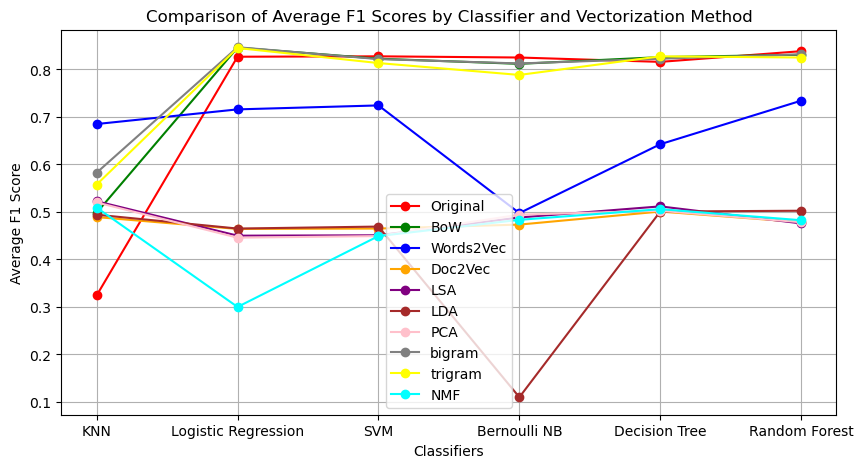

In [683]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
classifiers = ["KNN", "Logistic Regression", "SVM", "Bernoulli NB", "Decision Tree", "Random Forest"]



# Generate x values
x = np.arange(len(classifiers))

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(x, average_f1_scores, 'o-', label='Original', color='red')
plt.plot(x, average_f1_scoresBoW, 'o-', label='BoW', color='green')
plt.plot(x, average_f1_Words2vec, 'o-', label='Words2Vec', color='blue')
plt.plot(x, average_f1_Doc2vec, 'o-', label='Doc2Vec', color='orange')
plt.plot(x, average_f1_LSA, 'o-', label='LSA', color='purple')
plt.plot(x, average_f1_LDA, 'o-', label='LDA', color='brown')
plt.plot(x, average_f1_PCA, 'o-', label='PCA', color='pink')
plt.plot(x, average_f1_bigram, 'o-', label='bigram', color='gray')
plt.plot(x, average_f1_trigram, 'o-', label='trigram', color='yellow')
plt.plot(x, average_f1_NMF, 'o-', label='NMF', color='cyan')


# Adding labels and title
plt.xlabel('Classifiers')
plt.ylabel('Average F1 Score')
plt.title('Comparison of Average F1 Scores by Classifier and Vectorization Method')
plt.xticks(x, classifiers)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [399]:
# Visualization of F1-Score of all categories count
# result = pd.concat([result_HS_Count, result_Abusive_Count, result_Individual_Count, result_Group_Count, result_Religion_Count, result_Race_Count, result_Physical_Count, result_Gender_Count, result_Other_Count, result_Weak_Count, result_Moderate_Count, result_Strong_Count], axis=1)
# result = result.transpose()
# result.head(12)

### Plot F1-score

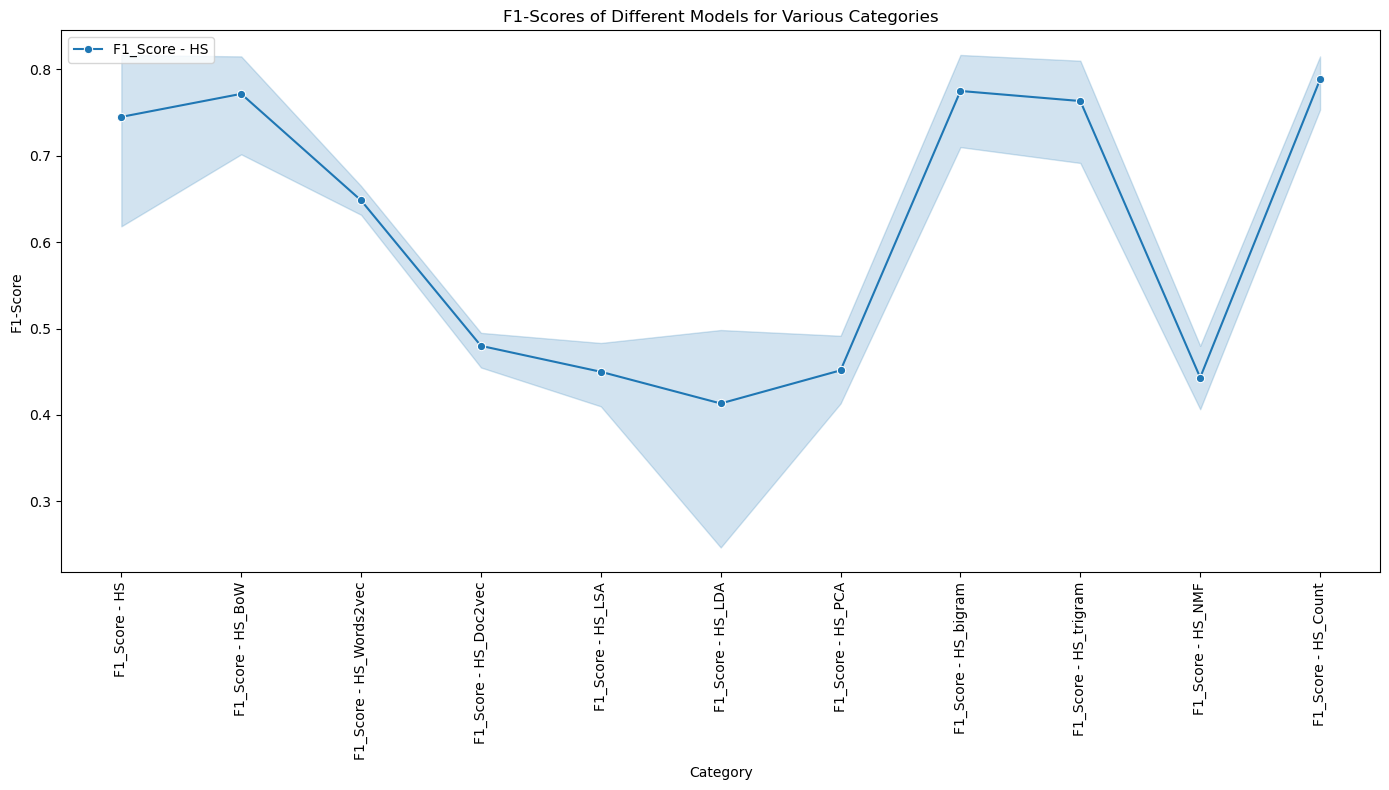

In [401]:
# Combine all results into a single DataFrame
result_HS['Category'] = 'F1_Score - HS'
result_HS_BoW['Category'] = 'F1_Score - HS_BoW'
result_HS_Words2vec['Category'] = 'F1_Score - HS_Words2vec'
result_HS_Doc2vec['Category'] = 'F1_Score - HS_Doc2vec'
result_HS_LSA['Category'] = 'F1_Score - HS_LSA'
result_HS_LDA['Category'] = 'F1_Score - HS_LDA'
result_HS_PCA['Category'] = 'F1_Score - HS_PCA'
result_HS_bigrams['Category'] = 'F1_Score - HS_bigram'
result_HS_trigrams['Category'] = 'F1_Score - HS_trigram'
result_HS_NMF['Category'] = 'F1_Score - HS_NMF'
result_HS_Count['Category'] = 'F1_Score - HS_Count'


# Concatenate all results
combined_result = pd.concat([
    result_HS, result_HS_BoW, result_HS_Words2vec,result_HS_Doc2vec, result_HS_LSA, result_HS_LDA, result_HS_PCA, result_HS_bigrams, result_HS_trigrams, result_HS_NMF, result_HS_Count
])

# Set the figure size
plt.figure(figsize=(14, 8))

# Melt the DataFrame for easier plotting
df_melted = combined_result.melt(id_vars="Category", var_name="Model", value_name="F1_Score")

# Create the line plot
sns.lineplot(data=df_melted, x="Category", y="F1_Score", hue="Model", marker="o")

# Rotate the category labels for better readability
plt.xticks(rotation=90, ha="center")

# Set the title and labels
plt.title("F1-Scores of Different Models for Various Categories")
plt.xlabel("Category")
plt.ylabel("F1-Score")

# Adjust the legend
plt.legend(loc="upper left")

# Show the plot
plt.tight_layout()
plt.show()

## Prediction - picking logistic regression model from above graph

In [403]:
example1 = ['Wahyu goblok gabisa mimpin negara gimana indonesia mau maju tolol anjing']

### HS

In [405]:
x = df_HS.Tweet.fillna(' ')
y = df_HS['HS']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvHS = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvHS.fit_transform(x_train)
x_test_scal = tfvHS.transform(x_test)
lrHS = LogisticRegression()
lrHS.fit(x_train_scal, y_train)
lrHS.predict(x_test_scal)[:100]

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0])

In [406]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvHS.transform(example1_preprocessed)
zero=lrHS.predict_proba(example1_transform)[:,0][0]
one=lrHS.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS')
else: 
    print('Not HS')

HS


### Abusive

In [408]:
x = df_Abusive.Tweet.fillna(' ')
y = df_Abusive['Abusive']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvAbusive = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvAbusive.fit_transform(x_train)
x_test_scal = tfvAbusive.transform(x_test)
lrAbusive = LogisticRegression()
lrAbusive.fit(x_train_scal, y_train)
lrAbusive.predict(x_test_scal)[:100]

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0])

In [409]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvAbusive.transform(example1_preprocessed)
zero=lrAbusive.predict_proba(example1_transform)[:,0][0]
one=lrAbusive.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('Abusive')
else: 
    print('Not Abusive')

Abusive


### HS_Individual

In [411]:
x = df_Individual.Tweet.fillna(' ')
y = df_Individual['HS_Individual']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvIndividual = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvIndividual.fit_transform(x_train)
x_test_scal = tfvIndividual.transform(x_test)
lrIndividual = LogisticRegression()
lrIndividual.fit(x_train_scal, y_train)
lrIndividual.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [412]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvIndividual.transform(example1_preprocessed)
zero=lrIndividual.predict_proba(example1_transform)[:,0][0]
one=lrIndividual.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Individual')
else: 
    print('Not HS_Individual')

HS_Individual


### HS_Group

In [414]:
x = df_Group.Tweet.fillna(' ')
y = df_Group['HS_Group']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvGroup = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvGroup.fit_transform(x_train)
x_test_scal = tfvGroup.transform(x_test)
lrGroup = LogisticRegression()
lrGroup.fit(x_train_scal, y_train)
lrGroup.predict(x_test_scal)[:100]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [415]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvGroup.transform(example1_preprocessed)
zero=lrGroup.predict_proba(example1_transform)[:,0][0]
one=lrGroup.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Group')
else: 
    print('Not HS_Group')

Not HS_Group


### HS_Religion

In [417]:
x = df_Religion.Tweet.fillna(' ')
y = df_Religion['HS_Religion']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvReligion = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvReligion.fit_transform(x_train)
x_test_scal = tfvReligion.transform(x_test)
lrReligion = LogisticRegression()
lrReligion.fit(x_train_scal, y_train)
lrReligion.predict(x_test_scal)[:100]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [418]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvReligion.transform(example1_preprocessed)
zero=lrReligion.predict_proba(example1_transform)[:,0][0]
one=lrReligion.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Religion')
else: 
    print('Not HS_Religion')

Not HS_Religion


### HS_Race

In [420]:
x = df_Race.Tweet.fillna(' ')
y = df_Race['HS_Race']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvRace = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvRace.fit_transform(x_train)
x_test_scal = tfvRace.transform(x_test)
lrRace = LogisticRegression()
lrRace.fit(x_train_scal, y_train)
lrRace.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [421]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvRace.transform(example1_preprocessed)
zero=lrRace.predict_proba(example1_transform)[:,0][0]
one=lrRace.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Race')
else: 
    print('Not HS_Race')

Not HS_Race


### HS_Gender

In [423]:
x = df_Gender.Tweet.fillna(' ')
y = df_Gender['HS_Gender']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvGender = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvGender.fit_transform(x_train)
x_test_scal = tfvGender.transform(x_test)
lrGender = LogisticRegression()
lrGender.fit(x_train_scal, y_train)
lrGender.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [424]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvGender.transform(example1_preprocessed)
zero=lrGender.predict_proba(example1_transform)[:,0][0]
one=lrGender.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Gender')
else: 
    print('Not HS_Gender')

Not HS_Gender


### HS_Other

In [426]:
x = df_Other.Tweet.fillna(' ')
y = df_Other['HS_Other']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvOther = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvOther.fit_transform(x_train)
x_test_scal = tfvOther.transform(x_test)
lrOther = LogisticRegression()
lrOther.fit(x_train_scal, y_train)
lrOther.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [427]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvOther.transform(example1_preprocessed)
zero=lrOther.predict_proba(example1_transform)[:,0][0]
one=lrOther.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Other')
else: 
    print('Not HS_Other')

HS_Other


### HS_Weak

In [429]:
x = df_Weak.Tweet.fillna(' ')
y = df_Weak['HS_Weak']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvWeak = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvWeak.fit_transform(x_train)
x_test_scal = tfvWeak.transform(x_test)
lrWeak = LogisticRegression()
lrWeak.fit(x_train_scal, y_train)
lrWeak.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [430]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvWeak.transform(example1_preprocessed)
zero=lrWeak.predict_proba(example1_transform)[:,0][0]
one=lrWeak.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Weak')
else: 
    print('Not HS_Weak')

HS_Weak


### HS_Moderate

In [432]:
x = df_Moderate.Tweet.fillna(' ')
y = df_Moderate['HS_Moderate']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvModerate = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvModerate.fit_transform(x_train)
x_test_scal = tfvModerate.transform(x_test)
lrModerate = LogisticRegression()
lrModerate.fit(x_train_scal, y_train)
lrModerate.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [433]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvModerate.transform(example1_preprocessed)
zero=lrModerate.predict_proba(example1_transform)[:,0][0]
one=lrModerate.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Moderate')
else: 
    print('Not HS_Moderate')

Not HS_Moderate


### HS_Strong

In [435]:
x = df_Strong.Tweet.fillna(' ')
y = df_Strong['HS_Strong']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvStrong = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvStrong.fit_transform(x_train)
x_test_scal = tfvStrong.transform(x_test)
lrStrong = LogisticRegression()
lrStrong.fit(x_train_scal, y_train)
lrStrong.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [436]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvStrong.transform(example1_preprocessed)
zero=lrStrong.predict_proba(example1_transform)[:,0][0]
one=lrStrong.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Strong')
else: 
    print('Not HS_Strong')

Not HS_Strong
